# Case study - Cat Chekr - Shubham verma(4206)

### A) Import Library

In [1]:
# import numpy and panda library
import pandas as pd
import numpy as np

# import visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# import Statistics library
import scipy.stats as stats
from sklearn.decomposition import PCA
import statsmodels.api as sm

# import sklearn for transformation
from scipy.fftpack import fft
from scipy.signal import welch
import scipy.signal
import signal 
import scipy

# import sklearn for train and test data
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
scaling = MinMaxScaler()


from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso


# import sklearn for metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve

# import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# import json, glob, stats
import json
import glob
import random

#import dataframe_image to print images
import dataframe_image as dfi
import librosa.display

# import warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#import dataframe_image to print images

### B) Data Preparation

#### B1) Data Prepration: Merge JSON & CSV file

In [3]:
### Import and merge each Json files into one file
read_files = glob.glob("Raw_data/**/*.json" , recursive=True)
data = []

for f in read_files:
    with open(f, "rb") as infile:
        data.append(json.load(infile))
        

        
### Convert Json files to dataframe df
df_raw = pd.DataFrame(columns = ["Device_ID", "Event_ID", "Event_start_time", "Tags", 
                             "Free_text", "Name_of_cat", "Weight_of_cat", "Tare_weight"])

for i in range(0, len(data)):
    currentitems = data[i]
    df_raw.loc[i] = [data[i]["Device_ID"], data[i]["Event_ID"], data[i]["Event_start_time"],data[i]["Tags"],
                 data[i]["Free_text"], data[i]["Name_of_cat"], data[i]["Weight_of_cat"],data[i]["Tare_weight"]]  

In [4]:
### Import sensor and merge csv files

csv_files = sorted(glob.glob("Raw_data/**/*.csv" , recursive=True))
sensor_data = pd.concat((pd.read_csv(file).assign(filename=file)
          for file in csv_files), ignore_index= True )

In [5]:
sensor_data.head(4)

,t,lc0,lc1,lc2,lc3,timestamp,sum,filename
0,0 days 00:00:00,4814,2504,5337,701,0.000,13356,Raw_data\VA00000000000017\RXZlbnRJbmZvcm1hdGlv...
1,0 days 00:00:00.025000,4656,2789,5481,497,0.025,13423,Raw_data\VA00000000000017\RXZlbnRJbmZvcm1hdGlv...
2,0 days 00:00:00.050000,4566,3137,5583,483,0.050,13769,Raw_data\VA00000000000017\RXZlbnRJbmZvcm1hdGlv...
3,0 days 00:00:00.075000,4640,3449,5724,628,0.075,14441,Raw_data\VA00000000000017\RXZlbnRJbmZvcm1hdGlv...


In [6]:
### Merged sensor data based on the csv file name
### Take statistics measures like Mean, Standard_deviation and time span of each sensor_reading 
s_avgdata = pd.DataFrame()
cols = ['lc0', 'lc1', 'lc2','lc3', 'sum']
s_avgdata[['lc0_mean', 'lc1_mean', 'lc2_mean','lc3_mean','lc_sum_mean']] = sensor_data.groupby(by = "filename" ).mean()[cols]
s_avgdata[['lc0_std', 'lc1_std', 'lc2_std','lc3_std', 'lc_sum_std']] = sensor_data.groupby(by = "filename" ).std()[cols]
s_avgdata['time_span'] = sensor_data.groupby(by = "filename" ).max()['timestamp']

In [7]:
### Define Log energy entrophy of the load sensor data
def Logenergy_entrophy(x):
    y = np.power(x,2)
    y1 = np.sum(y)
    PE = y/y1
    LEE = np.sum(PE*np.log(PE))
    return LEE

In [8]:
### Extract Different ststistics meansure of total load sensor data
s_avgdata['min_total_load'] = sensor_data.groupby(by = "filename" ).min()['sum']
s_avgdata['max_total_load'] = sensor_data.groupby(by = "filename" ).max()['sum']
s_avgdata['median_total_load'] = sensor_data.groupby(by = "filename" ).median()['sum']
s_avgdata['skew_total_load'] = sensor_data.groupby(by = "filename" )['sum'].apply(lambda x: stats.skew(x))
s_avgdata['kourtosis_total_load'] = sensor_data.groupby(by = "filename" )['sum'].apply(lambda x: stats.kurtosis(x))
s_avgdata['range_total_load'] = sensor_data.groupby(by = "filename" )['sum'].apply(lambda x: np.max(x)-np.min(x))
s_avgdata['log_e_entro__total_load'] = sensor_data.groupby(by = "filename" )['sum'].apply(lambda x: Logenergy_entrophy(x))
s_avgdata = s_avgdata.reset_index()

In [9]:
### Taking average load sensor data statistics measures
s_avgdata['lc_max_4_sensor'] = 0
for i in range(0,len(s_avgdata)):
    s_avgdata['lc_max_4_sensor'][i] = np.max((s_avgdata['lc0_mean'][i],s_avgdata['lc1_mean'][i],s_avgdata['lc2_mean'][i],s_avgdata['lc3_mean'][i]))
    
    
s_avgdata['lc_min_4_sensor'] = 0
for i in range(0,len(s_avgdata)):
    s_avgdata['lc_min_4_sensor'][i] = np.min((s_avgdata['lc0_mean'][i],s_avgdata['lc1_mean'][i],s_avgdata['lc2_mean'][i],s_avgdata['lc3_mean'][i]))

    
s_avgdata['std_of_mean_4_sensor'] = 0
for i in range(0,len(s_avgdata)):
    s_avgdata['std_of_mean_4_sensor'][i] = np.std((s_avgdata['lc0_mean'][i],s_avgdata['lc1_mean'][i],s_avgdata['lc2_mean'][i],s_avgdata['lc3_mean'][i]))

In [10]:
### Taking average load sensor data statistics measures
s_avgdata['max_of_std_4_sensor'] = 0
for i in range(0,len(s_avgdata)):
    s_avgdata['max_of_std_4_sensor'][i] = np.max((s_avgdata['lc0_std'][i],s_avgdata['lc1_std'][i],s_avgdata['lc2_std'][i],s_avgdata['lc3_std'][i]))
    
    
s_avgdata['min_of_std_4_sensor'] = 0
for i in range(0,len(s_avgdata)):
    s_avgdata['min_of_std_4_sensor'][i] = np.min((s_avgdata['lc0_std'][i],s_avgdata['lc1_std'][i],s_avgdata['lc2_std'][i],s_avgdata['lc3_std'][i]))
    
    
s_avgdata['mean_of_std_4_sensor'] = 0
for i in range(0,len(s_avgdata)):
    s_avgdata['mean_of_std_4_sensor'][i] = np.mean((s_avgdata['lc0_std'][i],s_avgdata['lc1_std'][i],s_avgdata['lc2_std'][i],s_avgdata['lc3_std'][i]))
    
    
s_avgdata['std_of_std_4_sensor'] = 0
for i in range(0,len(s_avgdata)):
    s_avgdata['std_of_std_4_sensor'][i] = np.std((s_avgdata['lc0_std'][i],s_avgdata['lc1_std'][i],s_avgdata['lc2_std'][i],s_avgdata['lc3_std'][i]))
    
s_avgdata = s_avgdata.reset_index()

In [11]:
### cleaning the sensor data
s_avgdata[['Event_ID', 'csv']] = s_avgdata['filename'].str.split(".", n=2 , expand= True)
s_avgdata[['d2','Event_ID']] = s_avgdata['Event_ID'].str.split("RX", n=2 , expand= True)
s_avgdata['Event_ID'] = "RX" + s_avgdata['Event_ID'] 

s_avgdata.drop(columns= ['lc0_mean', 'lc1_mean', 'lc2_mean', 'lc3_mean',
                         'lc1_std', 'lc0_std', 'lc2_std', 'lc3_std'], inplace = True)

In [12]:
### Last_reading/Mode of each sensor_reading of a unit csv file and taking avrage mode value of multiple mode
s_avgdata['last_sum'] = sensor_data[['filename', 'sum']].groupby(by = "filename" ).agg(pd.Series.mode).reset_index()['sum']
s_avgdata['last_sum'] = s_avgdata['last_sum'].apply(lambda x: x.mean())
s_avgdata['last_sum'] = s_avgdata['last_sum'].astype(int)

### Convert foreign key as Event_ID from sensor data
s_avgdata.drop(columns= ['filename', 'csv', 'd2' ] , inplace= True)

In [13]:
### Define funtion for frequency bins and thier statistics measure from them

cols = ['Max_PSDF', 'Min_PSDF', 'Median_PSDF', 'Mean_PSDF', 'Std_PSDF']
bins = [0,5,10,15,20] 
category = ['0_5_Hz','6_10_Hz','11_15_Hz','16_20_Hz']
    
def PSDF_0_5Hz_max(sig):
    (f, S) = scipy.signal.periodogram(sig, 40, scaling='density')
    df = pd.DataFrame(list(zip(f, S)), columns =['f_value', 'PSDF'])
    df['f_cat'] = pd.cut(df["f_value"],bins,labels = category)
    df_n = df.groupby('f_cat').agg(Max_PSDF = ('PSDF', 'max'),Min_PSDF = ('PSDF', 'min'),Median_PSDF = ('PSDF', 'median'), Mean_PSDF = ('PSDF', 'mean'), Std_PSDF = ('PSDF', 'std')).reset_index() 
    return df_n[df_n['f_cat'] == '0_5_Hz'][cols]

def PSDF_5_10Hz_max(sig):
    (f, S) = scipy.signal.periodogram(sig, 40, scaling='density')
    df = pd.DataFrame(list(zip(f, S)), columns =['f_value', 'PSDF'])
    df['f_cat'] = pd.cut(df["f_value"],bins,labels = category)
    df_n = df.groupby('f_cat').agg(Max_PSDF = ('PSDF', 'max'),Min_PSDF = ('PSDF', 'min'),Median_PSDF = ('PSDF', 'median'), Mean_PSDF = ('PSDF', 'mean'), Std_PSDF = ('PSDF', 'std')).reset_index() 
    return df_n[df_n['f_cat'] == '6_10_Hz'][cols]

def PSDF_10_15Hz_max(sig):
    (f, S) = scipy.signal.periodogram(sig, 40, scaling='density')
    df = pd.DataFrame(list(zip(f, S)), columns =['f_value', 'PSDF'])
    df['f_cat'] = pd.cut(df["f_value"],bins,labels = category)
    df_n = df.groupby('f_cat').agg(Max_PSDF = ('PSDF', 'max'),Min_PSDF = ('PSDF', 'min'),Median_PSDF = ('PSDF', 'median'), Mean_PSDF = ('PSDF', 'mean'), Std_PSDF = ('PSDF', 'std')).reset_index() 
    return df_n[df_n['f_cat'] == '11_15_Hz'][cols]

def PSDF_15_20Hz_max(sig):
    (f, S) = scipy.signal.periodogram(sig, 40, scaling='density')
    df = pd.DataFrame(list(zip(f, S)), columns =['f_value', 'PSDF'])
    df['f_cat'] = pd.cut(df["f_value"],bins,labels = category)
    df_n = df.groupby('f_cat').agg(Max_PSDF = ('PSDF', 'max'),Min_PSDF = ('PSDF', 'min'),Median_PSDF = ('PSDF', 'median'), Mean_PSDF = ('PSDF', 'mean'), Std_PSDF = ('PSDF', 'std')).reset_index() 
    return df_n[df_n['f_cat'] == '16_20_Hz'][cols]

In [14]:
### Convert data to the frequency bins in 4 parts
### taking bins of four parts and extract the statistics measure from them

s_avgdata[['PSDF_0_5Hz_max', 'PSDF_0_5Hz_min', 'PSDF_0_5Hz_median', 'PSDF_0_5Hz_mean', 'PSDF_0_5Hz_std' ]] = sensor_data.groupby(by = 'filename')['sum'].apply(lambda x: PSDF_0_5Hz_max(x)).reset_index()[cols]
s_avgdata[['PSDF_5_10Hz_max', 'PSDF_5_10Hz_min', 'PSDF_5_10Hz_median', 'PSDF_5_10Hz_mean', 'PSDF_5_10Hz_std' ]] = sensor_data.groupby(by = 'filename')['sum'].apply(lambda x: PSDF_5_10Hz_max(x)).reset_index()[cols]

In [15]:
s_avgdata[['PSDF_10_15Hz_max', 'PSDF_10_15Hz_min', 'PSDF_10_15Hz_median', 'PSDF_10_15Hz_mean', 'PSDF_10_15Hz_std' ]] = sensor_data.groupby(by = 'filename')['sum'].apply(lambda x: PSDF_10_15Hz_max(x)).reset_index()[cols]
s_avgdata[['PSDF_15_20Hz_max', 'PSDF_15_20Hz_min', 'PSDF_15_20Hz_median', 'PSDF_15_20Hz_mean', 'PSDF_15_20Hz_std' ]] = sensor_data.groupby(by = 'filename')['sum'].apply(lambda x: PSDF_15_20Hz_max(x)).reset_index()[cols]

In [16]:
### Round of the numeric value of data
num_cols = s_avgdata.select_dtypes([np.number]).columns.to_list()
s_avgdata[num_cols] = s_avgdata[num_cols].round(2)
s_avgdata = s_avgdata.reset_index(drop =True)
s_avgdata.head(3)

,index,lc_sum_mean,lc_sum_std,time_span,min_total_load,max_total_load,median_total_load,skew_total_load,kourtosis_total_load,range_total_load,log_e_entro__total_load,lc_max_4_sensor,lc_min_4_sensor,std_of_mean_4_sensor,max_of_std_4_sensor,min_of_std_4_sensor,mean_of_std_4_sensor,std_of_std_4_sensor,Event_ID,last_sum,PSDF_0_5Hz_max,PSDF_0_5Hz_min,PSDF_0_5Hz_median,PSDF_0_5Hz_mean,PSDF_0_5Hz_std,PSDF_5_10Hz_max,PSDF_5_10Hz_min,PSDF_5_10Hz_median,PSDF_5_10Hz_mean,PSDF_5_10Hz_std,PSDF_10_15Hz_max,PSDF_10_15Hz_min,PSDF_10_15Hz_median,PSDF_10_15Hz_mean,PSDF_10_15Hz_std,PSDF_15_20Hz_max,PSDF_15_20Hz_min,PSDF_15_20Hz_median,PSDF_15_20Hz_mean,PSDF_15_20Hz_std
0,0,10112.07,2961.45,151.97,7982,16035,8214.0,0.93,-1.11,8053,-8.55,4777.92,-1406.29,2349.53,1165.76,427.83,805.18,304.86,RXZlbnRJbmZvcm1hdGlvbjo0OWQ4M2I3MS1kNDZmLTRiYj...,8211,8.256649e+08,17.56,7856.35,1752719.05,32067137.51,6566.49,0.31,415.19,772.15,945.09,1006.09,0.39,114.44,162.88,149.53,399.66,0.01,81.53,97.96,72.72
1,1,10049.85,3453.25,111.97,6796,14962,6825.0,0.13,-1.97,8166,-8.20,5344.23,-2520.61,3097.21,1947.76,23.94,1077.17,870.25,RXZlbnRJbmZvcm1hdGlvbjo0YmI3ZDc5YS0wNzMwLTQ0MT...,6799,1.084066e+09,0.00,4732.60,2383647.12,46066185.92,7918.87,0.20,284.54,609.24,987.50,531.12,0.10,94.54,120.25,98.92,353.93,0.92,66.01,80.68,63.16
2,2,11050.50,2572.06,102.37,8739,15311,8875.0,0.31,-1.84,6572,-8.21,4815.72,921.63,1501.45,994.39,527.97,721.89,169.71,RXZlbnRJbmZvcm1hdGlvbjo0ZTBhMDVhOC0wZmI2LTQ2MG...,8749,5.414413e+08,0.26,2563.69,1322479.34,24047558.26,2274.47,0.21,120.26,245.79,334.28,252.31,0.06,21.42,32.53,36.06,118.56,0.01,11.88,16.64,15.70


In [17]:
### Merge the two dataset on Primary key "Event_ID"

f_data = pd.merge(df_raw , s_avgdata)
dataset = f_data
dataset.head(4)

,Device_ID,Event_ID,Event_start_time,Tags,Free_text,Name_of_cat,Weight_of_cat,Tare_weight,index,lc_sum_mean,lc_sum_std,time_span,min_total_load,max_total_load,median_total_load,skew_total_load,kourtosis_total_load,range_total_load,log_e_entro__total_load,lc_max_4_sensor,lc_min_4_sensor,std_of_mean_4_sensor,max_of_std_4_sensor,min_of_std_4_sensor,mean_of_std_4_sensor,std_of_std_4_sensor,last_sum,PSDF_0_5Hz_max,PSDF_0_5Hz_min,PSDF_0_5Hz_median,PSDF_0_5Hz_mean,PSDF_0_5Hz_std,PSDF_5_10Hz_max,PSDF_5_10Hz_min,PSDF_5_10Hz_median,PSDF_5_10Hz_mean,PSDF_5_10Hz_std,PSDF_10_15Hz_max,PSDF_10_15Hz_min,PSDF_10_15Hz_median,PSDF_10_15Hz_mean,PSDF_10_15Hz_std,PSDF_15_20Hz_max,PSDF_15_20Hz_min,PSDF_15_20Hz_median,PSDF_15_20Hz_mean,PSDF_15_20Hz_std
0,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0OWQ4M2I3MS1kNDZmLTRiYj...,2020-09-05T10:56:11-05:00,"[urination, cat in box]",None,Ryan,6589,None,0,10112.07,2961.45,151.97,7982,16035,8214.0,0.93,-1.11,8053,-8.55,4777.92,-1406.29,2349.53,1165.76,427.83,805.18,304.86,8211,8.256649e+08,17.56,7856.35,1752719.05,32067137.51,6566.49,0.31,415.19,772.15,945.09,1006.09,0.39,114.44,162.88,149.53,399.66,0.01,81.53,97.96,72.72
1,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0YmI3ZDc5YS0wNzMwLTQ0MT...,2020-07-18T14:41:37-05:00,"[cat in box, synapse_labeled, urination]","14:42:15\t14:43:09\tConfirmed activity, cat in...",Ryan,6935,None,1,10049.85,3453.25,111.97,6796,14962,6825.0,0.13,-1.97,8166,-8.20,5344.23,-2520.61,3097.21,1947.76,23.94,1077.17,870.25,6799,1.084066e+09,0.00,4732.60,2383647.12,46066185.92,7918.87,0.20,284.54,609.24,987.50,531.12,0.10,94.54,120.25,98.92,353.93,0.92,66.01,80.68,63.16
2,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0ZTBhMDVhOC0wZmI2LTQ2MG...,2020-09-03T15:43:43-05:00,"[cat in box, urination]",None,Ryan,5139,None,2,11050.50,2572.06,102.37,8739,15311,8875.0,0.31,-1.84,6572,-8.21,4815.72,921.63,1501.45,994.39,527.97,721.89,169.71,8749,5.414413e+08,0.26,2563.69,1322479.34,24047558.26,2274.47,0.21,120.26,245.79,334.28,252.31,0.06,21.42,32.53,36.06,118.56,0.01,11.88,16.64,15.70
3,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo1NGEwMTg2My01NDhjLTRhYT...,2020-09-01T12:02:05-05:00,"[non_elimination, cat in box]",None,Ryan,6983,None,3,9855.52,2384.83,66.37,8786,16092,8795.0,1.89,1.69,7306,-7.76,3067.45,1248.88,714.40,1585.05,232.76,632.58,555.06,8792,1.370647e+08,293.68,6109.66,1135653.75,10196401.51,3310.64,134.17,702.63,832.91,488.68,704.72,91.09,324.73,333.25,113.08,453.35,96.13,227.50,231.68,63.10


#### B2) Data Prepration: Extract features from data

In [18]:
#List of Unique Tags 

list = []
for i in range(0, len(dataset)):
    for j in range(0, len(dataset['Tags'][i])):       
        list.append(dataset['Tags'][i][j])
        
list = set(list)
list

#non_elimination = 4146/13075
#eliminations = 8929/13075
#eliminations & defecation = 2316/8929
#eliminations & no-defecation = 6613/8929

{'cat in box',
 'cat on edge of box',
 'cat on top of box',
 'cat rubbing box',
 'defecation',
 'elimination',
 'front trimmed',
 'mixed',
 'non_elimination',
 'partial cat in box',
 'review complete',
 'synapse_labeled',
 'technician moving box',
 'urination',
 'vomit'}

In [19]:
### Treat Missing value of "Free_text" by "Not Avaiable"
dataset.replace(to_replace=[None], value=np.nan, inplace=True)
dataset['Free_text'] = dataset['Free_text'].fillna("Not Avaiable")

In [20]:
#list of unique free tags
freetext = []
for i in range(0, len(dataset)):    
    freetext.append(dataset['Free_text'][i])
    
a =[]
for i in range(0, len(freetext)):    
    if freetext[i] != "Not Avaiable":
        freetext[i] = freetext[i].split(", ")    
        for j in range(1, len(freetext[i])):  
            a.append(freetext[i][j])
            
free_text = set(a)
### Activity that are happen
### Some Activity that are happen more than 250 time among the data available
#### 1) urinates twice, 2) jumped, 3) paws, 4) drift, 5) feet(Unit feet set to 5mm), 6) scratching, 7) napping, 8) licking

In [21]:
### Correcting "Weight_of_cat" data type from object to int
dataset['Weight_of_cat'] = dataset['Weight_of_cat'].astype(int)
dataset['power_by_cat'] = (dataset['lc_sum_mean']*dataset['lc_sum_mean']*dataset['time_span'])/(dataset['Weight_of_cat']*1000)
dataset['power_by_cat'] = dataset['power_by_cat'].round(1)

In [22]:
### Mark 'non_elimination', 'urination', 'defecation' tag that are capture during observation
dataset['non_elimination'] = dataset['Tags'].apply(lambda x :1 if "non_elimination" in x else 0 )
dataset['urination'] = dataset['Tags'].apply(lambda x :1 if "urination" in x else 0)
dataset['defecation'] = dataset['Tags'].apply(lambda x :1 if "defecation" in x else 0 )

In [23]:
# Deleted Unidentified elimination entry
abc = dataset[dataset['non_elimination'] == 0]
unidentified = abc[(abc['urination'] == 0) & (abc['defecation'] == 0)]['Free_text']
dataset = dataset.drop(index = unidentified.index).reset_index(drop= True)

In [24]:
### Mark cat Activity tag that are capture during observation

dataset['Is_cat_Box'] = dataset['Tags'].apply(lambda x :1 if "cat in box" in x else 0 )
dataset['synapse_labeled'] = dataset['Tags'].apply(lambda x :1 if "synapse_labeled" in x else 0 )
dataset['cat_on_edge'] = dataset['Tags'].apply(lambda x :1 if "cat on edge of box" in x else 0 )
dataset['cat_rubbing_box'] = dataset['Tags'].apply(lambda x :1 if "cat rubbing box" in x else 0 )
dataset['mixed'] = dataset['Tags'].apply(lambda x :1 if "mixed" in x else 0 )
dataset['partial_cat_in_box'] = dataset['Tags'].apply(lambda x :1 if "partial cat in box" in x else 0 )
dataset['vomit'] = dataset['Tags'].apply(lambda x :1 if "vomit" in x else 0 )

In [25]:
###Based on free text these are the mojor activity that are capture during observatoion
### Mark Jumping activity that are capture during observation

dataset['Act_jumped'] = dataset['Free_text'].apply(lambda x :1 if "jumped" in x else 0 )
dataset['Act_paws'] = dataset['Free_text'].apply(lambda x :1 if "paws" in x else 0 )
dataset['Act_drift'] = dataset['Free_text'].apply(lambda x :1 if "drift" in x else 0 )
dataset['Act_feet5mm'] = dataset['Free_text'].apply(lambda x :1 if "feet" in x else 0 )
dataset['Act_digging_cover'] = dataset['Free_text'].apply(lambda x :1 if ("digging" or "cover") in x  else 0 )
dataset['cat_on_top'] = dataset['Tags'].apply(lambda x :1 if "cat on top of box" in x else 0 )

In [26]:
# Extract Date and Time feature
dataset[['Date', 'Time']] = dataset['Event_start_time'].str.split("T", n=2 , expand= True)
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['EVENT_MONTH'] = dataset['Date'].dt.month
dataset[['Time', 'e']] = dataset['Time'].str.split("-", n=2 , expand= True)
dataset['Time'] = dataset['Time'].astype(str)
dataset['hour'] = dataset['Time'].apply(lambda x : (x[0:2]))

dataset.drop(columns = ['Free_text', 'Tags', 'e'] ,inplace = True)

In [27]:
dataset[dataset['Is_cat_Box'] == 0]['Is_cat_Box'].count()
#Only 'Cat in the box' is 20 which is only 0.1%

dataset[dataset['synapse_labeled'] == 1]['synapse_labeled'].count()
#Only 'synapse_labeled' is 243 which is only about 2%

dataset[dataset['cat_on_edge'] == 1]['cat_on_edge'].count()
#Only 'cat_on_edge' is 55 which is only about 2%

dataset[dataset['cat_rubbing_box'] == 1]['cat_rubbing_box'].count()
#Only 'cat_rubbing_box' is 59 which is only about 0.5%

dataset[dataset['mixed'] == 1]['mixed'].count()
#Only 'mixed' is 3 which is only about 0.01%

dataset[dataset['partial_cat_in_box'] == 1]['partial_cat_in_box'].count()
#Only 'partial_cat_in_box' is 59 which is only about 2%

dataset[dataset['vomit'] == 1]['mixed'].count()
#Only 'vomit' is 14 which is only about 2%

14

In [28]:
#Since there is no variation of 'mixed' and 'Is_cat_Box' so removing these elements

dataset.drop(columns = ['Is_cat_Box', 'mixed', 'cat_on_top', 'Event_start_time'] ,inplace = True)

In [29]:
dfi.export(dataset.head(10), 'dataset1.png', max_cols=40)

### C1) Data Cleaning

#### C1) Data Cleaning: Checking data type 

In [30]:
dataset.dtypes

Device_ID                    object
Event_ID                     object
Name_of_cat                  object
Weight_of_cat                 int32
Tare_weight                  object
                          ...      
Act_digging_cover             int64
Date                 datetime64[ns]
Time                         object
EVENT_MONTH                   int64
hour                         object
Length: 62, dtype: object

In [31]:
dataset['Weight_of_cat'] = dataset['Weight_of_cat'].astype(int)

#### C2) Data Cleaning: check & Treat Missing value

In [32]:
dataset.isna().sum()

Device_ID               0
Event_ID                0
Name_of_cat           246
Weight_of_cat           0
Tare_weight          1012
                     ... 
Act_digging_cover       0
Date                    0
Time                    0
EVENT_MONTH             0
hour                    0
Length: 62, dtype: int64

In [33]:
### Treat Missing value of "Name_of_Cat" by Device_ID
### Because all the device has only one type of Cat so fill with same "Name_of_Cat" 

list = {}
for i in range(0, len(dataset)):      
    if dataset['Name_of_cat'][i] != 'None':
        list.update({dataset['Device_ID'][i] : dataset['Name_of_cat'][i]})
        
dataset['Name_of_cat'].fillna('0' , inplace = True)

for i in range(0, len(dataset)):
    if dataset['Name_of_cat'][i] == '0' : 
        dataset['Name_of_cat'][i] = list[dataset['Device_ID'][i]]

<AxesSubplot:>

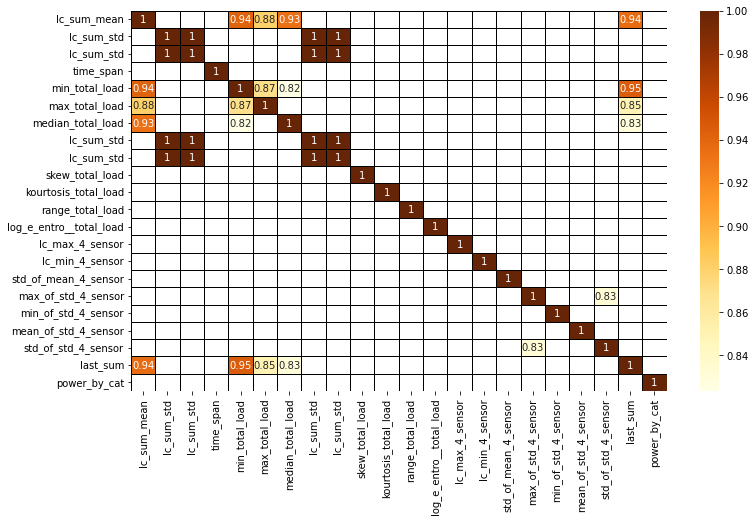

In [34]:
# checking load sensor statistics measure co-relation
act = dataset[['lc_sum_mean', 'lc_sum_std', 'time_span', 'min_total_load',
       'max_total_load', 'median_total_load', 'lc_sum_std',
       'skew_total_load', 'kourtosis_total_load', 'range_total_load',
       'log_e_entro__total_load', 'lc_max_4_sensor', 'lc_min_4_sensor',
       'std_of_mean_4_sensor', 'max_of_std_4_sensor', 'min_of_std_4_sensor',
       'mean_of_std_4_sensor', 'std_of_std_4_sensor', 'last_sum', 'power_by_cat']]

corr = act[act.columns].corr()
plt.figure(figsize=(12,7))
sns.heatmap(corr[corr>=.8], cmap="YlOrBr",linewidths=0.8, linecolor='k',annot=True)

<AxesSubplot:>

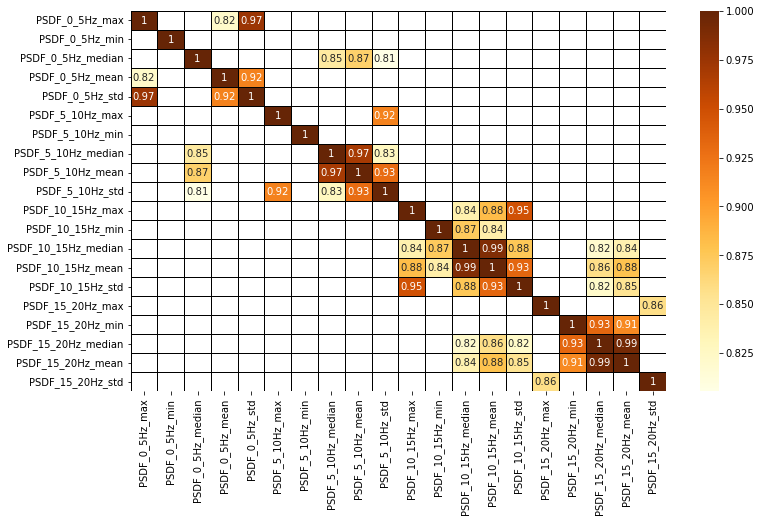

In [35]:
# checking load PSD sensor statistics measure co-relation
act = dataset[['PSDF_0_5Hz_max', 'PSDF_0_5Hz_min', 'PSDF_0_5Hz_median',
       'PSDF_0_5Hz_mean', 'PSDF_0_5Hz_std', 'PSDF_5_10Hz_max',
       'PSDF_5_10Hz_min', 'PSDF_5_10Hz_median', 'PSDF_5_10Hz_mean',
       'PSDF_5_10Hz_std', 'PSDF_10_15Hz_max', 'PSDF_10_15Hz_min',
       'PSDF_10_15Hz_median', 'PSDF_10_15Hz_mean', 'PSDF_10_15Hz_std',
       'PSDF_15_20Hz_max', 'PSDF_15_20Hz_min', 'PSDF_15_20Hz_median',
       'PSDF_15_20Hz_mean', 'PSDF_15_20Hz_std']]

corr = act[act.columns].corr()
plt.figure(figsize=(12,7))
sns.heatmap(corr[corr>=.8], cmap="YlOrBr",linewidths=0.8, linecolor='k',annot=True)

<AxesSubplot:>

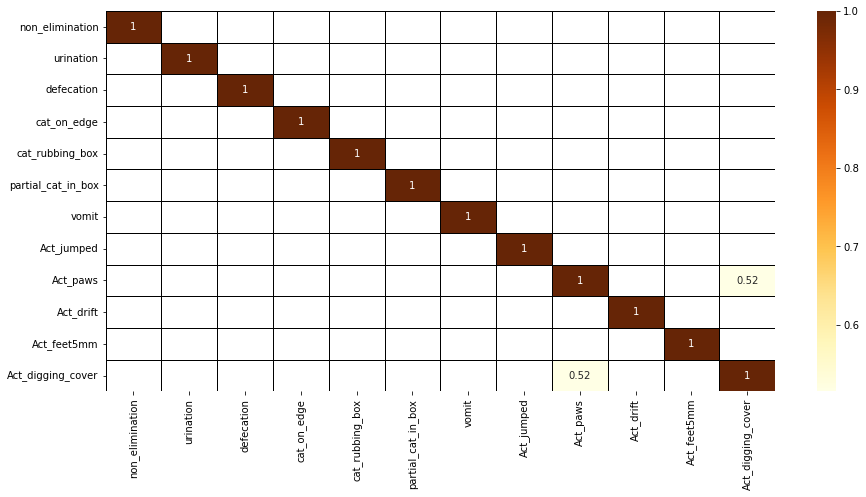

In [36]:
# checking Activity co-relation
reading = dataset[['non_elimination', 'urination', 'defecation',
       'cat_on_edge', 'cat_rubbing_box', 'partial_cat_in_box', 'vomit',
       'Act_jumped', 'Act_paws', 'Act_drift', 'Act_feet5mm',
       'Act_digging_cover']]

corr = reading[reading.columns].corr()
plt.figure(figsize=(15,7))
sns.heatmap(corr[corr>0.4], cmap="YlOrBr",linewidths=0.8, linecolor='k',annot=True)


In [37]:
dataset.drop(['Tare_weight'] ,axis= 1 ,inplace = True)
dataset.drop(columns = "index", inplace = True)

#### C3) Data Cleaning: Outlier check 

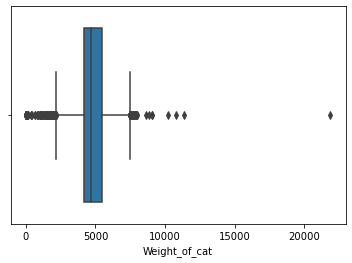

In [38]:
### a) Weight of cat
sns.boxplot(x = 'Weight_of_cat',data=dataset)
plt.show()

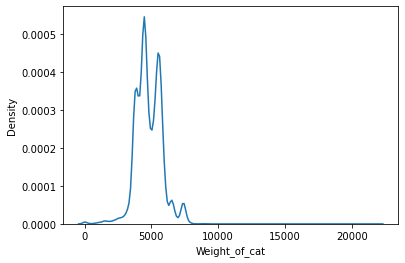

In [39]:
sns.kdeplot(x = 'Weight_of_cat',data=dataset)
plt.show()

In [40]:
### By definition, an outlier is a datapoint located outside where data between is the 90th percentile - 10th percentile.
### In the current problem, the datapoints greater than the points within the range are not errors or rare events.
### Thus it makes sense traet the outlier with thier median value.

a = dataset.groupby(by = "Name_of_cat")['Weight_of_cat'].median()
Q10 = dataset.groupby(by = "Name_of_cat")['Weight_of_cat'].quantile(0.20)
Q90 = dataset.groupby(by = "Name_of_cat")['Weight_of_cat'].quantile(0.80)


### Treat Outlier value of Weight_of_cat by Name_of_Cat

for i in range(0, len(dataset)):
    if dataset['Weight_of_cat'][i] < Q10[dataset['Name_of_cat'][i]]:
        dataset['Weight_of_cat'][i] = a[dataset['Name_of_cat'][i]]
    elif dataset['Weight_of_cat'][i] > Q90[dataset['Name_of_cat'][i]]:
        dataset['Weight_of_cat'][i] = a[dataset['Name_of_cat'][i]]

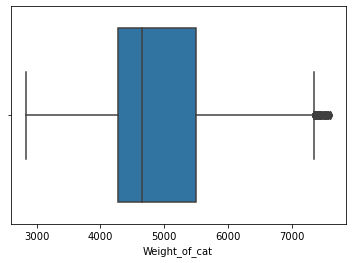

In [41]:
sns.boxplot(x = 'Weight_of_cat',data=dataset)
plt.show()

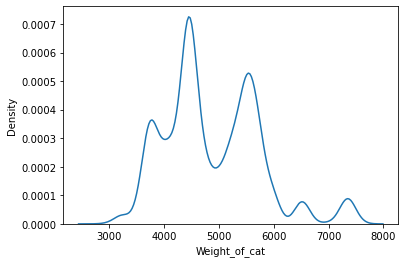

In [42]:
sns.kdeplot(x = 'Weight_of_cat',data=dataset)
plt.show()

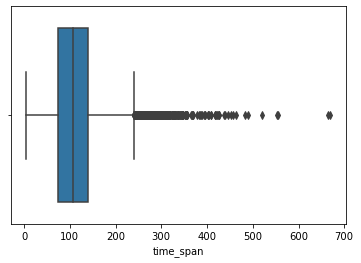

In [43]:
### b) time span
sns.boxplot(x = 'time_span',data=dataset)
plt.show()

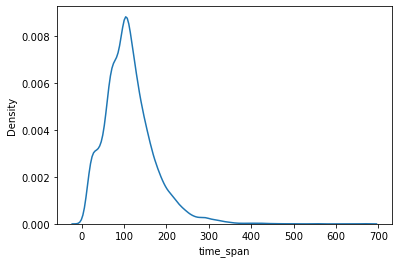

In [44]:
sns.kdeplot(x = 'time_span',data=dataset)
plt.show()

In [45]:
Q75 = dataset['time_span'].quantile(0.75)
Q25 = dataset['time_span'].quantile(0.25)
A = Q75 + 2.5*(Q75-Q25)

for i in range(0, len(dataset)):
    if dataset['time_span'][i] > A:
        dataset['time_span'][i] = A

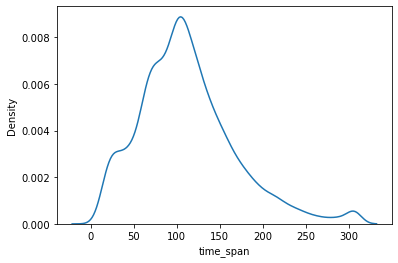

In [46]:
sns.kdeplot(x = 'time_span',data=dataset)
plt.show()

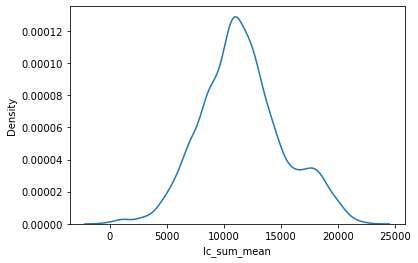

In [47]:
### c) load mean
sns.kdeplot(x = 'lc_sum_mean',data=dataset)
plt.show()

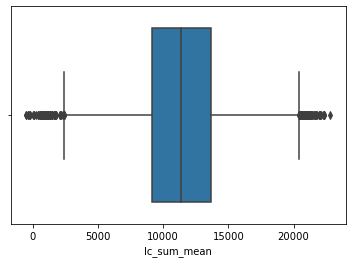

In [48]:
sns.boxplot(x = 'lc_sum_mean',data=dataset)
plt.show()

In [49]:
Q75 = dataset['lc_sum_mean'].quantile(0.75)
Q25 = dataset['lc_sum_mean'].quantile(0.25)
a = Q75 + 1.5*(Q75-Q25)
b = Q25 - 1.5*(Q75-Q25)

#for i in range(0,len(dataset))
    #if dataset['sum_mean'][i] > a
        #dataset['sum_mean'] = 
#print(a,b)

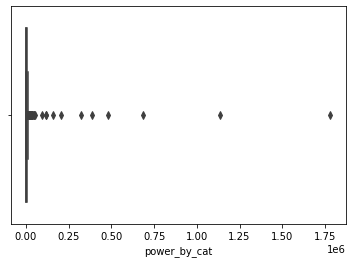

In [50]:
### c) power by cat
sns.boxplot(x = 'power_by_cat',data=dataset)
plt.show()

### E1) Exploratory data Analysis - Uni & Bi-variate Analysis

### A) Activity: Elimination, Urination and Defecation

<AxesSubplot:xlabel='urination', ylabel='time_span'>

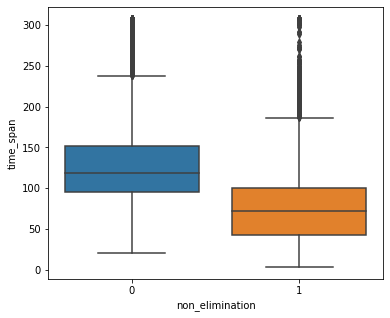

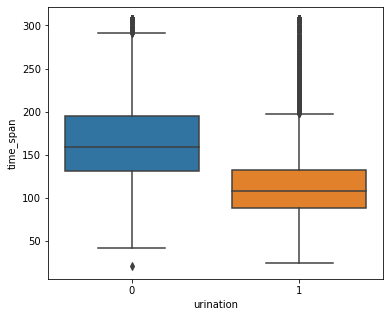

In [51]:
#Boxplot of Activity Time span
plt.figure(figsize=(6,5))
sns.boxplot(x = 'non_elimination',y ='time_span',data = dataset)


#Boxplot of Activity Time span when elimination was there
plt.figure(figsize=(6,5))
sns.boxplot(x = 'urination',y ='time_span', data = dataset[dataset['non_elimination'] == 0])

<AxesSubplot:xlabel='urination', ylabel='lc_sum_mean'>

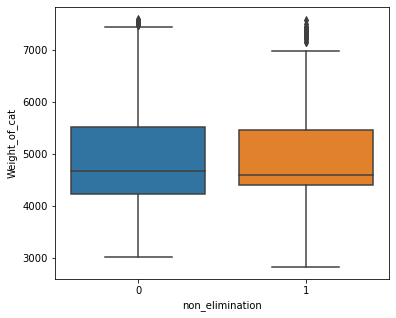

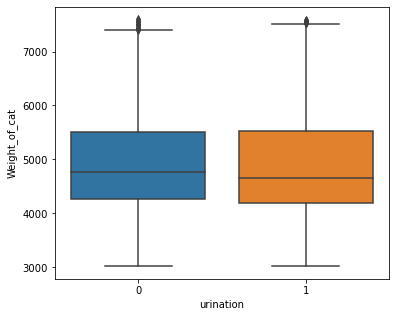

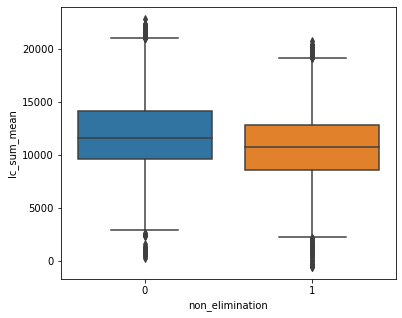

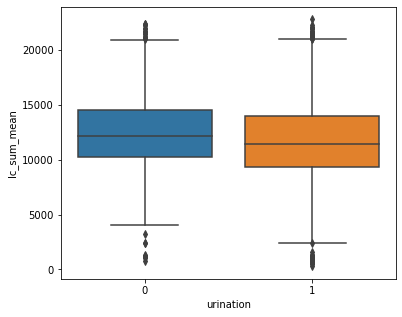

In [52]:
### Boxplot of Activity Time span
plt.figure(figsize=(6,5))
sns.boxplot(x = 'non_elimination',y ='Weight_of_cat',data = dataset)


### Boxplot of Activity Time span when elimination was there
plt.figure(figsize=(6,5))
sns.boxplot(x = 'urination',y ='Weight_of_cat', data = dataset[dataset['non_elimination'] == 0])


### Boxplot of Activity Time span 'lc_total_mean','lc_total_std', 'std_of_mean_4_sensor','mean_of_std_4_sensor'
plt.figure(figsize=(6,5))
sns.boxplot(x = 'non_elimination',y ='lc_sum_mean',data = dataset)


### Boxplot of Activity Time span when elimination was there
plt.figure(figsize=(6,5))
sns.boxplot(x = 'urination',y ='lc_sum_mean', data = dataset[dataset['non_elimination'] == 0])

<AxesSubplot:xlabel='non_elimination', ylabel='mean_of_std_4_sensor'>

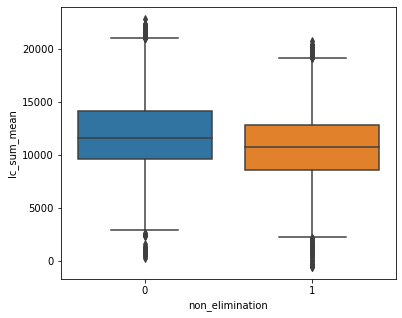

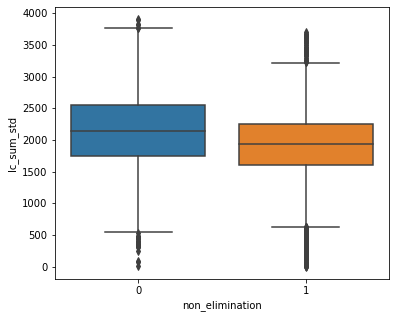

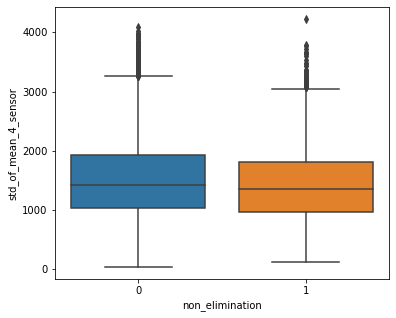

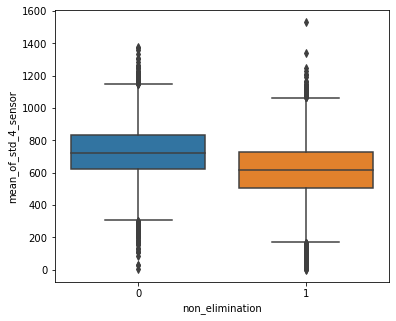

In [53]:
### Boxplot of Activity Time span
plt.figure(figsize=(6,5))
sns.boxplot(x = 'non_elimination',y ='lc_sum_mean',data = dataset)


### Boxplot of Activity Time span when elimination was there
plt.figure(figsize=(6,5))
sns.boxplot(x = 'non_elimination',y ='lc_sum_std', data = dataset)


### Boxplot of Activity Time span 'lc_total_mean','lc_total_std', 'std_of_mean_4_sensor','mean_of_std_4_sensor'
plt.figure(figsize=(6,5))
sns.boxplot(x = 'non_elimination',y ='std_of_mean_4_sensor',data = dataset)


### Boxplot of Activity Time span when elimination was there
plt.figure(figsize=(6,5))
sns.boxplot(x = 'non_elimination',y ='mean_of_std_4_sensor', data = dataset)

<AxesSubplot:xlabel='defecation', ylabel='mean_of_std_4_sensor'>

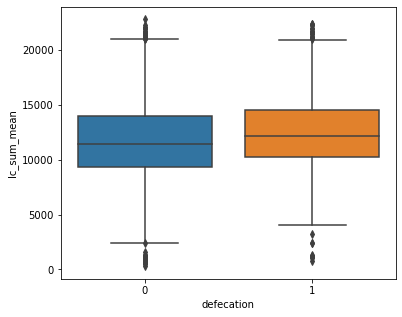

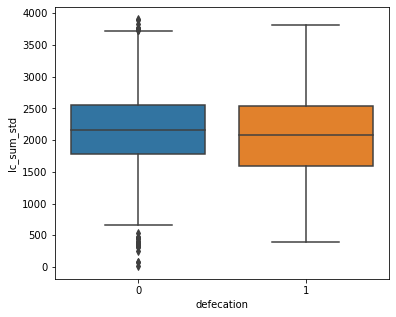

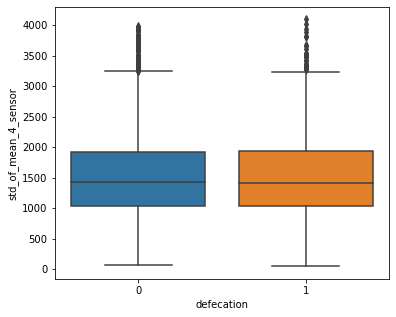

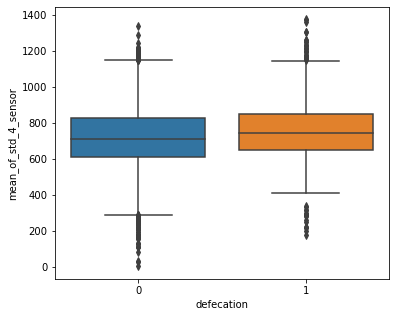

In [54]:
### Boxplot of Activity Time span
plt.figure(figsize=(6,5))
sns.boxplot(x = 'defecation',y ='lc_sum_mean',data = dataset[dataset['non_elimination']==0])


### Boxplot of Activity Time span when elimination was there
plt.figure(figsize=(6,5))
sns.boxplot(x = 'defecation',y ='lc_sum_std', data = dataset[dataset['non_elimination']==0])


### Boxplot of Activity Time span 'lc_total_mean','lc_total_std', 'std_of_mean_4_sensor','mean_of_std_4_sensor'
plt.figure(figsize=(6,5))
sns.boxplot(x = 'defecation',y ='std_of_mean_4_sensor',data = dataset[dataset['non_elimination']==0])


### Boxplot of Activity Time span when elimination was there
plt.figure(figsize=(6,5))
sns.boxplot(x = 'defecation',y ='mean_of_std_4_sensor', data = dataset[dataset['non_elimination']==0])

<AxesSubplot:xlabel='urination', ylabel='lc_sum_mean'>

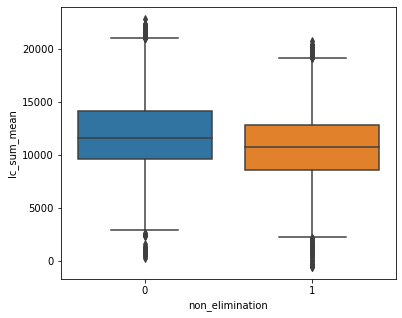

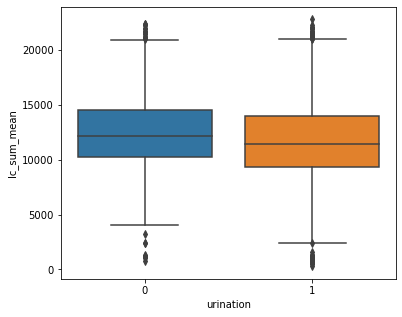

In [55]:
### Boxplot of Activity Time span
plt.figure(figsize=(6,5))
sns.boxplot(x = 'non_elimination',y ='lc_sum_mean',data = dataset)


### Boxplot of Activity Time span when elimination was there
plt.figure(figsize=(6,5))
sns.boxplot(x = 'urination',y ='lc_sum_mean', data = dataset[dataset['non_elimination'] == 0])

In [56]:
#important Activity chi square

activity_imp = dataset[['synapse_labeled','cat_on_edge', 'cat_rubbing_box', 'partial_cat_in_box', 
                'vomit','Act_jumped', 'Act_paws', 'Act_drift', 'Act_feet5mm',
                'Act_digging_cover']]

activity_target = dataset['non_elimination']

from sklearn.feature_selection import chi2
imp = chi2(activity_imp,activity_target)

imp_pvalue = pd.DataFrame(imp[1])
imp_pvalue.index = activity_imp.columns
imp_pvalue.sort_values(by = 0,ascending= True, inplace= True)

imp_pvalue.reset_index(inplace= True)
imp_pvalue = imp_pvalue.rename(columns={'index': 'Activity', 0: 'p_value'})
imp_pvalue

,Activity,p_value
0,Act_drift,7.769518e-20
1,cat_rubbing_box,7.286858e-11
2,Act_digging_cover,5.006966e-10
3,vomit,1.415266e-05
4,cat_on_edge,2.470266e-05
5,partial_cat_in_box,1.035731e-04
6,Act_jumped,5.895888e-03
7,Act_paws,1.298164e-02
8,Act_feet5mm,1.278497e-01
9,synapse_labeled,4.968950e-01


In [57]:
dataset.drop(columns= ['synapse_labeled', 'Act_feet5mm', 'Act_paws'],inplace= True)

### B) Activity non_elimination 

<AxesSubplot:>

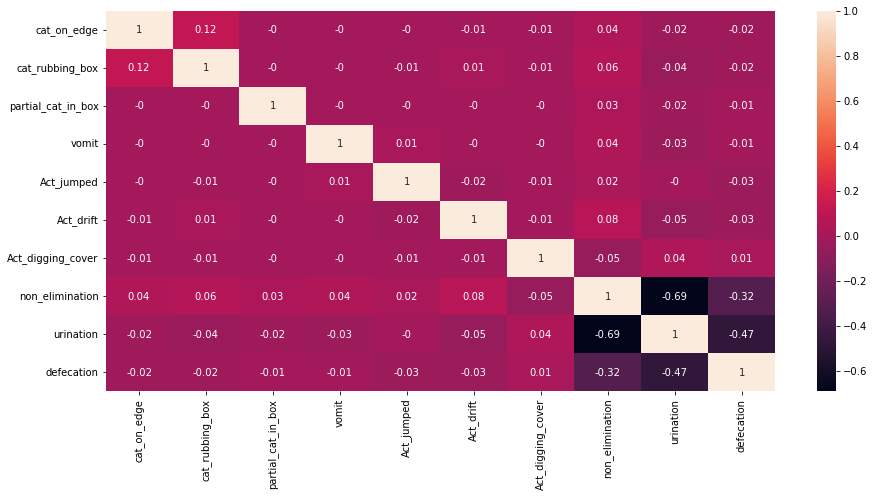

In [58]:
activity_imp = dataset[['cat_on_edge', 'cat_rubbing_box', 'partial_cat_in_box', 
                'vomit','Act_jumped', 'Act_drift', 'Act_digging_cover','non_elimination','urination','defecation']]

plt.figure(figsize=(15,7))
sns.heatmap(activity_imp.corr().round(2), annot= True)

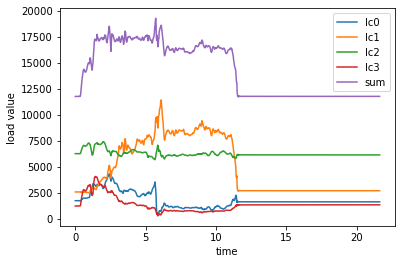

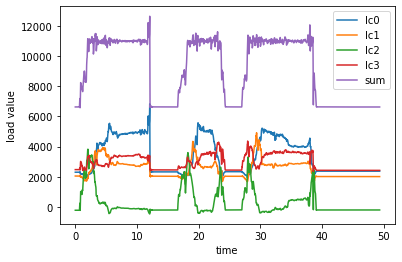

In [59]:
### Signal Graph of the load value 
non_elimination_Event_id_list = []
for i in range(0,len(dataset)):
    if dataset['non_elimination'][i] == 1:
        non_elimination_Event_id_list.append(dataset['Event_ID'][i])

a = random.sample(non_elimination_Event_id_list, 2)

a = [ "Raw_data/**/*" + i + ".csv" for i in a ]

for file_n  in a:
    read_file = glob.glob(file_n , recursive=True)
    Act = pd.concat((pd.read_csv(file).assign(filename=file)
          for file in read_file), ignore_index= True )
    Act.plot.line(y = ['lc0', 'lc1','lc2', 'lc3', 'sum'], x = 'timestamp' )
    plt.xlabel('time')
    plt.ylabel('load value')
    plt.show()

<AxesSubplot:xlabel='non_elimination', ylabel='time_span'>

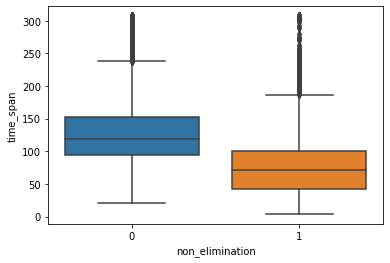

In [60]:
sns.boxplot(x = 'non_elimination' , y = 'time_span' ,data = dataset)

<AxesSubplot:xlabel='defecation', ylabel='time_span'>

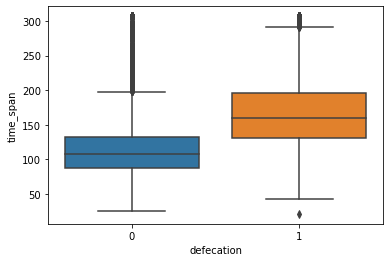

In [61]:
sns.boxplot(x = 'defecation' , y = 'time_span' ,data = dataset[dataset['non_elimination']==0])

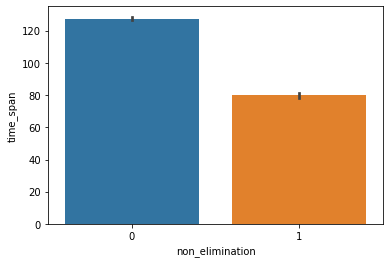

In [62]:
s1 = sns.barplot(x = 'non_elimination' , y = 'time_span',data = dataset)
plt.show()

<AxesSubplot:>

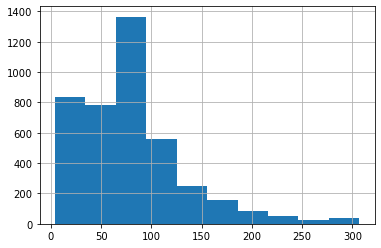

In [63]:
dataset[dataset['non_elimination'] == 1]['time_span'].hist()

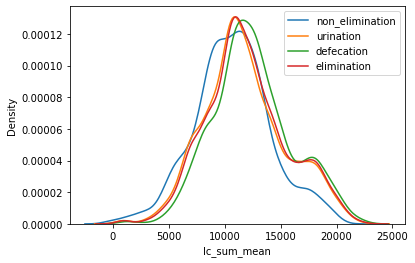

In [64]:
s1 = dataset[dataset['non_elimination']== 1]['lc_sum_mean']
s2 = dataset[dataset['urination']==1]['lc_sum_mean']
s3 = dataset[dataset['defecation']== 1]['lc_sum_mean']
s4 = dataset[dataset['non_elimination']== 0]['lc_sum_mean']
sns.kdeplot(s1, label = 'non_elimination')
sns.kdeplot(s2,label = 'urination')
sns.kdeplot(s3, label = 'defecation')
sns.kdeplot(s4, label = 'elimination')

plt.legend()
plt.show()

<AxesSubplot:xlabel='non_elimination', ylabel='log_e_entro__total_load'>

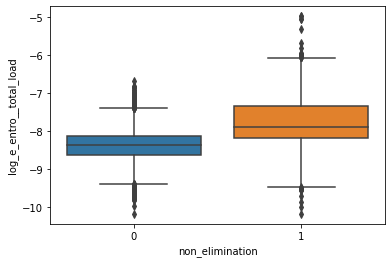

In [65]:
sns.boxplot(x = 'non_elimination' , y = 'log_e_entro__total_load' ,data = dataset)

<AxesSubplot:xlabel='non_elimination', ylabel='skew_total_load'>

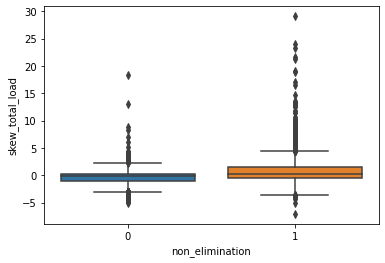

In [66]:
sns.boxplot(x = 'non_elimination' , y = 'skew_total_load' ,data = dataset)

## Statistical measure of load vs eliminatiom

<AxesSubplot:xlabel='non_elimination', ylabel='lc_max_4_sensor'>

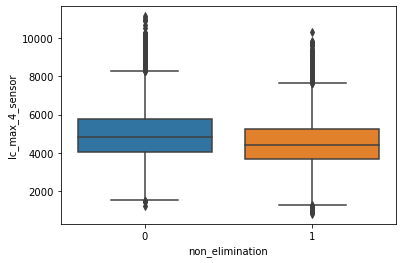

In [67]:
sns.boxplot(x = 'non_elimination' , y = 'lc_max_4_sensor' ,data = dataset)

<AxesSubplot:xlabel='non_elimination', ylabel='max_total_load'>

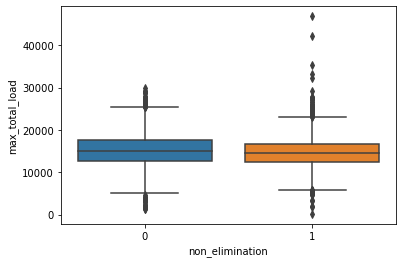

In [68]:
sns.boxplot(x = 'non_elimination' , y = 'max_total_load' ,data = dataset)

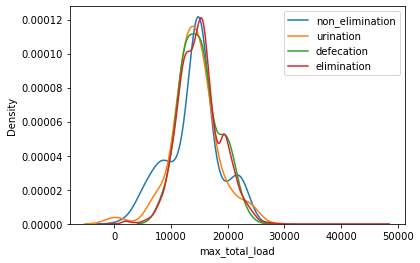

In [69]:
s1 = dataset[dataset['Act_drift']== 1]['max_total_load']
s2 = dataset[dataset['cat_rubbing_box']==1]['max_total_load']
s3 = dataset[dataset['cat_on_edge']== 1]['max_total_load']
s4 = dataset[dataset['Act_jumped']== 0]['max_total_load']
s3 = dataset[dataset['cat_on_edge']== 1]['max_total_load']
s4 = dataset[dataset['Act_jumped']== 0]['max_total_load']
sns.kdeplot(s1, label = 'non_elimination')
sns.kdeplot(s2,label = 'urination')
sns.kdeplot(s3, label = 'defecation')
sns.kdeplot(s4, label = 'elimination')

plt.legend()
plt.show()

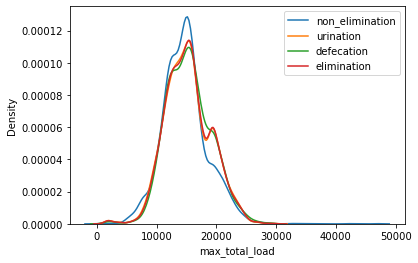

In [70]:
s1 = dataset[dataset['non_elimination']== 1]['max_total_load']
s2 = dataset[dataset['urination']==1]['max_total_load']
s3 = dataset[dataset['defecation']== 1]['max_total_load']
s4 = dataset[dataset['non_elimination']== 0]['max_total_load']
sns.kdeplot(s1, label = 'non_elimination')
sns.kdeplot(s2,label = 'urination')
sns.kdeplot(s3, label = 'defecation')
sns.kdeplot(s4, label = 'elimination')

plt.legend()
plt.show()

<AxesSubplot:xlabel='non_elimination', ylabel='max_total_load'>

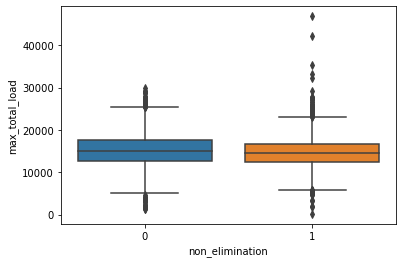

In [71]:
sns.boxplot(x = 'non_elimination' , y = 'max_total_load' ,data = dataset)

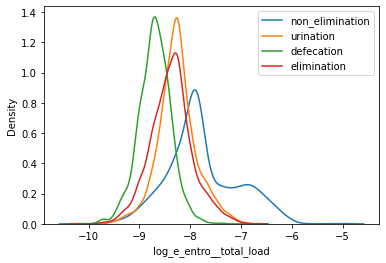

In [72]:
s1 = dataset[dataset['non_elimination']== 1]['log_e_entro__total_load']
s2 = dataset[dataset['urination']==1]['log_e_entro__total_load']
s3 = dataset[dataset['defecation']== 1]['log_e_entro__total_load']
s4 = dataset[dataset['non_elimination']== 0]['log_e_entro__total_load']
sns.kdeplot(s1, label = 'non_elimination')
sns.kdeplot(s2,label = 'urination')
sns.kdeplot(s3, label = 'defecation')
sns.kdeplot(s4, label = 'elimination')

plt.legend()
plt.show()

<AxesSubplot:xlabel='non_elimination', ylabel='log_e_entro__total_load'>

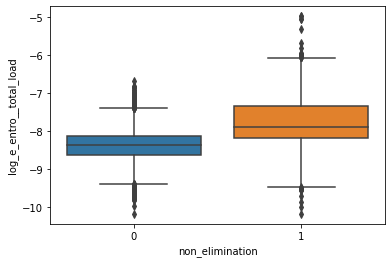

In [73]:
sns.boxplot(x = 'non_elimination' , y = 'log_e_entro__total_load' ,data = dataset)

<AxesSubplot:xlabel='urination', ylabel='log_e_entro__total_load'>

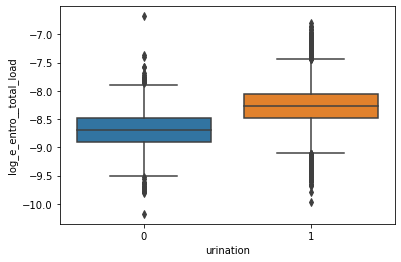

In [74]:
sns.boxplot(x = 'urination' , y = 'log_e_entro__total_load' ,data = dataset[dataset['non_elimination'] == 0])

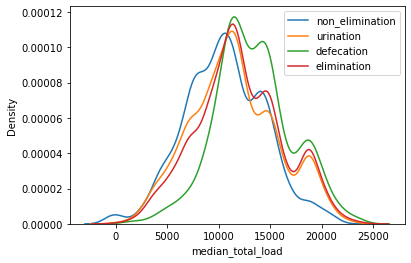

In [75]:
s1 = dataset[dataset['non_elimination']== 1]['median_total_load']
s2 = dataset[dataset['urination']==1]['median_total_load']
s3 = dataset[dataset['defecation']== 1]['median_total_load']
s4 = dataset[dataset['non_elimination']== 0]['median_total_load']
sns.kdeplot(s1, label = 'non_elimination')
sns.kdeplot(s2,label = 'urination')
sns.kdeplot(s3, label = 'defecation')
sns.kdeplot(s4, label = 'elimination')

plt.legend()
plt.show()

<AxesSubplot:xlabel='non_elimination', ylabel='median_total_load'>

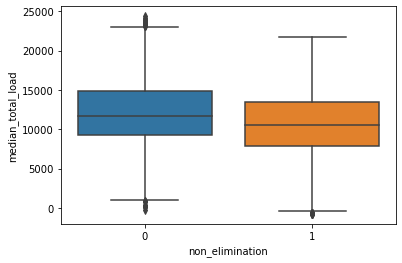

In [76]:
sns.boxplot(x = 'non_elimination' , y = 'median_total_load' ,data = dataset)

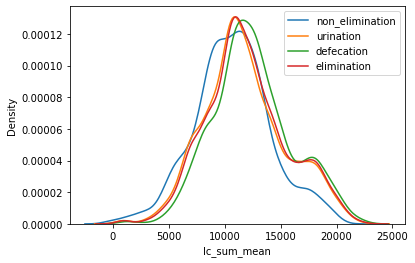

In [77]:
s1 = dataset[dataset['non_elimination']== 1]['lc_sum_mean']
s2 = dataset[dataset['urination']==1]['lc_sum_mean']
s3 = dataset[dataset['defecation']== 1]['lc_sum_mean']
s4 = dataset[dataset['non_elimination']== 0]['lc_sum_mean']
sns.kdeplot(s1, label = 'non_elimination')
sns.kdeplot(s2,label = 'urination')
sns.kdeplot(s3, label = 'defecation')
sns.kdeplot(s4, label = 'elimination')

plt.legend()
plt.show()

<AxesSubplot:xlabel='non_elimination', ylabel='lc_sum_mean'>

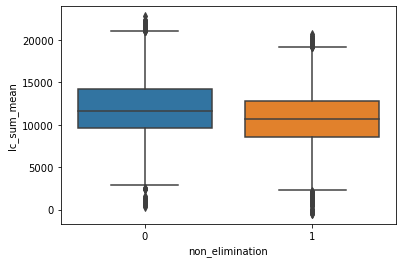

In [78]:
sns.boxplot(x = 'non_elimination' , y = 'lc_sum_mean' ,data = dataset)

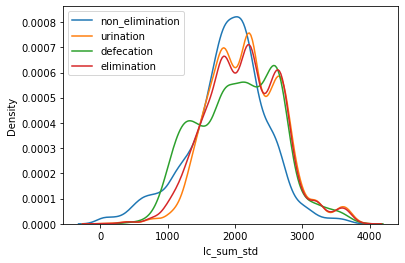

In [79]:
s1 = dataset[dataset['non_elimination']== 1]['lc_sum_std']
s2 = dataset[dataset['urination']==1]['lc_sum_std']
s3 = dataset[dataset['defecation']== 1]['lc_sum_std']
s4 = dataset[dataset['non_elimination']== 0]['lc_sum_std']
sns.kdeplot(s1, label = 'non_elimination')
sns.kdeplot(s2,label = 'urination')
sns.kdeplot(s3, label = 'defecation')
sns.kdeplot(s4, label = 'elimination')

plt.legend()
plt.show()

<AxesSubplot:xlabel='non_elimination', ylabel='lc_sum_std'>

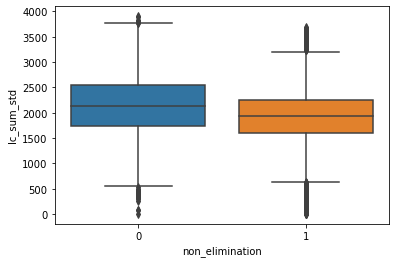

In [80]:
sns.boxplot(x = 'non_elimination' , y = 'lc_sum_std' ,data = dataset)

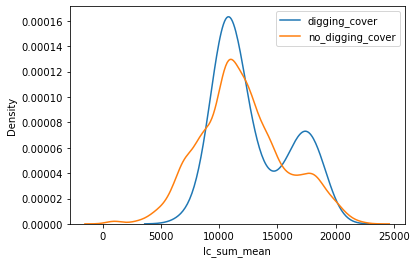

In [81]:
a = dataset[dataset['non_elimination']== 0]
s1 = a[a['Act_digging_cover']== 1]['lc_sum_mean']
s2 = a[a['Act_digging_cover']==0]['lc_sum_mean']
sns.kdeplot(s1, label = 'digging_cover')
sns.kdeplot(s2,label = 'no_digging_cover')

plt.legend()
plt.show()

<AxesSubplot:xlabel='non_elimination', ylabel='log_e_entro__total_load'>

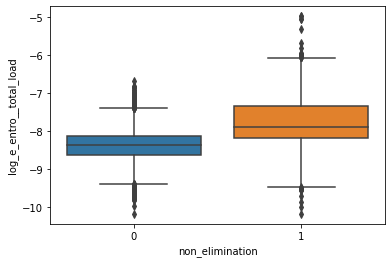

In [82]:
sns.boxplot(x = 'non_elimination' , y = 'log_e_entro__total_load' ,data = dataset)

### Activity 1) Raw signal vs Activity Drift

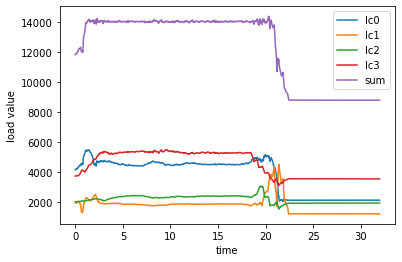

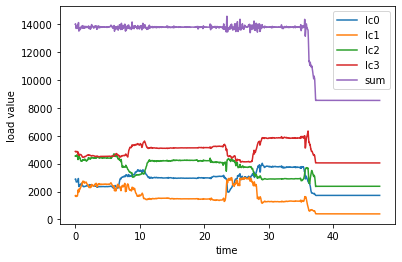

In [83]:
### Signal Graph of the load value 
drift_Event_id_list = []
for i in range(0,len(dataset)):
    if dataset['Act_drift'][i] == 1:
        drift_Event_id_list.append(dataset['Event_ID'][i])

a = random.sample(drift_Event_id_list, 2)

a = [ "Raw_data/**/*" + i + ".csv" for i in a ]

for file_n  in a:
    read_file = glob.glob(file_n , recursive=True)
    Act = pd.concat((pd.read_csv(file).assign(filename=file)
          for file in read_file), ignore_index= True )
    Act.plot.line(y = ['lc0', 'lc1','lc2', 'lc3', 'sum'], x = 'timestamp' )
    plt.xlabel('time')
    plt.ylabel('load value')
    plt.show()

#### Observation with drift activity is that load sensor are change/dropat last 10 second only

<AxesSubplot:xlabel='time_span'>

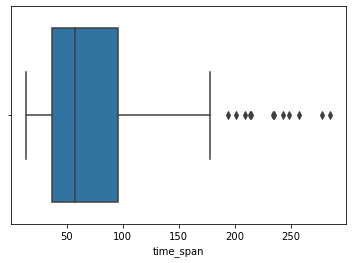

In [84]:
sns.boxplot(dataset[dataset['Act_drift'] == 1]['time_span'])

<AxesSubplot:xlabel='Act_drift', ylabel='non_elimination'>

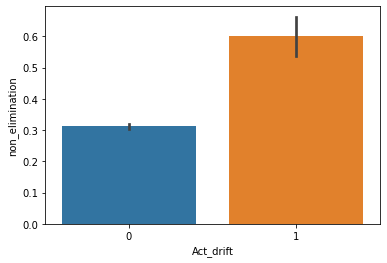

In [85]:
sns.barplot(x = 'Act_drift' , y = 'non_elimination', data = dataset)

<AxesSubplot:xlabel='Act_drift', ylabel='urination'>

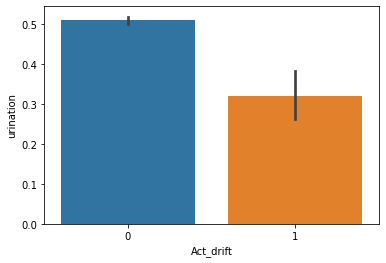

In [86]:
sns.barplot(x = 'Act_drift' , y = 'urination', data = dataset)

### Activity 2) Raw signal vs cat_rubbing_box

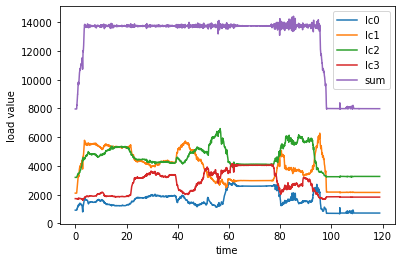

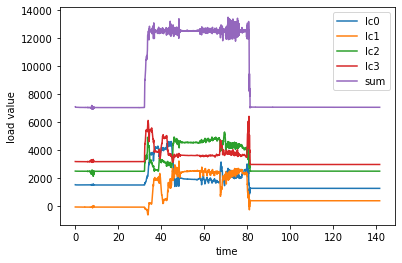

In [87]:
### Signal Graph of the load value 
catrub_Event_id_list = []
for i in range(0,len(dataset)):
    if dataset['cat_rubbing_box'][i] == 1:
        catrub_Event_id_list.append(dataset['Event_ID'][i])

a = random.sample(catrub_Event_id_list, 2)

a = [ "Raw_data/**/*" + i + ".csv" for i in a ]

for file_n  in a:
    read_file = glob.glob(file_n , recursive=True)
    Act = pd.concat((pd.read_csv(file).assign(filename=file)
          for file in read_file), ignore_index= True )
    Act.plot.line(y = ['lc0', 'lc1','lc2', 'lc3', 'sum'], x = 'timestamp' )
    plt.xlabel('time')
    plt.ylabel('load value')
    plt.show()

<AxesSubplot:xlabel='time_span'>

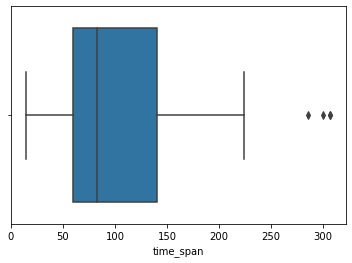

In [88]:
sns.boxplot(dataset[dataset['cat_rubbing_box'] == 1]['time_span'])

<AxesSubplot:xlabel='cat_rubbing_box', ylabel='non_elimination'>

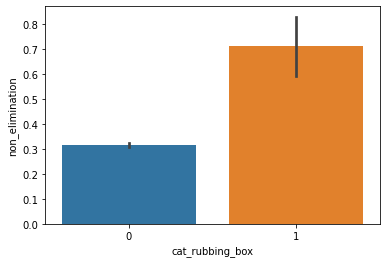

In [89]:
sns.barplot(x = 'cat_rubbing_box' , y = 'non_elimination', data = dataset)

#### Observation : starting load value and end load values are same and start after 15 second

### Activity 3) Raw signal vs Act_digging_cover 

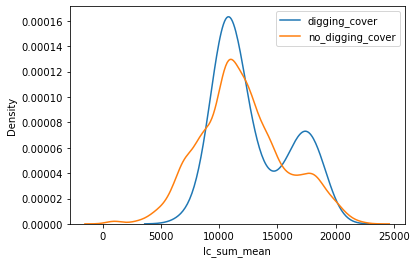

In [90]:
a = dataset[dataset['non_elimination']== 0]
s1 = a[a['Act_digging_cover']== 1]['lc_sum_mean']
s2 = a[a['Act_digging_cover']==0]['lc_sum_mean']
sns.kdeplot(s1, label = 'digging_cover')
sns.kdeplot(s2,label = 'no_digging_cover')

plt.legend()
plt.show()

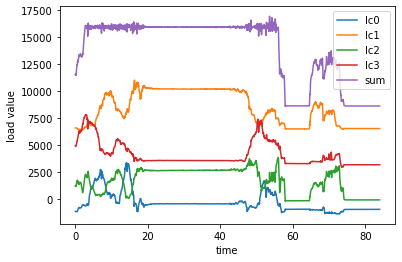

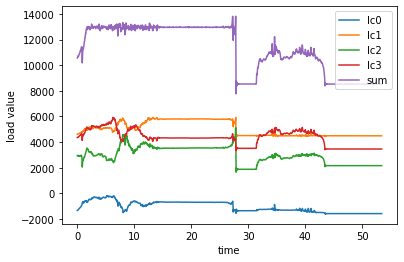

In [91]:
### Signal Graph of the load value 
digg_Event_id_list = []
for i in range(0,len(dataset)):
    if dataset['Act_digging_cover'][i] == 1:
        digg_Event_id_list.append(dataset['Event_ID'][i])

a = random.sample(digg_Event_id_list, 2)

a = [ "Raw_data/**/*" + i + ".csv" for i in a ]

for file_n  in a:
    read_file = glob.glob(file_n , recursive=True)
    Act = pd.concat((pd.read_csv(file).assign(filename=file)
          for file in read_file), ignore_index= True )
    Act.plot.line(y = ['lc0', 'lc1','lc2', 'lc3', 'sum'], x = 'timestamp' )
    plt.xlabel('time')
    plt.ylabel('load value')
    plt.show()

<AxesSubplot:xlabel='time_span'>

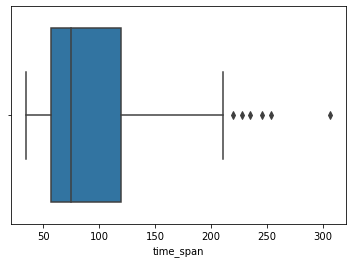

In [92]:
sns.boxplot(dataset[dataset['Act_digging_cover'] == 1]['time_span'])

<AxesSubplot:xlabel='Act_digging_cover', ylabel='non_elimination'>

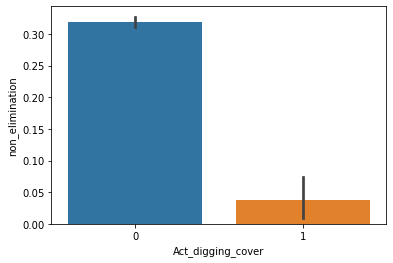

In [93]:
sns.barplot(x = 'Act_digging_cover' , y = 'non_elimination', data = dataset)

#### Observation:  before 10 sec of end  load fluctuate for 10-20 second 

<AxesSubplot:xlabel='urination', ylabel='Act_digging_cover'>

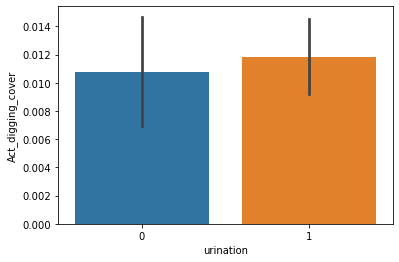

In [94]:
a = dataset[dataset['non_elimination']== 0]
sns.barplot(x = 'urination' , y = 'Act_digging_cover', data = a)

### Activity 4) Raw signal vs vomit

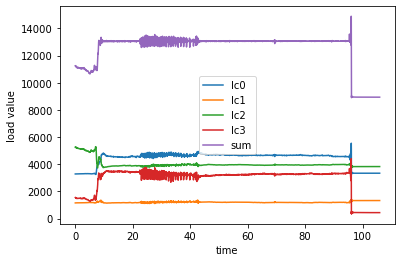

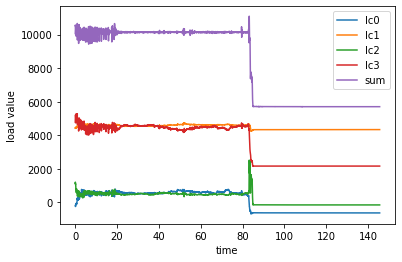

In [95]:
### Signal Graph of the load value 
vomit_Event_id_list = []
for i in range(0,len(dataset)):
    if dataset['vomit'][i] == 1:
        vomit_Event_id_list.append(dataset['Event_ID'][i])

a = random.sample(vomit_Event_id_list, 2)

a = [ "Raw_data/**/*" + i + ".csv" for i in a ]

for file_n  in a:
    read_file = glob.glob(file_n , recursive=True)
    Act = pd.concat((pd.read_csv(file).assign(filename=file)
          for file in read_file), ignore_index= True )
    Act.plot.line(y = ['lc0', 'lc1','lc2', 'lc3', 'sum'], x = 'timestamp' )
    plt.xlabel('time')
    plt.ylabel('load value')
    plt.show()

<AxesSubplot:xlabel='time_span'>

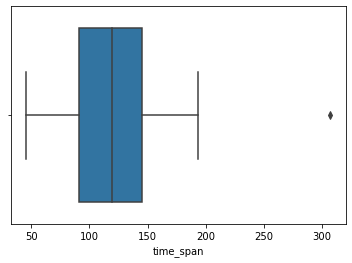

In [96]:
sns.boxplot(dataset[dataset['vomit'] == 1]['time_span'])

<AxesSubplot:xlabel='vomit', ylabel='non_elimination'>

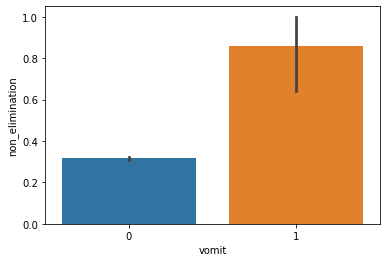

In [97]:
sns.barplot(x = 'vomit' , y = 'non_elimination', data = dataset)

#### Observation: There is no pattern in activity and load sensor values

### Activity 5) Raw signal vs cat_on_edge

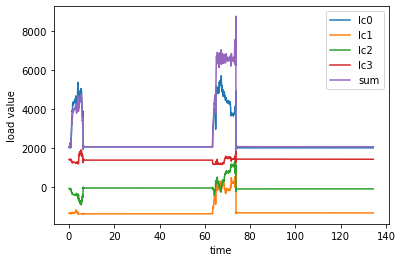

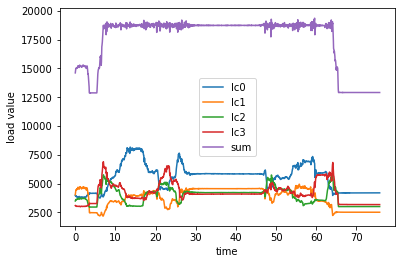

In [98]:
### Signal Graph of the load value 
cat_on_edge_Event_id_list = []
for i in range(0,len(dataset)):
    if dataset['cat_on_edge'][i] == 1:
        cat_on_edge_Event_id_list.append(dataset['Event_ID'][i])

a = random.sample(cat_on_edge_Event_id_list, 2)

a = [ "Raw_data/**/*" + i + ".csv" for i in a ]

for file_n  in a:
    read_file = glob.glob(file_n , recursive=True)
    Act = pd.concat((pd.read_csv(file).assign(filename=file)
          for file in read_file), ignore_index= True )
    Act.plot.line(y = ['lc0', 'lc1','lc2', 'lc3', 'sum'], x = 'timestamp' )
    plt.xlabel('time')
    plt.ylabel('load value')
    plt.show()

<AxesSubplot:xlabel='time_span'>

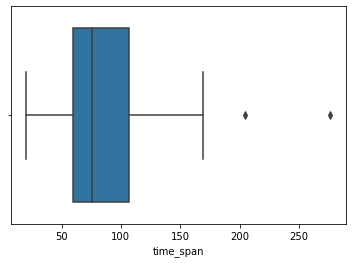

In [99]:
sns.boxplot(dataset[dataset['cat_on_edge'] == 1]['time_span'])

<AxesSubplot:xlabel='cat_on_edge', ylabel='non_elimination'>

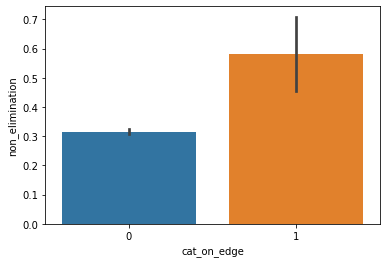

In [100]:
sns.barplot(x = 'cat_on_edge' , y = 'non_elimination', data = dataset)

<AxesSubplot:xlabel='non_elimination', ylabel='cat_on_edge'>

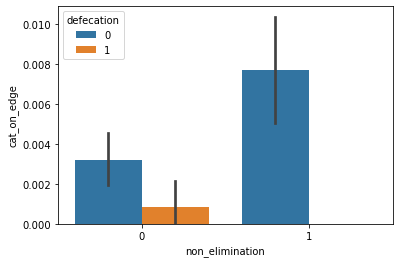

In [101]:
sns.barplot(x = 'non_elimination' , y = 'cat_on_edge', data = dataset, hue= 'defecation')

#### Observation: There is no pattern in activity and load sensor values

### Activity 6) Raw signal vs Jumped

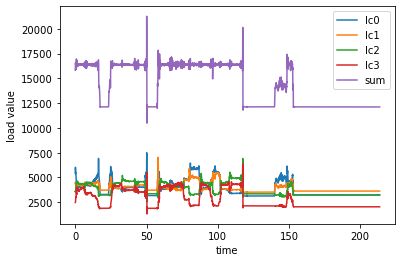

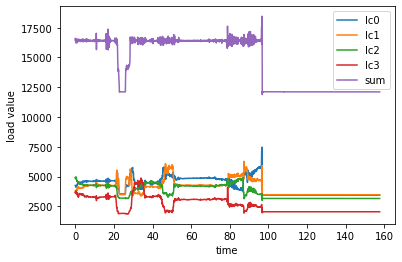

In [102]:
### Signal Graph of the load value 
Act_jumped_Event_id_list = []
for i in range(0,len(dataset)):
    if dataset['Act_jumped'][i] == 1:
        Act_jumped_Event_id_list.append(dataset['Event_ID'][i])

a = random.sample(Act_jumped_Event_id_list, 2)

a = [ "Raw_data/**/*" + i + ".csv" for i in a ]

for file_n  in a:
    read_file = glob.glob(file_n , recursive=True)
    Act = pd.concat((pd.read_csv(file).assign(filename=file)
          for file in read_file), ignore_index= True )
    Act.plot.line(y = ['lc0', 'lc1','lc2', 'lc3', 'sum'], x = 'timestamp' )
    plt.xlabel('time')
    plt.ylabel('load value')
    plt.show()

<AxesSubplot:xlabel='time_span'>

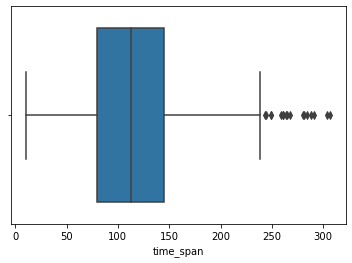

In [103]:
sns.boxplot(dataset[dataset['Act_jumped'] == 1]['time_span'])

<AxesSubplot:xlabel='Act_jumped', ylabel='non_elimination'>

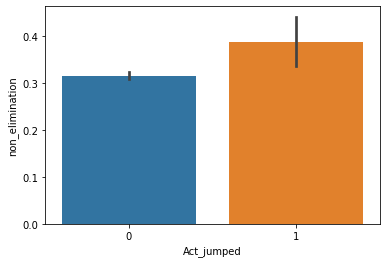

In [104]:
sns.barplot(x = 'Act_jumped' , y = 'non_elimination', data = dataset)

<AxesSubplot:xlabel='non_elimination', ylabel='Act_jumped'>

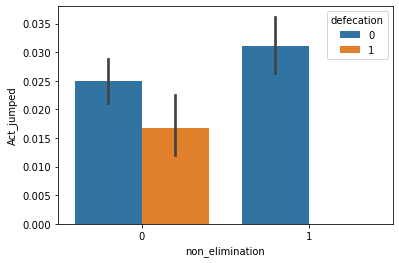

In [105]:
sns.barplot(x = 'non_elimination' , y = 'Act_jumped', data = dataset, hue= 'defecation')

#### Observation: There is huge up and down in load sensor

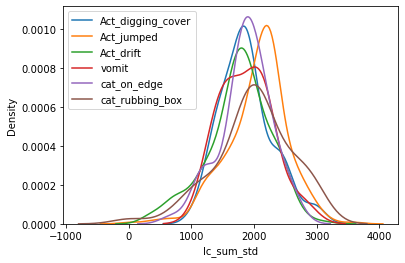

In [106]:
s1 = dataset[dataset['Act_digging_cover']== 1]['lc_sum_std']
s2 = dataset[dataset['Act_jumped']==1]['lc_sum_std']
s3 = dataset[dataset['Act_drift']== 1]['lc_sum_std']
s4 = dataset[dataset['vomit']== 1]['lc_sum_std']
s5 = dataset[dataset['cat_on_edge']== 1]['lc_sum_std']
s6 = dataset[dataset['cat_rubbing_box']== 1]['lc_sum_std']
sns.kdeplot(s1, label = 'Act_digging_cover')
sns.kdeplot(s2,label = 'Act_jumped')
sns.kdeplot(s3, label = 'Act_drift')
sns.kdeplot(s4, label = 'vomit')
sns.kdeplot(s5, label = 'cat_on_edge')
sns.kdeplot(s6, label = 'cat_rubbing_box')
plt.legend()
plt.show()

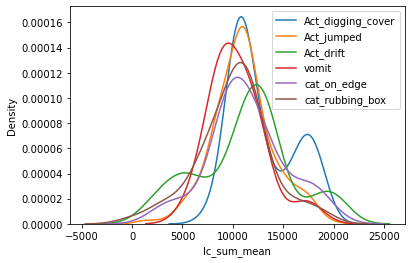

In [107]:
s1 = dataset[dataset['Act_digging_cover']== 1]['lc_sum_mean']
s2 = dataset[dataset['Act_jumped']==1]['lc_sum_mean']
s3 = dataset[dataset['Act_drift']== 1]['lc_sum_mean']
s4 = dataset[dataset['vomit']== 1]['lc_sum_mean']
s5 = dataset[dataset['cat_on_edge']== 1]['lc_sum_mean']
s6 = dataset[dataset['cat_rubbing_box']== 1]['lc_sum_mean']
sns.kdeplot(s1, label = 'Act_digging_cover')
sns.kdeplot(s2,label = 'Act_jumped')
sns.kdeplot(s3, label = 'Act_drift')
sns.kdeplot(s4, label = 'vomit')
sns.kdeplot(s5, label = 'cat_on_edge')
sns.kdeplot(s6, label = 'cat_rubbing_box')
plt.legend()
plt.show()

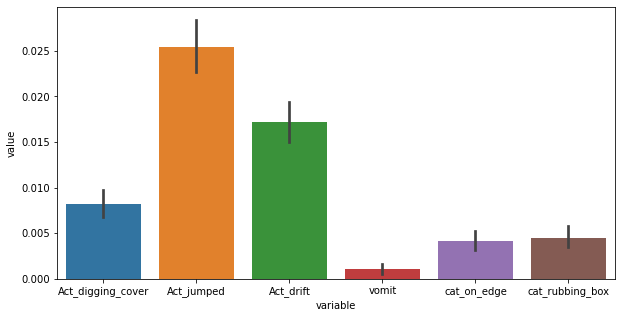

In [108]:
plt.figure(figsize=(10,5))
df1 = pd.DataFrame(data = dataset, columns = ['Act_digging_cover', 'Act_jumped', 'Act_drift', 'vomit',
       'cat_on_edge', 'cat_rubbing_box'])
sns.barplot(x="variable", y="value", data=pd.melt(df1))

plt.show()

In [109]:
#important Activity chi square on urination and deflamation

activity_imp = dataset[['cat_on_edge', 'cat_rubbing_box', 'partial_cat_in_box', 
                'vomit','Act_jumped',  'Act_drift', 'Act_digging_cover']]

activity_imp = activity_imp[dataset['non_elimination'] == 0]

activity_target = dataset[dataset['non_elimination'] == 0 ]['defecation']

from sklearn.feature_selection import chi2
imp = chi2(activity_imp,activity_target)

imp_pvalue = pd.DataFrame(imp[1])
imp_pvalue.index = activity_imp.columns
imp_pvalue.sort_values(by = 0,ascending= True, inplace= True)

imp_pvalue.reset_index(inplace= True)
imp_pvalue = imp_pvalue.rename(columns={'index': 'Activity', 0: 'p_value'})
imp_pvalue

,Activity,p_value
0,Act_jumped,0.026071
1,cat_on_edge,0.059106
2,Act_drift,0.198091
3,vomit,0.437733
4,Act_digging_cover,0.698185
5,cat_rubbing_box,0.820135
6,partial_cat_in_box,NaN


<AxesSubplot:xlabel='Act_digging_cover', ylabel='time_span'>

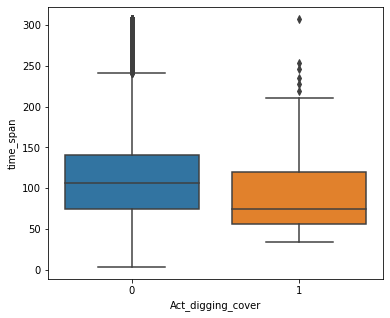

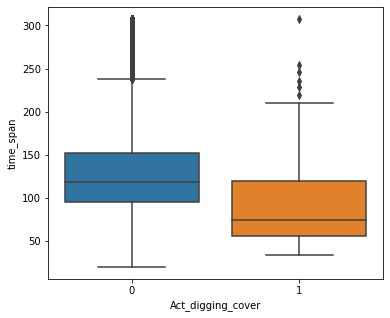

In [110]:
#Boxplot of Activity and urination or deplamation

plt.figure(figsize=(6,5))
sns.boxplot(x = 'Act_digging_cover',y ='time_span',data = dataset)


#Boxplot of Activity and urination or deplamation

plt.figure(figsize=(6,5))
sns.boxplot(x = 'Act_digging_cover',y ='time_span',data = dataset[dataset['non_elimination'] ==  0])

<AxesSubplot:xlabel='time_span', ylabel='lc_sum_mean'>

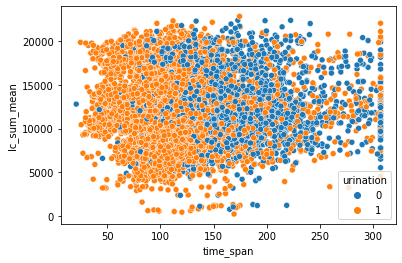

In [111]:
#for low time span non_elimination was there
# for more time_span there will be deflamation

sns.scatterplot(x = 'time_span' , y = 'lc_sum_mean' , data = dataset[dataset['non_elimination'] == 0], hue= 'urination')

### B) Activity: Sensor reading 

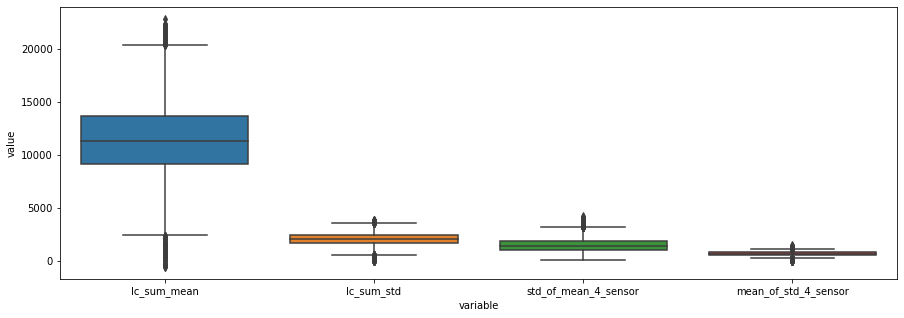

In [112]:
plt.figure(figsize=(15,5))
df1 = pd.DataFrame(data = dataset, columns = ['lc_sum_mean','lc_sum_std', 'std_of_mean_4_sensor',
       'mean_of_std_4_sensor', ])
sns.boxplot(x="variable", y="value", data=pd.melt(df1))

plt.show()

### G) Feature Engineering

#### a) Cat weight

<AxesSubplot:xlabel='non_elimination', ylabel='Weight_of_cat'>

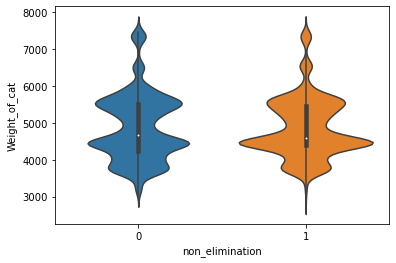

In [113]:
#Data Transformation
sns.violinplot(x = 'non_elimination',y ='Weight_of_cat',data = dataset)

<AxesSubplot:xlabel='non_elimination', ylabel='Weight_of_cat'>

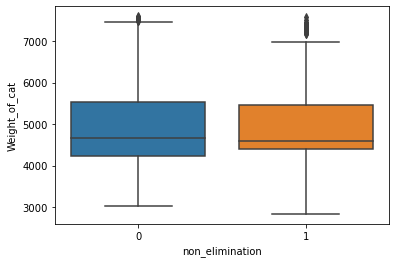

In [114]:
sns.boxplot(x = 'non_elimination',y ='Weight_of_cat',data = dataset)

In [115]:
dataset[dataset['Weight_of_cat'] < 3400]['Name_of_cat'].unique()

array(['Marlowe', 'Meera'], dtype=object)

In [116]:
dataset[dataset['Weight_of_cat'] > 6100]['Name_of_cat'].unique()

array(['Ryan', 'Lexi', 'Zeb', 'Simon'], dtype=object)

In [117]:
dataset[dataset['Name_of_cat'] == 'Meera']['Weight_of_cat'].describe()

count     129.000000
mean     3690.279070
std       152.656374
min      2833.000000
25%      3709.000000
50%      3722.000000
75%      3745.000000
max      3835.000000
Name: Weight_of_cat, dtype: float64

In [118]:
bins = [0, 3400 ,6000, 9000]
abcd = ['less_weight', 'good', 'more_weight']
dataset['Weight_bins'] = pd.cut(dataset['Weight_of_cat'] ,bins , labels = abcd )

<AxesSubplot:xlabel='non_elimination', ylabel='Weight_of_cat'>

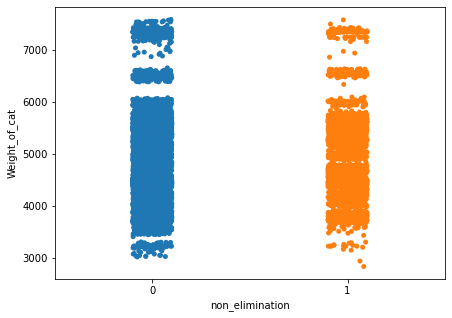

In [119]:
plt.figure(figsize=(7,5))
sns.stripplot(x = 'non_elimination',y = 'Weight_of_cat', data= dataset)

<AxesSubplot:xlabel='Weight_bins', ylabel='non_elimination'>

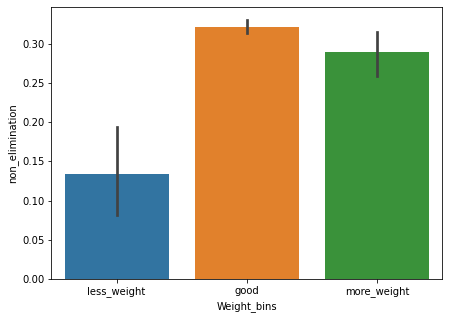

In [120]:
plt.figure(figsize=(7,5))
sns.barplot(x = 'Weight_bins',y = 'non_elimination', data= dataset)

<AxesSubplot:xlabel='Weight_bins', ylabel='urination'>

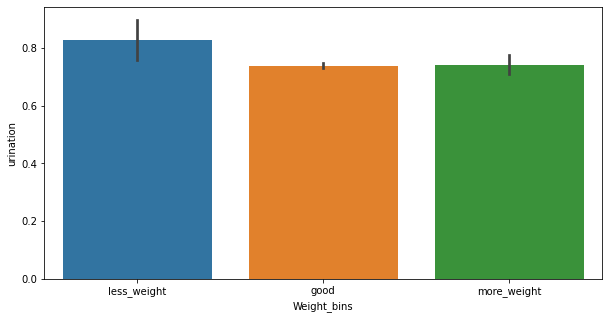

In [121]:
plt.figure(figsize=(10,5))
sns.barplot(x = 'Weight_bins',y = 'urination', data= dataset[dataset['non_elimination']==0])

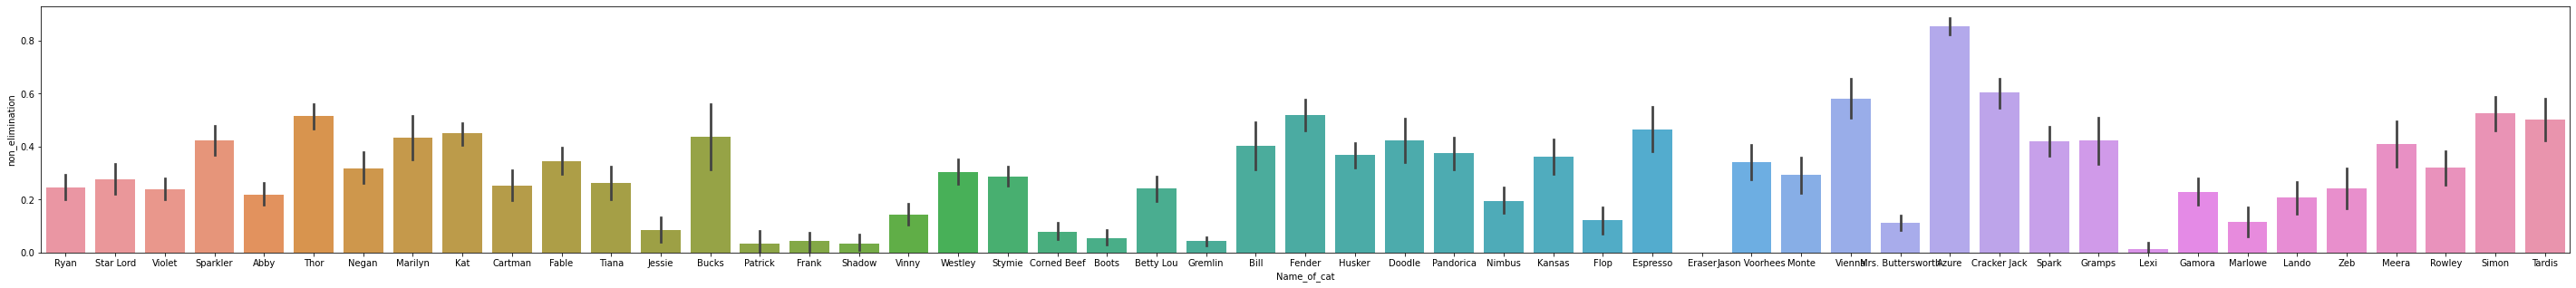

In [122]:
plt.figure(figsize=(50,5))
sns.barplot(x = 'Name_of_cat',y = 'non_elimination', data= dataset)
plt.savefig('Cat breed')

In [123]:
bins = [0, 3400 ,6000, 9000]
abcd = ['less_weight', 'good', 'more_weight']
dataset['Weight_bins'] = pd.cut(dataset['Weight_of_cat'] ,bins , labels = abcd )

<AxesSubplot:xlabel='hour', ylabel='non_elimination'>

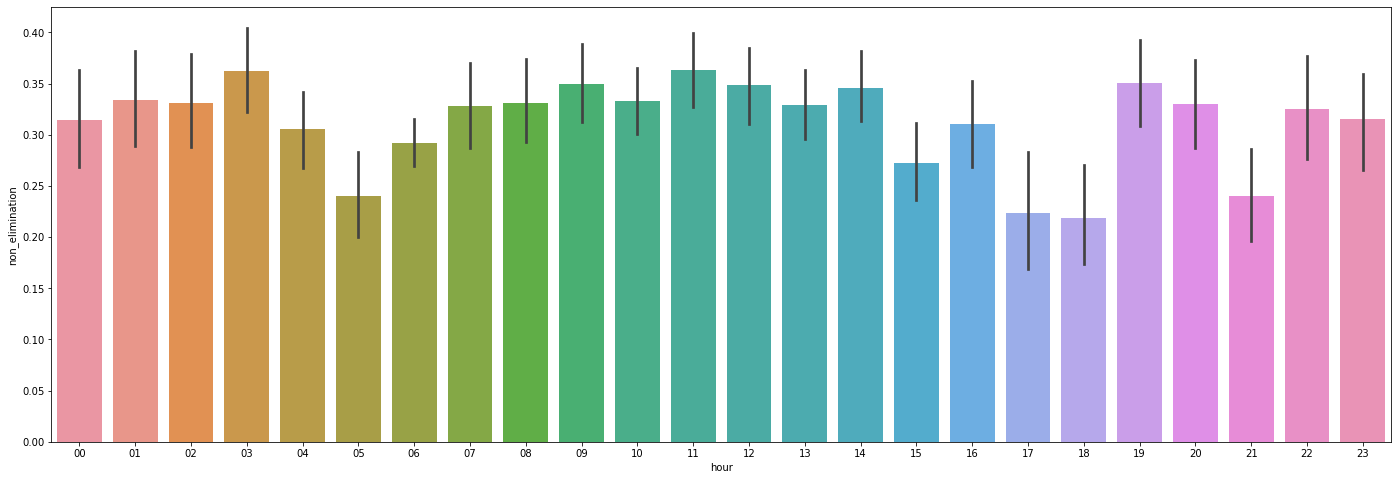

In [124]:
#Boxplot of cat_Weight

plt.figure(figsize=(24,8))
sns.barplot(x = 'hour',y = 'non_elimination', data= dataset, order= ['00','01','02','03' ,'04', '05' , '06', '07', '08', '09', '10' , '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'])

In [125]:
### 22-4 -late Night 
### 7-16, Day time
### 5,6 -Early morning, 17-18 evening
### 19-20 night
### 21 After dinner

In [126]:
Time_day_Late_Night = ['00','01','02','03' ,'04', '19', '20','22', '23', '07', '08', '09', '10' , '11', '12', '13', '14', '15', '16']
Time_Early_morning_envening = ['05','06','17', '18']
Time_Night_9 = [ '21' ]

def condition(x):
    if x in  Time_day_Late_Night:
        return 'Time_day_Night'
    elif x in  Time_Early_morning_envening:
        return 'Time_Early_morning_envening'
    elif x in  Time_Night_9:
        return 'Time_Night_9'
    
dataset['Time_bin'] = dataset['hour'].apply(condition)

<AxesSubplot:xlabel='Time_bin', ylabel='non_elimination'>

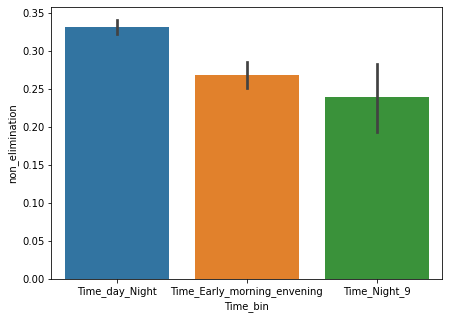

In [127]:
plt.figure(figsize=(7,5))
sns.barplot(x = 'Time_bin',y = 'non_elimination', data= dataset)

<AxesSubplot:xlabel='EVENT_MONTH', ylabel='non_elimination'>

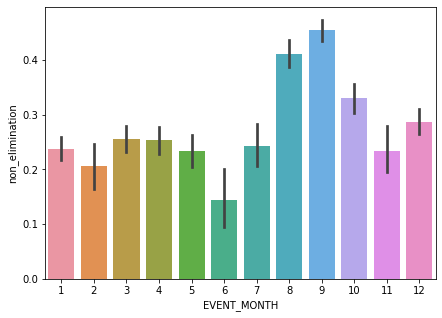

In [128]:
#Boxplot of cat_Weight

plt.figure(figsize=(7,5))
sns.barplot(x = 'EVENT_MONTH',y = 'non_elimination', data= dataset, order= [1,2,3,4,5,6,7,8,9,10,11,12])

In [129]:
Month_Nov_July = [1,2,3,4,5,6,7,11,12]
Month_Aug_Oct = [8,9,10,]

def condition(x):
    if x in  Month_Nov_July:
        return 'Month_Nov_July'
    elif x in  Month_Aug_Oct:
        return 'Month_Aug_Oct'
    
dataset['Month_bin'] = dataset['EVENT_MONTH'].apply(condition)

<AxesSubplot:xlabel='Month_bin', ylabel='non_elimination'>

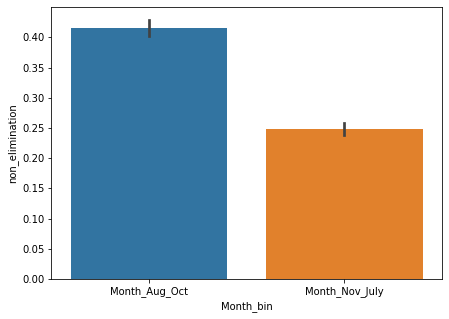

In [130]:
#Boxplot of cat_Weight

plt.figure(figsize=(7,5))
sns.barplot(x = 'Month_bin',y = 'non_elimination', data= dataset)

### H) Hypothesis testing

In [131]:
# sample independant t test
s1 = dataset[dataset['Act_digging_cover']==1]['power_by_cat']
s2 = dataset[dataset['Act_jumped']==1]['power_by_cat']
stats.ttest_ind(s1,s2)

Ttest_indResult(statistic=-0.43475202129183355, pvalue=0.6639565477020595)

In [132]:
# pval = 0.66
# sig lvl= 0.05
# pval> sig lvl
# H0 is selected
# Avg power of cat during Act_digging_cover is equal power of cat during Act_jumped
# There is no significant difference

In [133]:
## 1) Is urination has related on elimination of cat


Act_digging_cover = dataset['Act_digging_cover']
non_elimination = dataset['non_elimination'] 

tab = pd.crosstab(non_elimination, Act_digging_cover)
tab

Act_digging_cover,0,1
non_elimination,,
0,8823,103
1,4142,4


In [134]:
stats.chi2_contingency(tab) # test of association

# pval= 0.0000
# pval < sig lvl
# Two categorical features are dependant (related)

(37.70206799733076,
 8.241714171644175e-10,
 1,
 array([[8852.93681151,   73.06318849],
        [4112.06318849,   33.93681151]]))

In [135]:
dataset['power_by_cat'] = (dataset['lc_sum_mean']*dataset['lc_sum_mean']*dataset['time_span'])/(dataset['Weight_of_cat']*1000)
dataset['power_by_cat'] = dataset['power_by_cat'].round(1)

dataset['std_total_power'] = (dataset['lc_sum_std']*dataset['lc_sum_std']*dataset['time_span'])/(dataset['Weight_of_cat']*1000)
dataset['std_total_power'] = dataset['std_total_power'].round(1)

dataset['std_sensor_power'] = (dataset['lc_sum_std']*dataset['lc_sum_std']*dataset['time_span'])/(dataset['Weight_of_cat']*1000)
dataset['std_sensor_power'] = dataset['std_sensor_power'].round(1)

dataset['mean_std_sensor_power'] = (dataset['mean_of_std_4_sensor']*dataset['mean_of_std_4_sensor']*dataset['time_span'])/(dataset['Weight_of_cat']*1000)
dataset['mean_std_sensor_power'] = dataset['mean_std_sensor_power'].round(1)

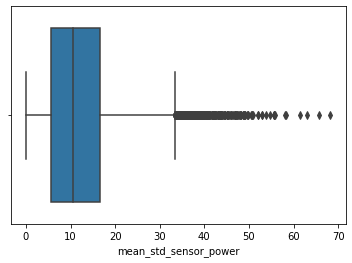

In [136]:
sns.boxplot(x = 'mean_std_sensor_power',data=dataset)
plt.show()

In [137]:
a  = dataset[dataset['power_by_cat'] < 10000]

In [138]:
from scipy.signal import welch
 
def get_psd_values(sig, T, N, f_s):
    t_n = sig['timestamp'][len(sig)-1]
    N = len(sig)
    T = t_n / N
    f_s = 1/T
    f_values, psd_values = welch(sig['sum'], fs=f_s)
    return f_values, psd_values

In [139]:
non_eli_Event_id_list = []
for i in range(0,len(dataset)):
    if dataset['non_elimination'][i] == 1:
        non_eli_Event_id_list.append(dataset['Event_ID'][i])
        
import random
a = random.sample(non_eli_Event_id_list, 2)
a = [ "Raw_data/**/*" + i + ".csv" for i in a ]

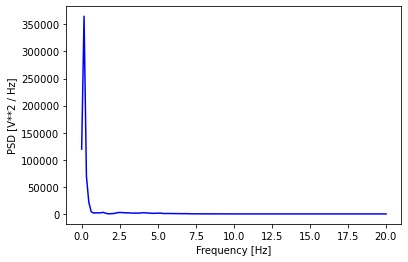

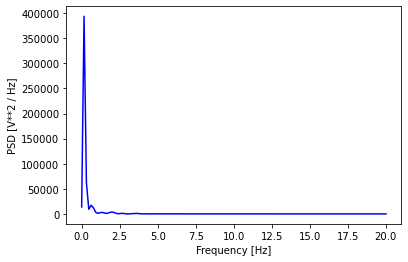

In [140]:
for file_n  in a:
    read_file = glob.glob(file_n , recursive=True)
    PSD = pd.concat((pd.read_csv(file).assign(filename=file)
          for file in read_file), ignore_index= True )
    f_values, psd_values = get_psd_values(PSD, 0, 0, 0) 
    plt.plot(f_values, psd_values, linestyle='-', color='blue')
    
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2 / Hz]')
    plt.show()

In [141]:
eli_Event_id_list = []
for i in range(0,len(dataset)):
    if dataset['non_elimination'][i] == 0:
        eli_Event_id_list.append(dataset['Event_ID'][i])
        
import random
a = random.sample(eli_Event_id_list, 2)
a = [ "Raw_data/**/*" + i + ".csv" for i in a ]

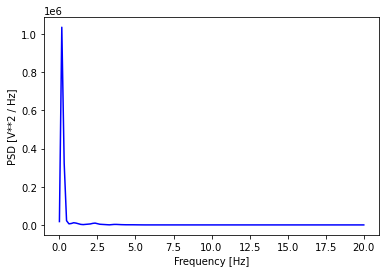

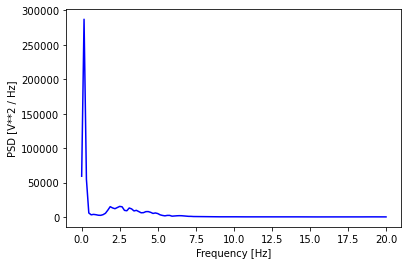

In [142]:
for file_n  in a:
    read_file = glob.glob(file_n , recursive=True)
    PSD = pd.concat((pd.read_csv(file).assign(filename=file)
          for file in read_file), ignore_index= True )
    f_values, psd_values = get_psd_values(PSD, 0, 0, 0) 
    plt.plot(f_values, psd_values, linestyle='-', color='blue')
    
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2 / Hz]')
    plt.show()

In [143]:
urination_Event_id_list = []
for i in range(0,len(dataset)):
    if dataset['urination'][i] == 1:
        urination_Event_id_list.append(dataset['Event_ID'][i])

a = random.sample(urination_Event_id_list, 2)
a = [ "Raw_data/**/*" + i + ".csv" for i in a ]

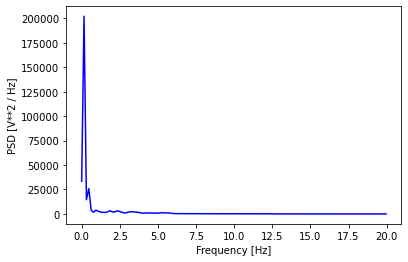

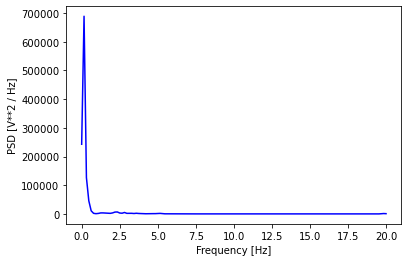

In [144]:
for file_n  in a:
    read_file = glob.glob(file_n , recursive=True)
    PSD = pd.concat((pd.read_csv(file).assign(filename=file)
          for file in read_file), ignore_index= True )
    f_values, psd_values = get_psd_values(PSD, 0, 0, 0) 
    plt.plot(f_values, psd_values, linestyle='-', color='blue')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2 / Hz]')
    plt.show()

In [145]:
defecation_Event_id_list = []
for i in range(0,len(dataset)):
    if dataset['defecation'][i] == 1:
        defecation_Event_id_list.append(dataset['Event_ID'][i])

a = random.sample(urination_Event_id_list, 2)
a = [ "Raw_data/**/*" + i + ".csv" for i in a ]

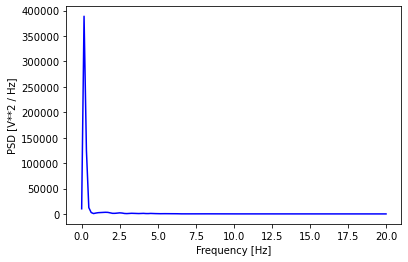

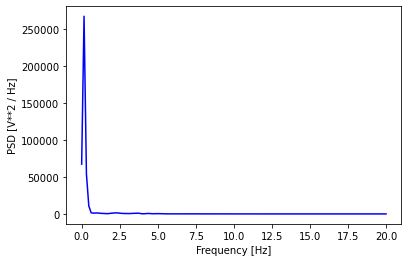

In [146]:
for file_n  in a:
    read_file = glob.glob(file_n , recursive=True)
    PSD = pd.concat((pd.read_csv(file).assign(filename=file)
          for file in read_file), ignore_index= True )
    f_values, psd_values = get_psd_values(PSD, 0, 0, 0) 
    plt.plot(f_values, psd_values, linestyle='-', color='blue')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2 / Hz]')
    plt.show()

<AxesSubplot:xlabel='urination', ylabel='PSDF_0_5Hz_max'>

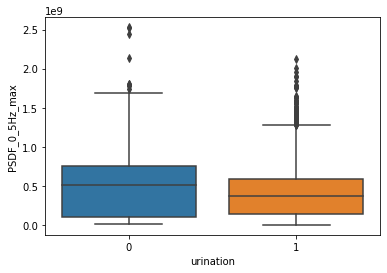

In [147]:
sns.boxplot(x = 'urination' , y = 'PSDF_0_5Hz_max' ,data = dataset[dataset['non_elimination'] == 0 ])

<AxesSubplot:xlabel='non_elimination', ylabel='PSDF_0_5Hz_mean'>

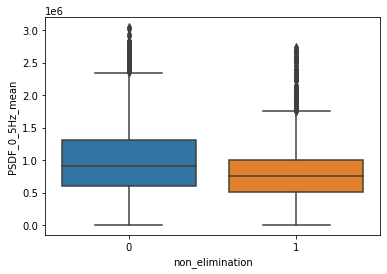

In [148]:
sns.boxplot(x = 'non_elimination', y = 'PSDF_0_5Hz_mean', data = dataset)

<AxesSubplot:xlabel='non_elimination', ylabel='PSDF_15_20Hz_max'>

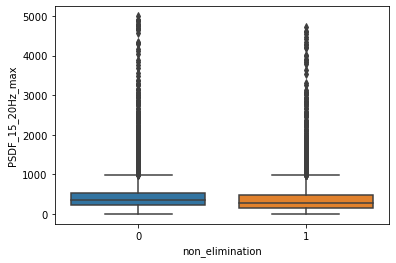

In [149]:
sns.boxplot(x = 'non_elimination', y = 'PSDF_15_20Hz_max', data = dataset[dataset['PSDF_15_20Hz_max']< 5000])

### F) Normalization of load sensor values

In [150]:
new_dataset = pd.DataFrame()
new_dataset = dataset[dataset.columns]

In [151]:
num_cols = df1.select_dtypes([np.number]).columns.to_list()
categorical_cols = set(df1.columns) - set(num_cols)

In [152]:
new_dataset[num_cols] =  scaling.fit_transform(new_dataset[num_cols])

In [153]:
new_dataset.columns

Index(['Device_ID', 'Event_ID', 'Name_of_cat', 'Weight_of_cat', 'lc_sum_mean',
       'lc_sum_std', 'time_span', 'min_total_load', 'max_total_load',
       'median_total_load', 'skew_total_load', 'kourtosis_total_load',
       'range_total_load', 'log_e_entro__total_load', 'lc_max_4_sensor',
       'lc_min_4_sensor', 'std_of_mean_4_sensor', 'max_of_std_4_sensor',
       'min_of_std_4_sensor', 'mean_of_std_4_sensor', 'std_of_std_4_sensor',
       'last_sum', 'PSDF_0_5Hz_max', 'PSDF_0_5Hz_min', 'PSDF_0_5Hz_median',
       'PSDF_0_5Hz_mean', 'PSDF_0_5Hz_std', 'PSDF_5_10Hz_max',
       'PSDF_5_10Hz_min', 'PSDF_5_10Hz_median', 'PSDF_5_10Hz_mean',
       'PSDF_5_10Hz_std', 'PSDF_10_15Hz_max', 'PSDF_10_15Hz_min',
       'PSDF_10_15Hz_median', 'PSDF_10_15Hz_mean', 'PSDF_10_15Hz_std',
       'PSDF_15_20Hz_max', 'PSDF_15_20Hz_min', 'PSDF_15_20Hz_median',
       'PSDF_15_20Hz_mean', 'PSDF_15_20Hz_std', 'power_by_cat',
       'non_elimination', 'urination', 'defecation', 'cat_on_edge',
       'cat

## Model_A for Elimination & Non-Elimination of cat

In [154]:
df1 = new_dataset[['lc_sum_mean',
       'lc_sum_std', 'time_span', 'min_total_load', 'max_total_load',
       'median_total_load', 'skew_total_load', 'kourtosis_total_load',
       'range_total_load', 'log_e_entro__total_load', 'lc_max_4_sensor',
       'lc_min_4_sensor', 'std_of_mean_4_sensor', 'max_of_std_4_sensor',
       'min_of_std_4_sensor', 'mean_of_std_4_sensor', 'std_of_std_4_sensor',
       'last_sum', 'PSDF_0_5Hz_max', 'PSDF_0_5Hz_min', 'PSDF_0_5Hz_median',
       'PSDF_0_5Hz_mean', 'PSDF_0_5Hz_std', 'PSDF_5_10Hz_max',
       'PSDF_5_10Hz_min', 'PSDF_5_10Hz_median', 'PSDF_5_10Hz_mean',
       'PSDF_5_10Hz_std', 'PSDF_10_15Hz_max', 'PSDF_10_15Hz_min',
       'PSDF_10_15Hz_median', 'PSDF_10_15Hz_mean', 'PSDF_10_15Hz_std',
       'PSDF_15_20Hz_max', 'PSDF_15_20Hz_min', 'PSDF_15_20Hz_median',
       'PSDF_15_20Hz_mean', 'PSDF_15_20Hz_std', 'power_by_cat',
       'non_elimination',  'Weight_bins', 'Time_bin', 'Month_bin', 'std_total_power',
       'std_sensor_power', 'mean_std_sensor_power']]

In [155]:
df1[num_cols].round(2)

,lc_sum_mean,lc_sum_std,std_of_mean_4_sensor,mean_of_std_4_sensor
0,0.46,0.76,0.55,0.53
1,0.45,0.88,0.73,0.70
2,0.50,0.66,0.35,0.47
3,0.45,0.61,0.16,0.41
4,0.41,0.87,0.21,0.66
...,...,...,...,...
13067,0.47,0.41,0.15,0.39
13068,0.38,0.36,0.26,0.28
13069,0.45,0.56,0.33,0.47
13070,0.47,0.25,0.33,0.34


In [156]:
### The following code tells us about the level of class imbalance in the dataset. While the dataset is balanced,
### a 32%-68% imbalance may give us acceptable results and we may not need sampling.

target_df = df1.non_elimination.value_counts().reset_index()
target_df['class_percentage'] = np.round(target_df.eval(f"non_elimination/{target_df.non_elimination.sum()}"), 2)
target_df.drop(columns = 'index')

,non_elimination,class_percentage
0,8926,0.68
1,4146,0.32


In [157]:
### Creating dummy variables

num_cols = df1.select_dtypes([np.number]).columns.to_list()
categorical_cols = set(df1.columns) - set(num_cols)

In [158]:
df = pd.get_dummies(data = df1, columns = categorical_cols, drop_first = True)
df[num_cols] =  scaling.fit_transform(df[num_cols])
df

,lc_sum_mean,lc_sum_std,time_span,min_total_load,max_total_load,median_total_load,skew_total_load,kourtosis_total_load,range_total_load,log_e_entro__total_load,lc_max_4_sensor,lc_min_4_sensor,std_of_mean_4_sensor,max_of_std_4_sensor,min_of_std_4_sensor,mean_of_std_4_sensor,std_of_std_4_sensor,last_sum,PSDF_0_5Hz_max,PSDF_0_5Hz_min,PSDF_0_5Hz_median,PSDF_0_5Hz_mean,PSDF_0_5Hz_std,PSDF_5_10Hz_max,PSDF_5_10Hz_min,PSDF_5_10Hz_median,PSDF_5_10Hz_mean,PSDF_5_10Hz_std,PSDF_10_15Hz_max,PSDF_10_15Hz_min,PSDF_10_15Hz_median,PSDF_10_15Hz_mean,PSDF_10_15Hz_std,PSDF_15_20Hz_max,PSDF_15_20Hz_min,PSDF_15_20Hz_median,PSDF_15_20Hz_mean,PSDF_15_20Hz_std,power_by_cat,non_elimination,std_total_power,std_sensor_power,mean_std_sensor_power,Time_bin_Time_Night_9,Time_bin_Time_day_Night,Month_bin_Month_Nov_July,Weight_bins_good,Weight_bins_more_weight
0,0.455998,0.758595,0.488529,0.732126,0.340620,0.357306,0.221085,0.000926,0.168284,0.313462,0.384128,0.307151,0.552161,0.396004,0.390496,0.526162,0.275015,0.403777,0.326411,0.000712,0.033495,0.575588,0.448801,0.036992,0.000017,0.012574,0.019310,0.027261,0.014257,0.000040,0.003570,0.004944,0.007389,0.003558,8.969535e-07,0.002348,0.003007,0.006253,0.066422,0.0,0.301047,0.301047,0.196481,0,1,0,0,1
1,0.453333,0.884708,0.356485,0.705678,0.317625,0.302070,0.198949,0.000031,0.170652,0.380769,0.439101,0.184463,0.731356,0.661885,0.021687,0.704101,0.785240,0.346437,0.428565,0.000000,0.020177,0.782783,0.644727,0.044611,0.000011,0.008617,0.015236,0.028485,0.007524,0.000010,0.002949,0.003649,0.004887,0.003151,8.251972e-05,0.001901,0.002477,0.005430,0.048340,0.0,0.301545,0.301545,0.259531,0,1,1,0,1
2,0.496201,0.658743,0.324795,0.749008,0.325104,0.383592,0.203929,0.000166,0.137243,0.378846,0.387797,0.563459,0.348904,0.337737,0.481938,0.471673,0.153052,0.425624,0.214049,0.000011,0.010930,0.434298,0.336562,0.012813,0.000012,0.003642,0.006146,0.009642,0.003572,0.000006,0.000667,0.000987,0.001780,0.001054,8.969535e-07,0.000342,0.000510,0.001347,0.053434,0.0,0.153015,0.153015,0.107038,0,1,0,0,1
3,0.445008,0.610731,0.205955,0.750056,0.341841,0.380411,0.247648,0.003839,0.152627,0.465385,0.218088,0.599489,0.160273,0.538563,0.212369,0.413245,0.500803,0.427371,0.054186,0.011915,0.026048,0.372945,0.142705,0.018650,0.007504,0.021279,0.020829,0.014096,0.009985,0.009392,0.010132,0.010115,0.005587,0.004036,8.622414e-03,0.006553,0.007113,0.005425,0.027557,1.0,0.085230,0.085230,0.052786,0,1,0,0,1
4,0.405258,0.865832,0.258773,0.660274,0.265355,0.488517,0.184560,0.000187,0.162206,0.444231,0.234149,0.540756,0.214905,0.412548,0.756812,0.662310,0.148323,0.263797,0.289992,0.001171,0.031795,0.749482,0.508988,0.027428,0.000809,0.019997,0.023365,0.023571,0.013099,0.005441,0.008826,0.009599,0.007330,0.004248,6.090314e-03,0.006085,0.006561,0.005002,0.028063,0.0,0.212494,0.212494,0.168622,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13067,0.467105,0.405311,0.182055,0.688819,0.276285,0.473366,0.152186,0.002757,0.146067,0.471154,0.236865,0.623968,0.154392,0.271723,0.411955,0.393795,0.113129,0.355858,0.019895,0.002437,0.031445,0.164119,0.056011,0.058957,0.000065,0.023486,0.034965,0.046498,0.016889,0.000051,0.004118,0.006086,0.010206,0.004067,5.381721e-05,0.001946,0.002753,0.006630,0.044104,0.0,0.054328,0.054328,0.068915,0,1,0,1,0
13068,0.377879,0.355653,0.423068,0.726083,0.275920,0.339212,0.261206,0.006076,0.110687,0.319231,0.267185,0.512528,0.262544,0.405456,0.061454,0.275887,0.411986,0.385381,0.028106,0.000059,0.003545,0.126847,0.060553,0.002670,0.000008,0.002022,0.002555,0.002845,0.002368,0.000001,0.000431,0.000667,0.001208,0.003033,8.969535e-07,0.000442,0.000712,0.002402,0.062006,1.0,0.092208,0.092208,0.074780,0,0,1,1,0
13069,0.454660,0.559847,0.441818,0.723139,0.265055,0.503808,0.188711,0.000073,0.102827,0.317308,0.388684,0.558797,0.333527,0.307545,0.522253,0.469861,0.108165,0.378924,0.

In [159]:
### Creating dummy variables for categorical columns
df_cat = pd.get_dummies(data = df1[categorical_cols], columns = categorical_cols, drop_first = True)

In [160]:
### Creating the train, test and validate split

df = df.sample(frac = 1, random_state = 101)

### Keeping first 60% rows for training, next 20% for validation and last 20% for testing sets.

train = df[:int(len(df)*0.6)]
validate = df[int(len(df)*0.6):int(len(df)*0.8)]
test = df[int(len(df)*0.8):]

print(train.shape)
print(validate.shape)
print(test.shape)

### Separating the target column from the three datasets in X_data and y_data format.

X_train = train.drop(columns = "non_elimination")
y_train = train["non_elimination"]

X_validate = validate.drop(columns = "non_elimination")
y_validate = validate["non_elimination"]

X_test = test.drop(columns = "non_elimination")
y_test = test["non_elimination"]

(7843, 48)
(2614, 48)
(2615, 48)


In [161]:
num_cols.remove('non_elimination')

In [162]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

ft=[]
vif_val = 10
x =X_train[num_cols]
collinear_ft = []
vif_max = 100
while vif_max>vif_val:
    x_vif = sm.add_constant(x.drop(columns=collinear_ft))
    vif = pd.DataFrame()
    vif['VIF']=[variance_inflation_factor(x_vif.values,i) for i in range(x_vif.shape[1])]
    vif['features']=x_vif.columns
    vif = vif.sort_values(by='VIF',ascending=False).reset_index(drop=True)
    if vif.loc[0,'features']!='const':
        vif_max = vif.loc[0,'VIF']
        collinear_ft.append(vif.loc[0,'features'])
    else:
        vif_max = vif.loc[1,'VIF']
        collinear_ft.append(vif.loc[1,'features'])

        
vif_feat = vif['features'].values.tolist()
vif_feat.remove('const')
print(vif_feat)

['last_sum', 'PSDF_5_10Hz_median', 'max_total_load', 'mean_std_sensor_power', 'median_total_load', 'PSDF_0_5Hz_median', 'power_by_cat', 'PSDF_10_15Hz_max', 'log_e_entro__total_load', 'PSDF_10_15Hz_min', 'lc_max_4_sensor', 'skew_total_load', 'lc_min_4_sensor', 'PSDF_5_10Hz_max', 'PSDF_0_5Hz_mean', 'min_of_std_4_sensor', 'max_of_std_4_sensor', 'PSDF_15_20Hz_min', 'PSDF_5_10Hz_min', 'PSDF_0_5Hz_min', 'kourtosis_total_load', 'PSDF_15_20Hz_max']


In [163]:
pd.DataFrame(vif_feat)

,0
0,last_sum
1,PSDF_5_10Hz_median
2,max_total_load
3,mean_std_sensor_power
4,median_total_load
5,PSDF_0_5Hz_median
6,power_by_cat
7,PSDF_10_15Hz_max
8,log_e_entro__total_load
9,PSDF_10_15Hz_min


In [164]:
X_train_vif = X_train[vif_feat]

In [165]:
logit = sm.Logit(y_train,sm.add_constant(X_train[vif_feat])).fit(method='bfgs')
logit.summary()

         Current function value: 0.473171
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        non_elimination   No. Observations:                 7843
Model:                          Logit   Df Residuals:                     7820
Method:                           MLE   Df Model:                           22
Date:                Thu, 15 Dec 2022   Pseudo R-squ.:                  0.2416
Time:                        12:07:25   Log-Likelihood:                -3711.1
converged:                      False   LL-Null:                       -4893.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -2.4473      0.420     -5.823      0.000      -3.271      -1.624
last_sum                   -0.6588      0.622     -1.059      0.290      -1.878       0.560
PSDF_5_10Hz_median          0.6986      5.006      0.140      0.889      -9.114      10.511
max_total_load              1.4460      1.160      1.247      0.213      -0.827       3.719
mean_std_sensor_power      -3.4795      0.847     -4.109      0.000      -5.139      -1.820
median_total_load           0.9025      0.487      1.855      0.064      -0.051       1.856
PSDF_0_5Hz_median           1.0554      2.856      0.370      0.712      -4.542       6.652
power_by_cat               -2.2718      0.952     -2.387      0.017      -4.137      -0.407
PSDF_10_15Hz_max            0.2246      4.036      0.056      0.956      -7.685       8.134
log_e_entro__total_load     6.8725      0.661     10.400      0.000       5.577       8.168
PSDF_10_15Hz_min            0.3168      5.157      0.061      0.951      -9.791      10.425
lc_max_4_sensor            -2.1015      0.405     -5.184      0.000      -2.896      -1.307
skew_total_load             1.7115      1.221      1.402      0.161      -0.681       4.104
lc_min_4_sensor             0.2504      0.359      0.698      0.485      -0.453       0.953
PSDF_5_10Hz_max             0.1959      1.661      0.118      0.906      -3.060       3.452
PSDF_0_5Hz_mean            -0.6541      0.335     -1.953      0.051      -1.310       0.002
min_of_std_4_sensor        -1.2960      0.275     -4.721      0.000      -1.834      -0.758
max_of_std_4_sensor         0.0317      0.431      0.073      0.941      -0.813       0.877
PSDF_15_20Hz_min            0.2050      5.382      0.038      0.970     -10.344      10.754
PSDF_5_10Hz_min             0.2175      9.845      0.022      0.982     -19.079      19.514
PSDF_0_5Hz_min              0.5515      3.007      0.183      0.854      -5.342       6.445
kourtosis_total_load        0.2865      2.843      0.101      0.920      -5.286       5.859
PSDF_15_20Hz_max           -2.0034      0.882     -2.272      0.023      -3.732      -0.275
===========================================================================================
"""

In [166]:
back_ele_features = X_train_vif.columns.tolist()
while(len(back_ele_features)>0):
    features_with_constant = sm.add_constant(X_train_vif[back_ele_features])
    p_values = sm.OLS(y_train, features_with_constant).fit().pvalues[1:]
    max_p_value = p_values.max()
    if(max_p_value >= 0.05):
        excluded_feature = p_values.idxmax()
        back_ele_features.remove(excluded_feature)
    else:
        break 
print(back_ele_features)

['last_sum', 'PSDF_5_10Hz_median', 'max_total_load', 'mean_std_sensor_power', 'median_total_load', 'log_e_entro__total_load', 'lc_max_4_sensor', 'skew_total_load', 'PSDF_0_5Hz_mean', 'min_of_std_4_sensor', 'PSDF_15_20Hz_min', 'kourtosis_total_load', 'PSDF_15_20Hz_max']


logit = sm.Logit(y_train,sm.add_constant(X_train[back_ele_features])).fit(method='bfgs')
logit.summary()

In [168]:
pval = logit.pvalues.round(3)
impt_feat = pval[pval<0.05].index
impt_feat = impt_feat[1:]
logit = sm.Logit(y_train.astype(float),sm.add_constant(X_train[impt_feat].astype(float))).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.441963
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        non_elimination   No. Observations:                 7843
Model:                          Logit   Df Residuals:                     7833
Method:                           MLE   Df Model:                            9
Date:                Thu, 15 Dec 2022   Pseudo R-squ.:                  0.2916
Time:                        12:07:26   Log-Likelihood:                -3466.3
converged:                       True   LL-Null:                       -4893.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -8.0049      0.425    -18.818      0.000      -8.839      -7.171
last_sum                   -2.7679      0.495     -5.587      0.000      -3.739      -1.797
max_total_load              7.7166      0.881      8.758      0.000       5.990       9.444
mean_std_sensor_power       4.0740      0.569      7.155      0.000       2.958       5.190
log_e_entro__total_load    12.8778      0.552     23.344      0.000      11.797      13.959
lc_max_4_sensor            -2.4928      0.334     -7.471      0.000      -3.147      -1.839
skew_total_load            14.3485      1.099     13.057      0.000      12.195      16.502
PSDF_0_5Hz_mean            -3.1284      0.292    -10.700      0.000      -3.701      -2.555
min_of_std_4_sensor        -1.5395      0.244     -6.303      0.000      -2.018      -1.061
PSDF_15_20Hz_max          -18.3406      2.040     -8.992      0.000     -22.338     -14.343
===========================================================================================
"""


Training
------------------------------------------------------------
Accuracy % age: 81.74
ROC-AUC Score: 0.827

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87      5364
         1.0       0.80      0.57      0.66      2479

    accuracy                           0.82      7843
   macro avg       0.81      0.75      0.77      7843
weighted avg       0.82      0.82      0.81      7843


Confusion Matrix:
[[5006  358]
 [1074 1405]]

 ROC-AUC Curve for the training set


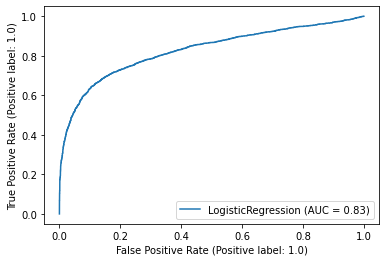

In [169]:
### Trying Logistic Regression and various error metrics
### Singular function for the error metrics. Takes actual and predicted values for the datasets and also X_data.
### Here, the probability threshold for class label assignment is kept as default 0.5.

def error_metrics(actual, predicted, X_data):
    print('Accuracy % age: ' + str(np.round(accuracy_score(actual, predicted)*100, 2)))
    print('ROC-AUC Score: ' + str(np.round(roc_auc_score(actual, log_reg.predict_proba(X_data)[:,1]),3)))
    print('\nClassification Report:')
    print(classification_report(actual, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(actual, predicted))
    return "Done"


### Training Dataset metrics and ROC-AUC Curve
log_reg = LogisticRegression(random_state = 101)
log_reg.fit(X_train[impt_feat], y_train)

print("\nTraining\n------------------------------------------------------------")
y_train_pred = log_reg.predict(X_train[impt_feat])
error_metrics(y_train, y_train_pred, X_train[impt_feat])

print("\n ROC-AUC Curve for the training set")
plot_roc_curve(log_reg, X_train[impt_feat], y_train)
plt.show()


Validation
------------------------------------------------------------
Accuracy % age: 83.21
ROC-AUC Score: 0.837

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.94      0.89      1803
         1.0       0.82      0.58      0.68       811

    accuracy                           0.83      2614
   macro avg       0.83      0.76      0.78      2614
weighted avg       0.83      0.83      0.82      2614


Confusion Matrix:
[[1702  101]
 [ 338  473]]

 ROC-AUC Curve for the validation set


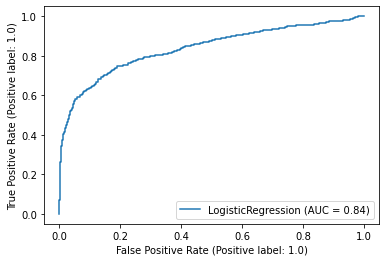

In [170]:
### Validation Dataset metrics and ROC-AUC Curve
print("\nValidation\n------------------------------------------------------------")
y_validate_pred = log_reg.predict(X_validate[impt_feat])
error_metrics(y_validate, y_validate_pred, X_validate[impt_feat])

print("\n ROC-AUC Curve for the validation set")
plot_roc_curve(log_reg, X_validate[impt_feat], y_validate)
plt.show()


Testing
------------------------------------------------------------
Accuracy % age: 81.03
ROC-AUC Score: 0.825

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87      1759
         1.0       0.80      0.56      0.66       856

    accuracy                           0.81      2615
   macro avg       0.81      0.75      0.76      2615
weighted avg       0.81      0.81      0.80      2615


Confusion Matrix:
[[1642  117]
 [ 379  477]]

 ROC-AUC Curve for the testing set


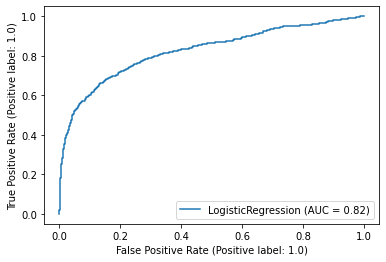

In [171]:
### Testing Dataset metrics and ROC-AUC Curve
print("\nTesting\n------------------------------------------------------------")
y_test_pred = log_reg.predict(X_test[impt_feat])
error_metrics(y_test, y_test_pred, X_test[impt_feat])

print("\n ROC-AUC Curve for the testing set")
plot_roc_curve(log_reg, X_test[impt_feat], y_test)
plt.show()


Training
------------------------------------------------------------
Accuracy % age: 80.79
ROC-AUC Score: 0.827

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86      5364
         1.0       0.71      0.67      0.69      2479

    accuracy                           0.81      7843
   macro avg       0.78      0.77      0.77      7843
weighted avg       0.81      0.81      0.81      7843


Confusion Matrix:
[[4678  686]
 [ 821 1658]]

 ROC-AUC Curve for the training set


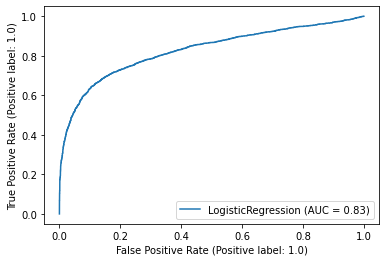

In [172]:
### Trying the same with probability thresholds as 0.4 and 0.6.

### threshold = 0.4

### Training Dataset metrics and ROC-AUC Curve
log_reg = LogisticRegression(random_state = 101)
log_reg.fit(X_train[impt_feat], y_train)

print("\nTraining\n------------------------------------------------------------")
y_train_probabillity = log_reg.predict_proba(X_train[impt_feat])[:,1]
y_train_pred = np.where(y_train_probabillity >= 0.4, 1, 0)
error_metrics(y_train, y_train_pred, X_train[impt_feat])


print("\n ROC-AUC Curve for the training set")
plot_roc_curve(log_reg, X_train[impt_feat], y_train)
plt.show()


Validation
------------------------------------------------------------
Accuracy % age: 81.14
ROC-AUC Score: 0.837

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.86      1803
         1.0       0.71      0.67      0.69       811

    accuracy                           0.81      2614
   macro avg       0.78      0.77      0.78      2614
weighted avg       0.81      0.81      0.81      2614


Confusion Matrix:
[[1577  226]
 [ 267  544]]

 ROC-AUC Curve for the validation set


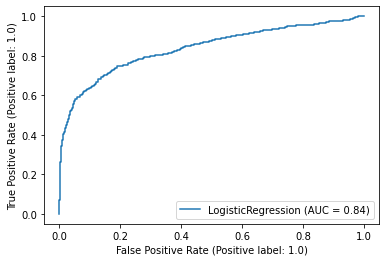

In [173]:
### Validation Dataset metrics and ROC-AUC Curve
print("\nValidation\n------------------------------------------------------------")
y_validate_probabillity = log_reg.predict_proba(X_validate[impt_feat])[:,1]
y_validate_pred = np.where(y_validate_probabillity >= 0.4, 1, 0)
error_metrics(y_validate, y_validate_pred, X_validate[impt_feat])

print("\n ROC-AUC Curve for the validation set")
plot_roc_curve(log_reg, X_validate[impt_feat], y_validate)
plt.show()


Testing
------------------------------------------------------------
Accuracy % age: 81.03
ROC-AUC Score: 0.825

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87      1759
         1.0       0.80      0.56      0.66       856

    accuracy                           0.81      2615
   macro avg       0.81      0.75      0.76      2615
weighted avg       0.81      0.81      0.80      2615


Confusion Matrix:
[[1642  117]
 [ 379  477]]

 ROC-AUC Curve for the testing set


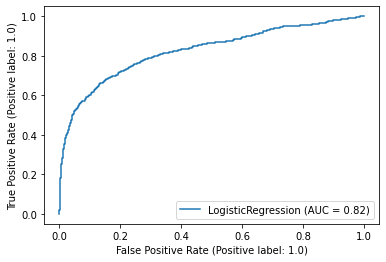

In [174]:
### Testing Dataset metrics and ROC-AUC Curve
print("\nTesting\n------------------------------------------------------------")
y_test_probabillity = log_reg.predict_proba(X_test[impt_feat])[:,1]
y_test_pred = np.where(y_test_probabillity >= 0.4, 1, 0)
y_test_pred = log_reg.predict(X_test[impt_feat])
error_metrics(y_test, y_test_pred, X_test[impt_feat])

print("\n ROC-AUC Curve for the testing set")
plot_roc_curve(log_reg, X_test[impt_feat], y_test)
plt.show()


Training
------------------------------------------------------------
Accuracy % age: 80.33
ROC-AUC Score: 0.827

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.97      0.87      5364
         1.0       0.87      0.44      0.59      2479

    accuracy                           0.80      7843
   macro avg       0.83      0.71      0.73      7843
weighted avg       0.82      0.80      0.78      7843


Confusion Matrix:
[[5199  165]
 [1378 1101]]

 ROC-AUC Curve for the training set


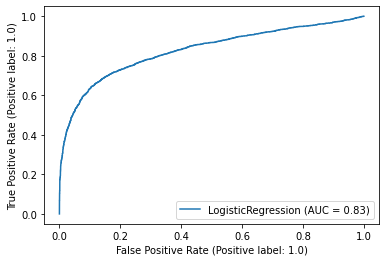

In [175]:
### threshold = 0.6

### Training Dataset metrics and ROC-AUC Curve
log_reg = LogisticRegression(random_state = 101)
log_reg.fit(X_train[impt_feat], y_train)

print("\nTraining\n------------------------------------------------------------")
y_train_probabillity = log_reg.predict_proba(X_train[impt_feat])[:,1]
y_train_pred = np.where(y_train_probabillity >= 0.6, 1, 0)
error_metrics(y_train, y_train_pred, X_train[impt_feat])

print("\n ROC-AUC Curve for the training set")
plot_roc_curve(log_reg, X_train[impt_feat], y_train)
plt.show()


Validation
------------------------------------------------------------
Accuracy % age: 81.45
ROC-AUC Score: 0.837

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.98      0.88      1803
         1.0       0.89      0.46      0.60       811

    accuracy                           0.81      2614
   macro avg       0.85      0.72      0.74      2614
weighted avg       0.83      0.81      0.79      2614


Confusion Matrix:
[[1759   44]
 [ 441  370]]

 ROC-AUC Curve for the validation set


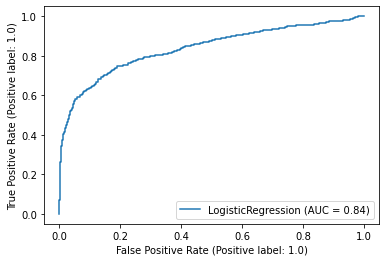

In [176]:
### Validation Dataset metrics and ROC-AUC Curve
print("\nValidation\n------------------------------------------------------------")
y_validate_probabillity = log_reg.predict_proba(X_validate[impt_feat])[:,1]
y_validate_pred = np.where(y_validate_probabillity >= 0.6, 1, 0)
error_metrics(y_validate, y_validate_pred, X_validate[impt_feat])

print("\n ROC-AUC Curve for the validation set")
plot_roc_curve(log_reg, X_validate[impt_feat], y_validate)
plt.show()


Testing
------------------------------------------------------------
Accuracy % age: 79.58
ROC-AUC Score: 0.825

Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.97      0.86      1759
         1.0       0.87      0.44      0.59       856

    accuracy                           0.80      2615
   macro avg       0.82      0.71      0.73      2615
weighted avg       0.81      0.80      0.77      2615


Confusion Matrix:
[[1701   58]
 [ 476  380]]

 ROC-AUC Curve for the testing set


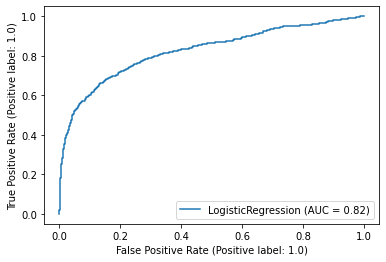

In [177]:
### Testing Dataset metrics and ROC-AUC Curve
print("\nTesting\n------------------------------------------------------------")
y_test_probabillity = log_reg.predict_proba(X_test[impt_feat])[:,1]
y_test_pred = np.where(y_test_probabillity >= 0.6, 1, 0)
error_metrics(y_test, y_test_pred, X_test[impt_feat])

print("\n ROC-AUC Curve for the testing set")
plot_roc_curve(log_reg, X_test[impt_feat], y_test)
plt.show()

In [178]:
### XGBoost Model to compare the results with the Logistic Regression model

xgb_weighted = XGBClassifier(verbosity = 0, random_state = 3)

grid_list = {'nthread':[4], 'objective':['binary:logistic'], 'learning_rate': [0.001, 0.01, 0.03],
             'max_depth': [5, 6, 7], 'min_child_weight': [3, 4], 'silent': [1],
             'subsample': [0.7], 'colsample_bytree': [0.7], 'n_estimators': [100]}

# initializing the gridsearch and finding optimum set of hyperparameters. Error metric used is roc_auc score.
# Training the gridsearch and finding the best model.
xgb_grid_search = GridSearchCV(estimator = xgb_weighted, param_grid = grid_list, cv = 10, n_jobs = 4, 
                               verbose = False, scoring = 'roc_auc')
xgb_grid_search.fit(X_train[impt_feat], y_train)
xgb_best_model = xgb_grid_search.best_estimator_


Training
------------------------------------------------------------
Accuracy % age: 88.59
ROC-AUC Score: 0.934

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92      5364
         1.0       0.92      0.70      0.79      2479

    accuracy                           0.89      7843
   macro avg       0.90      0.84      0.86      7843
weighted avg       0.89      0.89      0.88      7843


Confusion Matrix:
[[5215  149]
 [ 746 1733]]

 ROC-AUC Curve for the training set


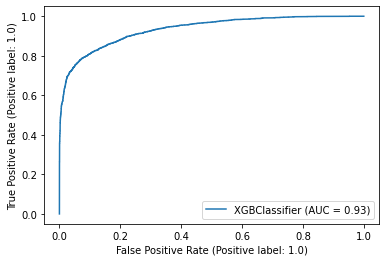

In [179]:
def error_metrics(actual, predicted, X_data):
    print('Accuracy % age: ' + str(np.round(accuracy_score(actual, predicted)*100, 2)))
    print('ROC-AUC Score: ' + str(np.round(roc_auc_score(actual, xgb_best_model.predict_proba(X_data)[:,1]),3)))
    print('\nClassification Report:')
    print(classification_report(actual, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(actual, predicted))
    return "Done"

print("\nTraining\n------------------------------------------------------------")
y_train_pred = xgb_best_model.predict(X_train[impt_feat])
error_metrics(y_train, y_train_pred, X_train[impt_feat])

print("\n ROC-AUC Curve for the training set")
plot_roc_curve(xgb_best_model, X_train[impt_feat], y_train)
plt.show()


Validation
------------------------------------------------------------
Accuracy % age: 86.23
ROC-AUC Score: 0.886

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91      1803
         1.0       0.87      0.65      0.75       811

    accuracy                           0.86      2614
   macro avg       0.87      0.80      0.83      2614
weighted avg       0.86      0.86      0.86      2614


Confusion Matrix:
[[1726   77]
 [ 283  528]]

 ROC-AUC Curve for the validation set


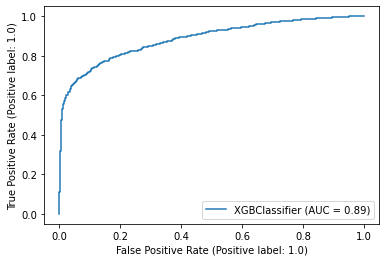

In [180]:
### Validation Dataset metrics and ROC-AUC Curve
print("\nValidation\n------------------------------------------------------------")
y_validate_pred = xgb_best_model.predict(X_validate[impt_feat])
error_metrics(y_validate, y_validate_pred, X_validate[impt_feat])

print("\n ROC-AUC Curve for the validation set")
plot_roc_curve(xgb_best_model, X_validate[impt_feat], y_validate)
plt.show()


Testing
------------------------------------------------------------
Accuracy % age: 84.93
ROC-AUC Score: 0.883

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.95      0.89      1759
         1.0       0.85      0.65      0.74       856

    accuracy                           0.85      2615
   macro avg       0.85      0.80      0.82      2615
weighted avg       0.85      0.85      0.84      2615


Confusion Matrix:
[[1664   95]
 [ 299  557]]

 ROC-AUC Curve for the testing set


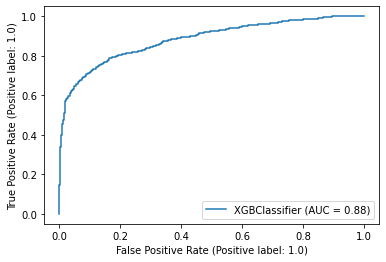

In [181]:
### Testing Dataset metrics and ROC-AUC Curve
print("\nTesting\n------------------------------------------------------------")
y_test_pred = xgb_best_model.predict(X_test[impt_feat])
error_metrics(y_test, y_test_pred, X_test[impt_feat])

print("\n ROC-AUC Curve for the testing set")
plot_roc_curve(xgb_best_model, X_test[impt_feat], y_test)
plt.show()

In [182]:
### Drivers of response

xgb_imp_df = pd.DataFrame()
xgb_imp_df['cols'] = X_train[impt_feat].columns
xgb_imp_df['importance'] = xgb_best_model.feature_importances_
xgb_imp_df = xgb_imp_df.sort_values(by="importance", ascending=False).reset_index(drop=True)
xgb_imp_df

,cols,importance
0,mean_std_sensor_power,0.432966
1,log_e_entro__total_load,0.153114
2,skew_total_load,0.107625
3,PSDF_15_20Hz_max,0.074057
4,last_sum,0.053374
5,max_total_load,0.051115
6,PSDF_0_5Hz_mean,0.049244
7,lc_max_4_sensor,0.041573
8,min_of_std_4_sensor,0.036933


## Model 1: Elimination and non-elimination Interprobality

In [183]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import shap
import sklearn

shap.initjs()

In [184]:
X100 = shap.utils.sample(X_train[impt_feat], 100) # 100 instances for use as the background distribution

# a simple linear model
xgb_weighted = XGBClassifier(verbosity = 0, random_state = 3)

grid_list = {'nthread':[4], 'objective':['binary:logistic'], 'learning_rate': [0.001, 0.01, 0.03],
             'max_depth': [5, 6, 7], 'min_child_weight': [3, 4], 'silent': [1],
             'subsample': [0.7], 'colsample_bytree': [0.7], 'n_estimators': [100]}

xgb_grid_search = GridSearchCV(estimator = xgb_weighted, param_grid = grid_list, cv = 10, n_jobs = 4, 
                               verbose = False, scoring = 'roc_auc')
xgb_grid_search.fit(X_train[impt_feat], y_train)
model = xgb_grid_search.best_estimator_

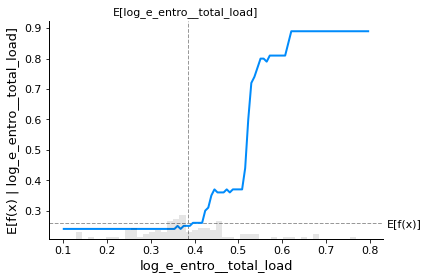

In [185]:
shap.partial_dependence_plot(
    "log_e_entro__total_load", model.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

In [186]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X_train[impt_feat])

Exact explainer: 7844it [18:47,  6.95it/s]                                                                             


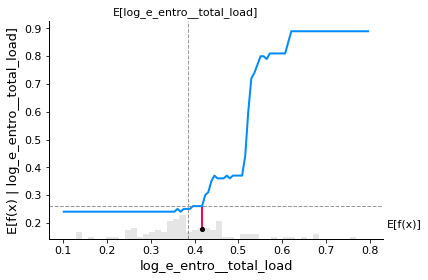

In [187]:
# make a standard partial dependence plot
sample_ind = 20
shap.partial_dependence_plot(
    "log_e_entro__total_load", model.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

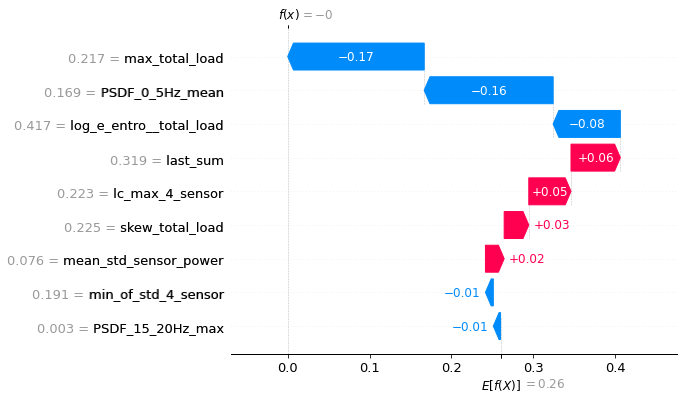

In [188]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=10)

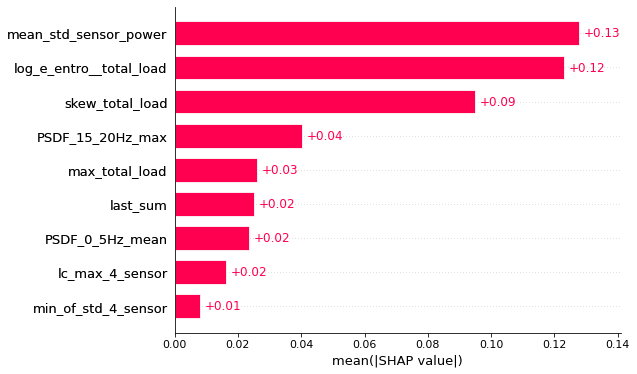

In [189]:
shap.plots.bar(shap_values)

Exact explainer: 7844it [45:06,  2.87it/s]                                                                             


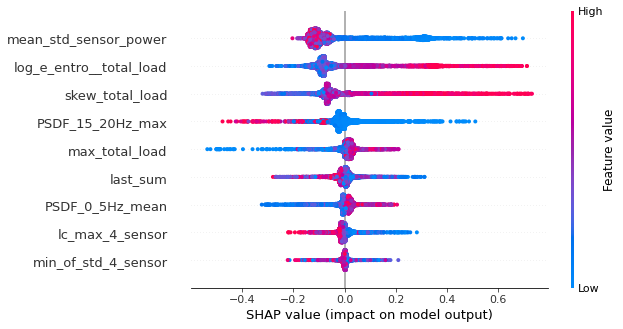

In [190]:
explainer_ebm = shap.Explainer(model.predict, X100)
shap_values_ebm = explainer_ebm(X_train[impt_feat])
shap.plots.beeswarm(shap_values_ebm)

## Model 1: Elimination and non-elimination Misclassification

In [191]:
X = pd.concat((X_train,X_validate,X_test))
y_test_pred_df_2 = np.concatenate((y_train_pred,y_validate_pred,y_test_pred), axis = 0)

finaal_df_2 = pd.DataFrame(X)
finaal_df_2['y_pred_2'] = y_test_pred_df_2

misclassification1 = finaal_df_2.join(dataset['non_elimination'])
misclassification1 = misclassification1.reset_index()

misclassification1['class'] = 'yes'
for i in range(0, len(misclassification1)):
    if misclassification1['non_elimination'][i] != misclassification1['y_pred_2'][i]: 
        misclassification1['class'][i] = 'No'     

In [192]:
misclassification1.head(4)

,index,lc_sum_mean,lc_sum_std,time_span,min_total_load,max_total_load,median_total_load,skew_total_load,kourtosis_total_load,range_total_load,log_e_entro__total_load,lc_max_4_sensor,lc_min_4_sensor,std_of_mean_4_sensor,max_of_std_4_sensor,min_of_std_4_sensor,mean_of_std_4_sensor,std_of_std_4_sensor,last_sum,PSDF_0_5Hz_max,PSDF_0_5Hz_min,PSDF_0_5Hz_median,PSDF_0_5Hz_mean,PSDF_0_5Hz_std,PSDF_5_10Hz_max,PSDF_5_10Hz_min,PSDF_5_10Hz_median,PSDF_5_10Hz_mean,PSDF_5_10Hz_std,PSDF_10_15Hz_max,PSDF_10_15Hz_min,PSDF_10_15Hz_median,PSDF_10_15Hz_mean,PSDF_10_15Hz_std,PSDF_15_20Hz_max,PSDF_15_20Hz_min,PSDF_15_20Hz_median,PSDF_15_20Hz_mean,PSDF_15_20Hz_std,power_by_cat,std_total_power,std_sensor_power,mean_std_sensor_power,Time_bin_Time_Night_9,Time_bin_Time_day_Night,Month_bin_Month_Nov_July,Weight_bins_good,Weight_bins_more_weight,y_pred_2,non_elimination,class
0,3176,0.598269,0.705288,0.493810,0.777508,0.355664,0.652457,0.184007,0.000187,0.140345,0.294231,0.540185,0.624649,0.436435,0.495390,0.342373,0.533908,0.357064,0.477848,0.354328,0.000089,0.008353,0.497762,0.456115,0.019113,0.000004,0.005988,0.008261,0.012213,0.006603,0.000002,0.001819,0.002340,0.003527,0.002459,8.969535e-07,0.000946,0.001321,0.003411,0.154261,0.342416,0.342416,0.265396,0,0,1,1,0,0,1,No
1,5986,0.287196,0.624920,0.482323,0.634695,0.210471,0.265186,0.203099,0.000395,0.132569,0.334615,0.210805,0.519906,0.238443,0.318259,0.597907,0.490292,0.100088,0.220995,0.270694,0.000361,0.013871,0.390871,0.352142,0.019227,0.000002,0.004392,0.006529,0.010195,0.006715,0.000015,0.001486,0.002023,0.003293,0.148857,8.969535e-07,0.000972,0.003409,0.063670,0.031601,0.261007,0.261007,0.218475,0,1,1,1,0,0,0,yes
2,3291,0.370722,0.599966,0.327435,0.693100,0.261412,0.280914,0.211400,0.000458,0.127497,0.386538,0.238436,0.524025,0.227131,0.358505,0.204023,0.450888,0.318485,0.325157,0.165954,0.000025,0.016018,0.360209,0.261912,0.031016,0.000007,0.007353,0.013538,0.023228,0.008163,0.000012,0.001500,0.002316,0.004178,0.001951,2.690860e-06,0.000622,0.000953,0.002741,0.041315,0.181592,0.181592,0.139296,0,1,0,1,0,0,0,yes
3,12528,0.600050,0.518313,0.653055,0.712992,0.334255,0.605889,0.142225,0.005025,0.180042,0.234615,0.528493,0.460468,0.560432,0.377270,0.703183,0.640184,0.121052,0.658518,0.102206,0.000395,0.040728,0.268689,0.136679,0.070853,0.000135,0.016826,0.028128,0.043794,0.022362,0.000003,0.003483,0.004872,0.008299,0.005066,8.969535e-06,0.001813,0.002690,0.007145,0.156579,0.186742,0.186742,0.385630,0,1,0,0,1,0,0,yes


<AxesSubplot:xlabel='class', ylabel='log_e_entro__total_load'>

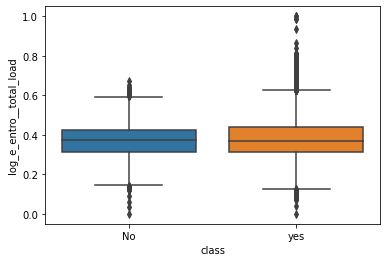

In [193]:
sns.boxplot(x ='class', y = 'log_e_entro__total_load', data =  misclassification1 )

<AxesSubplot:xlabel='class', ylabel='mean_std_sensor_power'>

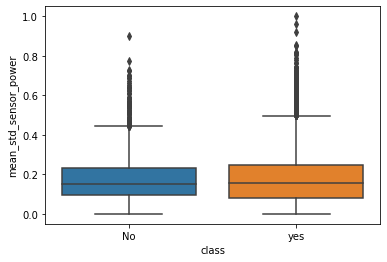

In [194]:
sns.boxplot(x ='class', y = 'mean_std_sensor_power', data =  misclassification1 )

<AxesSubplot:xlabel='class', ylabel='max_total_load'>

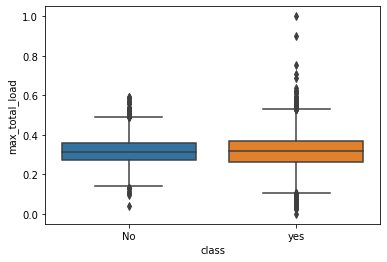

In [195]:
sns.boxplot(x ='class', y = 'max_total_load', data =  misclassification1 )

<AxesSubplot:xlabel='class', ylabel='skew_total_load'>

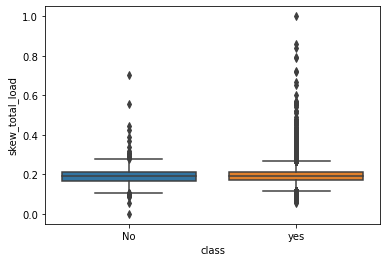

In [196]:
sns.boxplot(x ='class', y = 'skew_total_load', data =  misclassification1 )

<AxesSubplot:xlabel='class', ylabel='PSDF_0_5Hz_mean'>

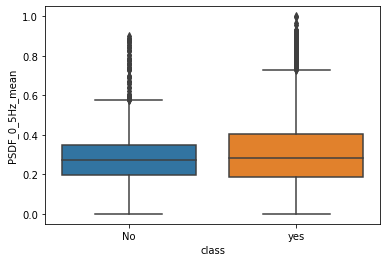

In [197]:
sns.boxplot(x ='class', y = 'PSDF_0_5Hz_mean', data =  misclassification1 )

<AxesSubplot:xlabel='class', ylabel='PSDF_15_20Hz_max'>

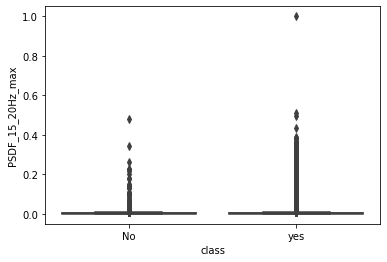

In [198]:
sns.boxplot(x ='class', y = 'PSDF_15_20Hz_max', data =  misclassification1 )

In [199]:
wrong_pred = misclassification1[misclassification1['class'] == 'No']
wrong_pred

,index,lc_sum_mean,lc_sum_std,time_span,min_total_load,max_total_load,median_total_load,skew_total_load,kourtosis_total_load,range_total_load,log_e_entro__total_load,lc_max_4_sensor,lc_min_4_sensor,std_of_mean_4_sensor,max_of_std_4_sensor,min_of_std_4_sensor,mean_of_std_4_sensor,std_of_std_4_sensor,last_sum,PSDF_0_5Hz_max,PSDF_0_5Hz_min,PSDF_0_5Hz_median,PSDF_0_5Hz_mean,PSDF_0_5Hz_std,PSDF_5_10Hz_max,PSDF_5_10Hz_min,PSDF_5_10Hz_median,PSDF_5_10Hz_mean,PSDF_5_10Hz_std,PSDF_10_15Hz_max,PSDF_10_15Hz_min,PSDF_10_15Hz_median,PSDF_10_15Hz_mean,PSDF_10_15Hz_std,PSDF_15_20Hz_max,PSDF_15_20Hz_min,PSDF_15_20Hz_median,PSDF_15_20Hz_mean,PSDF_15_20Hz_std,power_by_cat,std_total_power,std_sensor_power,mean_std_sensor_power,Time_bin_Time_Night_9,Time_bin_Time_day_Night,Month_bin_Month_Nov_July,Weight_bins_good,Weight_bins_more_weight,y_pred_2,non_elimination,class
0,3176,0.598269,0.705288,0.493810,0.777508,0.355664,0.652457,0.184007,0.000187,0.140345,0.294231,0.540185,0.624649,0.436435,0.495390,0.342373,0.533908,0.357064,0.477848,0.354328,0.000089,0.008353,0.497762,0.456115,0.019113,0.000004,0.005988,0.008261,0.012213,0.006603,0.000002,0.001819,0.002340,0.003527,0.002459,8.969535e-07,0.000946,0.001321,0.003411,0.154261,0.342416,0.342416,0.265396,0,0,1,1,0,0,1,No
14,12640,0.598661,0.577282,0.174562,0.776058,0.345185,0.629352,0.177643,0.000499,0.131458,0.480769,0.424930,0.644012,0.291477,0.316756,0.367430,0.471182,0.175793,0.485645,0.082909,0.002053,0.028827,0.333449,0.178209,0.017781,0.000055,0.010352,0.013631,0.017174,0.008784,0.000009,0.001048,0.001686,0.003504,0.001484,1.435126e-05,0.000574,0.000855,0.002414,0.065308,0.097026,0.097026,0.087977,0,1,0,1,0,1,0,No
23,2242,0.551519,0.433375,0.224441,0.798247,0.389696,0.491599,0.245711,0.003475,0.154136,0.432692,0.368643,0.588959,0.319473,0.230066,0.245599,0.279603,0.136556,0.540954,0.029336,0.000816,0.028506,0.187655,0.073397,0.026063,0.000069,0.027062,0.030388,0.030521,0.021745,0.000082,0.010840,0.012416,0.016970,0.003926,3.112429e-04,0.003391,0.004064,0.007733,0.077459,0.077089,0.077089,0.043988,0,1,1,1,0,1,0,No
25,3671,0.520608,0.726761,0.388175,0.748071,0.330483,0.483348,0.195628,0.000010,0.143384,0.346154,0.473718,0.469273,0.479372,0.446001,0.340894,0.493765,0.349231,0.427086,0.317755,0.000115,0.005923,0.528529,0.459337,0.012790,0.000002,0.003833,0.005700,0.009050,0.028268,0.000004,0.001132,0.001502,0.004528,0.001395,2.690860e-06,0.000792,0.001074,0.002572,0.090183,0.284100,0.284100,0.177419,0,1,1,1,0,0,1,No
33,10624,0.652550,0.242103,1.000000,0.762745,0.360422,0.621796,0.055617,0.028518,0.158873,0.121154,0.414313,0.710865,0.278223,0.298838,0.521504,0.472412,0.102534,0.674315,0.007925,0.000010,0.026227,0.058303,0.021030,0.117320,0.000054,0.018476,0.034093,0.062030,0.040092,0.000045,0.007205,0.010624,0.018352,0.021084,3.587814e-06,0.004136,0.006413,0.019313,0.370932,0.081409,0.081409,0.417889,0,1,0,1,0,0,1,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13054,3182,0.520361,0.366239,0.279900,0.792293,0.327547,0.455650,0.223022,0.001249,0.098950,0.392308,0.430200,0.540639,0.416483,0.337741,0.125822,0.343552,0.300040,0.504284,0.045145,0.000554,0.013163,0.134190,0.080776,0.059663,0.000007,0.009955,0.021540,0.039044,0.006296,0.000011,0.002219,0.002758,0.004001,0.004657,6.278674e-06,0.001665,0.002685,0.007907,0.066519,0.053331,0.053331,0.063050,0,1,1,1,0,0,1,No
13056,13020,0.395427,0.537345,0.299838,0.712702,0.264112,0.313960,0.211954,0.000406,0.111714,0.394231,0.382579,0.550011,0.354929,0.648421,0.463748,0.720580,0.536260,0.359472,0.120921,0.000073,0.014705,0.288931,0.200192,0.029378,0.000105,0.010630,0.013017,0.016408,0.012814,0.000088,0.004656,0.005279,0.006525,0.003680,2.421774e-05,0.002901,0.003529,0.006678,0.049510,0.152351,0.152351,0.370968,1,0,1,1,0,0,1,No
13062,5672,0.641941,0.867489,0.290463,0.821284,0.447173,0.511761,0.217488,

## Model 2: Urination & Defecation of cat

In [200]:
df1 = new_dataset[['lc_sum_mean', 'lc_sum_std', 'time_span',
       'min_total_load', 'max_total_load', 'median_total_load',
       'skew_total_load', 'kourtosis_total_load', 'range_total_load',
       'log_e_entro__total_load', 'lc_max_4_sensor', 'lc_min_4_sensor',
       'std_of_mean_4_sensor', 'max_of_std_4_sensor', 'min_of_std_4_sensor',
       'mean_of_std_4_sensor', 'std_of_std_4_sensor', 'last_sum',
       'PSDF_0_5Hz_max', 'PSDF_0_5Hz_min', 'PSDF_0_5Hz_median',
       'PSDF_0_5Hz_mean', 'PSDF_0_5Hz_std', 'PSDF_5_10Hz_max',
       'PSDF_5_10Hz_min', 'PSDF_5_10Hz_median', 'PSDF_5_10Hz_mean',
       'PSDF_5_10Hz_std', 'PSDF_10_15Hz_max', 'PSDF_10_15Hz_min',
       'PSDF_10_15Hz_median', 'PSDF_10_15Hz_mean', 'PSDF_10_15Hz_std',
       'PSDF_15_20Hz_max', 'PSDF_15_20Hz_min', 'PSDF_15_20Hz_median',
       'PSDF_15_20Hz_mean', 'PSDF_15_20Hz_std', 'power_by_cat',
       'non_elimination', 'urination', 'Weight_bins', 'Time_bin',
       'Month_bin', 'std_total_power', 'std_sensor_power',
       'mean_std_sensor_power']]

df1 = df1[df1['non_elimination'] ==0]

In [201]:
df1 = df1.drop(columns = 'non_elimination')

In [202]:
### The following code tells us about the level of class imbalance in the dataset. While the dataset is balanced,
### a 32%-68% imbalance may give us acceptable results and we may not need sampling.

target_df = df1.urination.value_counts().reset_index()
target_df['class_percentage'] = np.round(target_df.eval(f"urination/{target_df.urination.sum()}"), 2)
target_df

,index,urination,class_percentage
0,1,6610,0.74
1,0,2316,0.26


In [206]:
### Code in this cell handles data imbalance by upsampling miniority class.
### In order to see the model performance with the imbalance handled, please comment the below lines.

df_maj = df1[df1.urination == 1]
df_min = df1[df1.urination == 0]
 
# Upsample minority class
df_up_sampled = resample(df_min, replace=True, n_samples=len(df_maj), random_state=101)
df1 = df_up_sampled.append(df_maj)
print(df1['urination'].value_counts())

0    6610
1    6610
Name: urination, dtype: int64


In [207]:
### Creating dummy variables
num_cols = df1.select_dtypes([np.number]).columns.to_list()
categorical_cols = set(df1.columns) - set(num_cols)

In [208]:
df = pd.get_dummies(data = df1, columns = categorical_cols, drop_first = True)

In [209]:
### Creating dummy variables for categorical columns
df_cat = pd.get_dummies(data = df1[categorical_cols], columns = categorical_cols, drop_first = True)
df[num_cols] =  scaling.fit_transform(df[num_cols])

In [210]:
### Creating the train, test and validate split

df = df.sample(frac = 1, random_state = 101)

### Keeping first 60% rows for training, next 20% for validation and last 20% for testing sets.

train = df[:int(len(df)*0.6)]
validate = df[int(len(df)*0.6):int(len(df)*0.8)]
test = df[int(len(df)*0.8):]

print(train.shape)
print(validate.shape)
print(test.shape)

### Separating the target column from the three datasets in X_data and y_data format.

X_train = train.drop(columns = "urination")
y_train = train["urination"]

X_validate = validate.drop(columns = "urination")
y_validate = validate["urination"]

X_test = test.drop(columns = "urination")
y_test = test["urination"]

(7932, 48)
(2644, 48)
(2644, 48)


In [211]:
num_cols.remove('urination')

In [212]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

ft=[]
vif_val = 10
x =X_train[num_cols]
collinear_ft = []
vif_max = 100
while vif_max>vif_val:
    x_vif = sm.add_constant(x.drop(columns=collinear_ft))
    vif = pd.DataFrame()
    vif['VIF']=[variance_inflation_factor(x_vif.values,i) for i in range(x_vif.shape[1])]
    vif['features']=x_vif.columns
    vif = vif.sort_values(by='VIF',ascending=False).reset_index(drop=True)
    if vif.loc[0,'features']!='const':
        vif_max = vif.loc[0,'VIF']
        collinear_ft.append(vif.loc[0,'features'])
    else:
        vif_max = vif.loc[1,'VIF']
        collinear_ft.append(vif.loc[1,'features'])

        
vif_feat = vif['features'].values.tolist()
vif_feat.remove('const')
print(vif_feat)

['PSDF_10_15Hz_median', 'PSDF_5_10Hz_median', 'mean_std_sensor_power', 'last_sum', 'median_total_load', 'power_by_cat', 'log_e_entro__total_load', 'PSDF_0_5Hz_median', 'PSDF_15_20Hz_median', 'PSDF_0_5Hz_max', 'lc_max_4_sensor', 'range_total_load', 'PSDF_15_20Hz_min', 'PSDF_5_10Hz_max', 'lc_min_4_sensor', 'PSDF_10_15Hz_min', 'PSDF_10_15Hz_max', 'skew_total_load', 'max_of_std_4_sensor', 'min_of_std_4_sensor', 'PSDF_5_10Hz_min', 'PSDF_0_5Hz_min', 'PSDF_15_20Hz_max', 'kourtosis_total_load']


In [213]:
X_train_vif = X_train[vif_feat]

logit = sm.Logit(y_train,sm.add_constant(X_train[vif_feat])).fit(method='bfgs')
logit.summary()

         Current function value: 0.477654
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              urination   No. Observations:                 7932
Model:                          Logit   Df Residuals:                     7907
Method:                           MLE   Df Model:                           24
Date:                Thu, 15 Dec 2022   Pseudo R-squ.:                  0.3109
Time:                        13:20:22   Log-Likelihood:                -3788.8
converged:                      False   LL-Null:                       -5497.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -6.4975      0.483    -13.460      0.000      -7.444      -5.551
PSDF_10_15Hz_median         0.9076      1.485      0.611      0.541      -2.003       3.818
PSDF_5_10Hz_median         -0.1895      1.332     -0.142      0.887      -2.800       2.421
mean_std_sensor_power      -3.1742      0.725     -4.378      0.000      -4.595      -1.753
last_sum                    4.8693      0.497      9.805      0.000       3.896       5.843
median_total_load          -3.7730      0.454     -8.313      0.000      -4.663      -2.883
power_by_cat               -1.4824      0.708     -2.093      0.036      -2.871      -0.094
log_e_entro__total_load     7.9372      0.685     11.589      0.000       6.595       9.280
PSDF_0_5Hz_median           0.5227      1.310      0.399      0.690      -2.045       3.090
PSDF_15_20Hz_median        -0.2734      1.204     -0.227      0.820      -2.633       2.086
PSDF_0_5Hz_max              0.1046      0.431      0.243      0.808      -0.740       0.949
lc_max_4_sensor             1.2803      0.376      3.409      0.001       0.544       2.016
range_total_load            2.2501      0.626      3.597      0.000       1.024       3.476
PSDF_15_20Hz_min            0.7468      2.634      0.283      0.777      -4.416       5.910
PSDF_5_10Hz_max            -5.2798      0.652     -8.098      0.000      -6.558      -4.002
lc_min_4_sensor             0.5586      0.340      1.642      0.100      -0.108       1.225
PSDF_10_15Hz_min           -0.4129      3.095     -0.133      0.894      -6.479       5.654
PSDF_10_15Hz_max           -1.5080      1.331     -1.133      0.257      -4.117       1.101
skew_total_load             5.1806      1.149      4.511      0.000       2.929       7.432
max_of_std_4_sensor         3.4845      0.518      6.725      0.000       2.469       4.500
min_of_std_4_sensor         0.4392      0.272      1.617      0.106      -0.093       0.972
PSDF_5_10Hz_min             0.2329      3.089      0.075      0.940      -5.821       6.287
PSDF_0_5Hz_min              0.3207      2.398      0.134      0.894      -4.380       5.021
PSDF_15_20Hz_max           -3.1639      0.662     -4.776      0.000      -4.462      -1.866
kourtosis_total_load       -0.8005      5.226     -0.153      0.878     -11.043       9.442
===========================================================================================
"""

In [214]:
back_ele_features = X_train_vif.columns.tolist()
while(len(back_ele_features)>0):
    features_with_constant = sm.add_constant(X_train_vif[back_ele_features])
    p_values = sm.OLS(y_train, features_with_constant).fit().pvalues[1:]
    max_p_value = p_values.max()
    if(max_p_value >= 0.05):
        excluded_feature = p_values.idxmax()
        back_ele_features.remove(excluded_feature)
    else:
        break 
print(back_ele_features)

['PSDF_10_15Hz_median', 'PSDF_5_10Hz_median', 'mean_std_sensor_power', 'last_sum', 'median_total_load', 'power_by_cat', 'log_e_entro__total_load', 'PSDF_0_5Hz_median', 'PSDF_15_20Hz_median', 'PSDF_0_5Hz_max', 'lc_max_4_sensor', 'range_total_load', 'PSDF_15_20Hz_min', 'PSDF_5_10Hz_max', 'lc_min_4_sensor', 'PSDF_10_15Hz_min', 'PSDF_10_15Hz_max', 'skew_total_load', 'max_of_std_4_sensor', 'PSDF_15_20Hz_max', 'kourtosis_total_load']


In [215]:
X_train_vif = X_train[back_ele_features]

logit = sm.Logit(y_train,sm.add_constant(X_train[back_ele_features])).fit(method='bfgs')
logit.summary()

         Current function value: 0.475478
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              urination   No. Observations:                 7932
Model:                          Logit   Df Residuals:                     7910
Method:                           MLE   Df Model:                           21
Date:                Thu, 15 Dec 2022   Pseudo R-squ.:                  0.3140
Time:                        13:20:23   Log-Likelihood:                -3771.5
converged:                      False   LL-Null:                       -5497.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -6.3214      0.476    -13.291      0.000      -7.254      -5.389
PSDF_10_15Hz_median         1.2129      1.458      0.832      0.406      -1.645       4.071
PSDF_5_10Hz_median          0.3373      1.288      0.262      0.793      -2.188       2.863
mean_std_sensor_power      -2.8683      0.606     -4.733      0.000      -4.056      -1.681
last_sum                    4.7739      0.484      9.862      0.000       3.825       5.723
median_total_load          -4.2329      0.444     -9.533      0.000      -5.103      -3.363
power_by_cat               -0.6290      0.673     -0.934      0.350      -1.949       0.691
log_e_entro__total_load     7.2867      0.617     11.816      0.000       6.078       8.495
PSDF_0_5Hz_median           0.7544      1.274      0.592      0.554      -1.743       3.252
PSDF_15_20Hz_median        -0.3451      1.192     -0.290      0.772      -2.681       1.991
PSDF_0_5Hz_max             -0.6188      0.420     -1.472      0.141      -1.443       0.205
lc_max_4_sensor             0.8210      0.368      2.230      0.026       0.100       1.542
range_total_load            2.6442      0.604      4.378      0.000       1.460       3.828
PSDF_15_20Hz_min            0.6940      2.493      0.278      0.781      -4.192       5.580
PSDF_5_10Hz_max            -4.8902      0.633     -7.726      0.000      -6.131      -3.650
lc_min_4_sensor             0.7767      0.333      2.335      0.020       0.125       1.429
PSDF_10_15Hz_min           -0.5576      2.956     -0.189      0.850      -6.351       5.236
PSDF_10_15Hz_max           -1.2912      1.303     -0.991      0.322      -3.845       1.263
skew_total_load             5.8051      1.140      5.092      0.000       3.570       8.040
max_of_std_4_sensor         3.7215      0.450      8.272      0.000       2.840       4.603
PSDF_15_20Hz_max           -3.6818      0.671     -5.487      0.000      -4.997      -2.367
kourtosis_total_load       -0.8565      5.430     -0.158      0.875     -11.499       9.786
===========================================================================================
"""


Training
------------------------------------------------------------
Accuracy % age: 80.82
ROC-AUC Score: 0.877

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.83      0.81      3942
         1.0       0.83      0.78      0.80      3990

    accuracy                           0.81      7932
   macro avg       0.81      0.81      0.81      7932
weighted avg       0.81      0.81      0.81      7932


Confusion Matrix:
[[3280  662]
 [ 859 3131]]

 ROC-AUC Curve for the training set


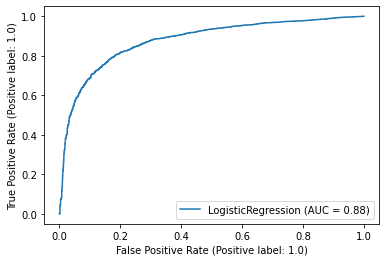

In [216]:
### Trying Logistic Regression and various error metrics
### Singular function for the error metrics. Takes actual and predicted values for the datasets and also X_data.
### Here, the probability threshold for class label assignment is kept as default 0.5.

def error_metrics(actual, predicted, X_data):
    print('Accuracy % age: ' + str(np.round(accuracy_score(actual, predicted)*100, 2)))
    print('ROC-AUC Score: ' + str(np.round(roc_auc_score(actual, log_reg.predict_proba(X_data)[:,1]),3)))
    print('\nClassification Report:')
    print(classification_report(actual, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(actual, predicted))
    return "Done"


### Training Dataset metrics and ROC-AUC Curve
log_reg = LogisticRegression(random_state = 101)
log_reg.fit(X_train, y_train)

print("\nTraining\n------------------------------------------------------------")
y_train_pred = log_reg.predict(X_train)
error_metrics(y_train, y_train_pred, X_train)

print("\n ROC-AUC Curve for the training set")
plot_roc_curve(log_reg, X_train, y_train)
plt.show()


Validation
------------------------------------------------------------
Accuracy % age: 81.35
ROC-AUC Score: 0.883

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82      1324
         1.0       0.82      0.80      0.81      1320

    accuracy                           0.81      2644
   macro avg       0.81      0.81      0.81      2644
weighted avg       0.81      0.81      0.81      2644


Confusion Matrix:
[[1095  229]
 [ 264 1056]]

 ROC-AUC Curve for the validation set


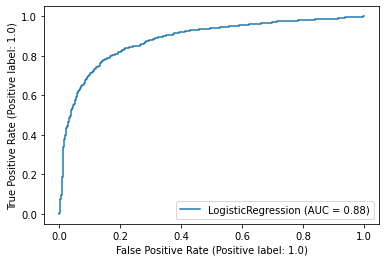

In [217]:
### Validation Dataset metrics and ROC-AUC Curve
print("\nValidation\n------------------------------------------------------------")
y_validate_pred = log_reg.predict(X_validate)
error_metrics(y_validate, y_validate_pred, X_validate)

print("\n ROC-AUC Curve for the validation set")
plot_roc_curve(log_reg, X_validate, y_validate)
plt.show()


Testing
------------------------------------------------------------
Accuracy % age: 82.38
ROC-AUC Score: 0.901

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.83      0.83      1344
         1.0       0.82      0.82      0.82      1300

    accuracy                           0.82      2644
   macro avg       0.82      0.82      0.82      2644
weighted avg       0.82      0.82      0.82      2644


Confusion Matrix:
[[1116  228]
 [ 238 1062]]

 ROC-AUC Curve for the testing set


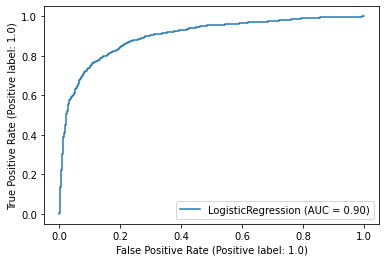

In [218]:
### Testing Dataset metrics and ROC-AUC Curve
print("\nTesting\n------------------------------------------------------------")
y_test_pred = log_reg.predict(X_test)
error_metrics(y_test, y_test_pred, X_test)

print("\n ROC-AUC Curve for the testing set")
plot_roc_curve(log_reg, X_test, y_test)
plt.show()


Training
------------------------------------------------------------
Accuracy % age: 79.5
ROC-AUC Score: 0.877

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.74      0.78      3942
         1.0       0.77      0.85      0.81      3990

    accuracy                           0.80      7932
   macro avg       0.80      0.79      0.79      7932
weighted avg       0.80      0.80      0.79      7932


Confusion Matrix:
[[2898 1044]
 [ 582 3408]]

 ROC-AUC Curve for the training set


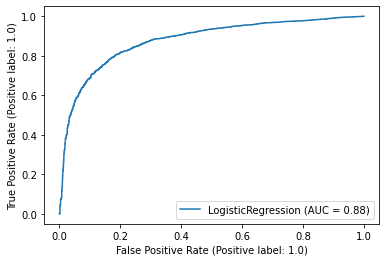

In [219]:
### Trying the same with probability thresholds as 0.4 and 0.6.

### threshold = 0.4

### Training Dataset metrics and ROC-AUC Curve
log_reg = LogisticRegression(random_state = 101)
log_reg.fit(X_train, y_train)

print("\nTraining\n------------------------------------------------------------")
y_train_probabillity = log_reg.predict_proba(X_train)[:,1]
y_train_pred = np.where(y_train_probabillity >= 0.4, 1, 0)
error_metrics(y_train, y_train_pred, X_train)


print("\n ROC-AUC Curve for the training set")
plot_roc_curve(log_reg, X_train, y_train)
plt.show()


Validation
------------------------------------------------------------
Accuracy % age: 79.5
ROC-AUC Score: 0.883

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.74      0.78      1324
         1.0       0.77      0.85      0.81      1320

    accuracy                           0.80      2644
   macro avg       0.80      0.80      0.79      2644
weighted avg       0.80      0.80      0.79      2644


Confusion Matrix:
[[ 980  344]
 [ 198 1122]]

 ROC-AUC Curve for the validation set


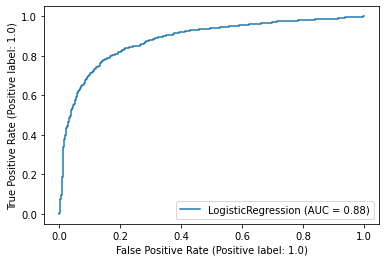

In [220]:
### Validation Dataset metrics and ROC-AUC Curve
print("\nValidation\n------------------------------------------------------------")
y_validate_probabillity = log_reg.predict_proba(X_validate)[:,1]
y_validate_pred = np.where(y_validate_probabillity >= 0.4, 1, 0)
error_metrics(y_validate, y_validate_pred, X_validate)

print("\n ROC-AUC Curve for the validation set")
plot_roc_curve(log_reg, X_validate, y_validate)
plt.show()


Testing
------------------------------------------------------------
Accuracy % age: 82.38
ROC-AUC Score: 0.901

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.83      0.83      1344
         1.0       0.82      0.82      0.82      1300

    accuracy                           0.82      2644
   macro avg       0.82      0.82      0.82      2644
weighted avg       0.82      0.82      0.82      2644


Confusion Matrix:
[[1116  228]
 [ 238 1062]]

 ROC-AUC Curve for the testing set


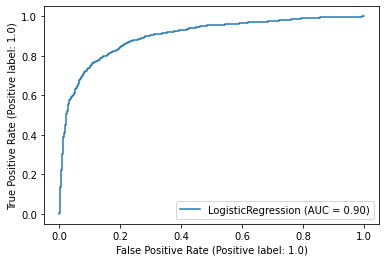

In [221]:
### Testing Dataset metrics and ROC-AUC Curve
print("\nTesting\n------------------------------------------------------------")
y_test_probabillity = log_reg.predict_proba(X_test)[:,1]
y_test_pred = np.where(y_test_probabillity >= 0.4, 1, 0)
y_test_pred = log_reg.predict(X_test)
error_metrics(y_test, y_test_pred, X_test)

print("\n ROC-AUC Curve for the testing set")
plot_roc_curve(log_reg, X_test, y_test)
plt.show()


Training
------------------------------------------------------------
Accuracy % age: 79.93
ROC-AUC Score: 0.877

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.89      0.82      3942
         1.0       0.87      0.71      0.78      3990

    accuracy                           0.80      7932
   macro avg       0.81      0.80      0.80      7932
weighted avg       0.81      0.80      0.80      7932


Confusion Matrix:
[[3518  424]
 [1168 2822]]

 ROC-AUC Curve for the training set


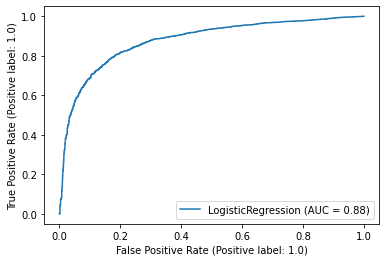

In [222]:
### threshold = 0.6

### Training Dataset metrics and ROC-AUC Curve
log_reg = LogisticRegression(random_state = 101)
log_reg.fit(X_train, y_train)

print("\nTraining\n------------------------------------------------------------")
y_train_probabillity = log_reg.predict_proba(X_train)[:,1]
y_train_pred = np.where(y_train_probabillity >= 0.6, 1, 0)
error_metrics(y_train, y_train_pred, X_train)

print("\n ROC-AUC Curve for the training set")
plot_roc_curve(log_reg, X_train, y_train)
plt.show()


Validation
------------------------------------------------------------
Accuracy % age: 80.37
ROC-AUC Score: 0.883

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.90      0.82      1324
         1.0       0.87      0.71      0.78      1320

    accuracy                           0.80      2644
   macro avg       0.81      0.80      0.80      2644
weighted avg       0.81      0.80      0.80      2644


Confusion Matrix:
[[1189  135]
 [ 384  936]]

 ROC-AUC Curve for the validation set


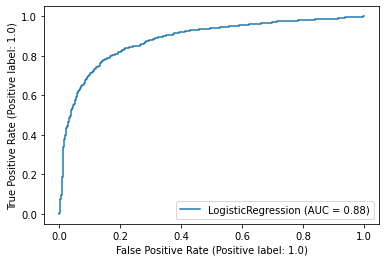

In [223]:
### Validation Dataset metrics and ROC-AUC Curve
print("\nValidation\n------------------------------------------------------------")
y_validate_probabillity = log_reg.predict_proba(X_validate)[:,1]
y_validate_pred = np.where(y_validate_probabillity >= 0.6, 1, 0)
error_metrics(y_validate, y_validate_pred, X_validate)

print("\n ROC-AUC Curve for the validation set")
plot_roc_curve(log_reg, X_validate, y_validate)
plt.show()


Testing
------------------------------------------------------------
Accuracy % age: 81.88
ROC-AUC Score: 0.901

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.91      0.84      1344
         1.0       0.89      0.72      0.80      1300

    accuracy                           0.82      2644
   macro avg       0.83      0.82      0.82      2644
weighted avg       0.83      0.82      0.82      2644


Confusion Matrix:
[[1228  116]
 [ 363  937]]

 ROC-AUC Curve for the testing set


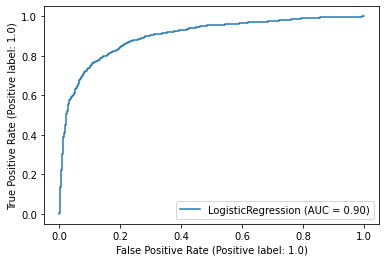

In [224]:
### Testing Dataset metrics and ROC-AUC Curve
print("\nTesting\n------------------------------------------------------------")
y_test_probabillity = log_reg.predict_proba(X_test)[:,1]
y_test_pred = np.where(y_test_probabillity >= 0.6, 1, 0)
error_metrics(y_test, y_test_pred, X_test)

print("\n ROC-AUC Curve for the testing set")
plot_roc_curve(log_reg, X_test, y_test)
plt.show()

In [225]:
### XGBoost Model to compare the results with the Logistic Regression model

xgb_weighted = XGBClassifier(verbosity = 0, random_state = 3)

grid_list = {'nthread':[4], 'objective':['binary:logistic'], 'learning_rate': [0.001, 0.01, 0.03],
             'max_depth': [5, 6, 7], 'min_child_weight': [3, 4], 'silent': [1],
             'subsample': [0.7], 'colsample_bytree': [0.7], 'n_estimators': [100]}

# initializing the gridsearch and finding optimum set of hyperparameters. Error metric used is roc_auc score.
# Training the gridsearch and finding the best model.
xgb_grid_search = GridSearchCV(estimator = xgb_weighted, param_grid = grid_list, cv = 10, n_jobs = 4, 
                               verbose = False, scoring = 'roc_auc')
xgb_grid_search.fit(X_train, y_train)
xgb_best_model = xgb_grid_search.best_estimator_


Training
------------------------------------------------------------
Accuracy % age: 91.84
ROC-AUC Score: 0.978

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92      3942
         1.0       0.95      0.88      0.92      3990

    accuracy                           0.92      7932
   macro avg       0.92      0.92      0.92      7932
weighted avg       0.92      0.92      0.92      7932


Confusion Matrix:
[[3768  174]
 [ 473 3517]]

 ROC-AUC Curve for the training set


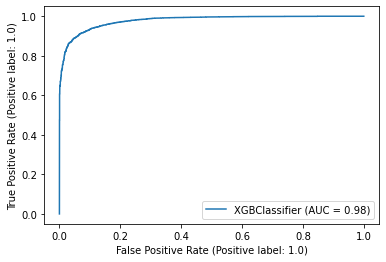

In [226]:
def error_metrics(actual, predicted, X_data):
    print('Accuracy % age: ' + str(np.round(accuracy_score(actual, predicted)*100, 2)))
    print('ROC-AUC Score: ' + str(np.round(roc_auc_score(actual, xgb_best_model.predict_proba(X_data)[:,1]),3)))
    print('\nClassification Report:')
    print(classification_report(actual, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(actual, predicted))
    return "Done"

print("\nTraining\n------------------------------------------------------------")
y_train_pred = xgb_best_model.predict(X_train)
error_metrics(y_train, y_train_pred, X_train)

print("\n ROC-AUC Curve for the training set")
plot_roc_curve(xgb_best_model, X_train, y_train)
plt.show()


Validation
------------------------------------------------------------
Accuracy % age: 88.58
ROC-AUC Score: 0.946

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89      1324
         1.0       0.92      0.84      0.88      1320

    accuracy                           0.89      2644
   macro avg       0.89      0.89      0.89      2644
weighted avg       0.89      0.89      0.89      2644


Confusion Matrix:
[[1228   96]
 [ 206 1114]]

 ROC-AUC Curve for the validation set


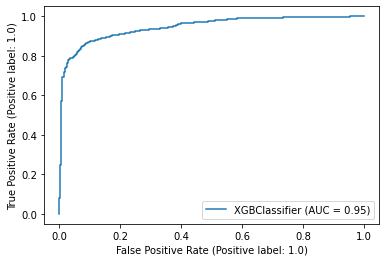

In [227]:
### Validation Dataset metrics and ROC-AUC Curve
print("\nValidation\n------------------------------------------------------------")
y_validate_pred = xgb_best_model.predict(X_validate)
error_metrics(y_validate, y_validate_pred, X_validate)

print("\n ROC-AUC Curve for the validation set")
plot_roc_curve(xgb_best_model, X_validate, y_validate)
plt.show()


Testing
------------------------------------------------------------
Accuracy % age: 89.26
ROC-AUC Score: 0.951

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.90      1344
         1.0       0.91      0.86      0.89      1300

    accuracy                           0.89      2644
   macro avg       0.89      0.89      0.89      2644
weighted avg       0.89      0.89      0.89      2644


Confusion Matrix:
[[1239  105]
 [ 179 1121]]

 ROC-AUC Curve for the testing set


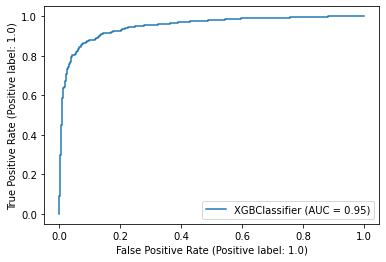

In [228]:
### Testing Dataset metrics and ROC-AUC Curve
print("\nTesting\n------------------------------------------------------------")
y_test_pred = xgb_best_model.predict(X_test)
error_metrics(y_test, y_test_pred, X_test)

print("\n ROC-AUC Curve for the testing set")
plot_roc_curve(xgb_best_model, X_test, y_test)
plt.show()

In [229]:
### Drivers of response

xgb_imp_df = pd.DataFrame()
xgb_imp_df['cols'] = X_train.columns
xgb_imp_df['importance'] = xgb_best_model.feature_importances_
xgb_imp_df = xgb_imp_df.sort_values(by="importance", ascending=False).reset_index(drop=True)
xgb_imp_df

,cols,importance
0,log_e_entro__total_load,0.201830
1,skew_total_load,0.073787
2,time_span,0.049139
3,Weight_bins_good,0.031588
4,kourtosis_total_load,0.029397
5,mean_std_sensor_power,0.025944
6,lc_sum_std,0.020863
7,PSDF_15_20Hz_max,0.020836
8,PSDF_5_10Hz_std,0.019534
9,PSDF_0_5Hz_mean,0.019281


In [230]:
wrong_m1 = wrong_pred.drop(columns = ['index', 'class', 'y_pred_2', 'non_elimination'])

In [231]:
wrong_m1.head()

,lc_sum_mean,lc_sum_std,time_span,min_total_load,max_total_load,median_total_load,skew_total_load,kourtosis_total_load,range_total_load,log_e_entro__total_load,lc_max_4_sensor,lc_min_4_sensor,std_of_mean_4_sensor,max_of_std_4_sensor,min_of_std_4_sensor,mean_of_std_4_sensor,std_of_std_4_sensor,last_sum,PSDF_0_5Hz_max,PSDF_0_5Hz_min,PSDF_0_5Hz_median,PSDF_0_5Hz_mean,PSDF_0_5Hz_std,PSDF_5_10Hz_max,PSDF_5_10Hz_min,PSDF_5_10Hz_median,PSDF_5_10Hz_mean,PSDF_5_10Hz_std,PSDF_10_15Hz_max,PSDF_10_15Hz_min,PSDF_10_15Hz_median,PSDF_10_15Hz_mean,PSDF_10_15Hz_std,PSDF_15_20Hz_max,PSDF_15_20Hz_min,PSDF_15_20Hz_median,PSDF_15_20Hz_mean,PSDF_15_20Hz_std,power_by_cat,std_total_power,std_sensor_power,mean_std_sensor_power,Time_bin_Time_Night_9,Time_bin_Time_day_Night,Month_bin_Month_Nov_July,Weight_bins_good,Weight_bins_more_weight
0,0.598269,0.705288,0.493810,0.777508,0.355664,0.652457,0.184007,0.000187,0.140345,0.294231,0.540185,0.624649,0.436435,0.495390,0.342373,0.533908,0.357064,0.477848,0.354328,0.000089,0.008353,0.497762,0.456115,0.019113,0.000004,0.005988,0.008261,0.012213,0.006603,0.000002,0.001819,0.002340,0.003527,0.002459,8.969535e-07,0.000946,0.001321,0.003411,0.154261,0.342416,0.342416,0.265396,0,0,1,1,0
14,0.598661,0.577282,0.174562,0.776058,0.345185,0.629352,0.177643,0.000499,0.131458,0.480769,0.424930,0.644012,0.291477,0.316756,0.367430,0.471182,0.175793,0.485645,0.082909,0.002053,0.028827,0.333449,0.178209,0.017781,0.000055,0.010352,0.013631,0.017174,0.008784,0.000009,0.001048,0.001686,0.003504,0.001484,1.435126e-05,0.000574,0.000855,0.002414,0.065308,0.097026,0.097026,0.087977,0,1,0,1,0
23,0.551519,0.433375,0.224441,0.798247,0.389696,0.491599,0.245711,0.003475,0.154136,0.432692,0.368643,0.588959,0.319473,0.230066,0.245599,0.279603,0.136556,0.540954,0.029336,0.000816,0.028506,0.187655,0.073397,0.026063,0.000069,0.027062,0.030388,0.030521,0.021745,0.000082,0.010840,0.012416,0.016970,0.003926,3.112429e-04,0.003391,0.004064,0.007733,0.077459,0.077089,0.077089,0.043988,0,1,1,1,0
25,0.520608,0.726761,0.388175,0.748071,0.330483,0.483348,0.195628,0.000010,0.143384,0.346154,0.473718,0.469273,0.479372,0.446001,0.340894,0.493765,0.349231,0.427086,0.317755,0.000115,0.005923,0.528529,0.459337,0.012790,0.000002,0.003833,0.005700,0.009050,0.028268,0.000004,0.001132,0.001502,0.004528,0.001395,2.690860e-06,0.000792,0.001074,0.002572,0.090183,0.284100,0.284100,0.177419,0,1,1,1,0
33,0.652550,0.242103,1.000000,0.762745,0.360422,0.621796,0.055617,0.028518,0.158873,0.121154,0.414313,0.710865,0.278223,0.298838,0.521504,0.472412,0.102534,0.674315,0.007925,0.000010,0.026227,0.058303,0.021030,0.117320,0.000054,0.018476,0.034093,0.062030,0.040092,0.000045,0.007205,0.010624,0.018352,0.021084,3.587814e-06,0.004136,0.006413,0.019313,0.370932,0.081409,0.081409,0.417889,0,1,0,1,0


In [232]:
y_test_pred_wrong = xgb_best_model.predict(wrong_m1)

In [233]:
a = pd.DataFrame(y_test_pred_wrong)
b = a.groupby(by = 0)[0].count()
pd.DataFrame(b)

,0
0,
0,527
1,1122


In [234]:
wrong_pred

,index,lc_sum_mean,lc_sum_std,time_span,min_total_load,max_total_load,median_total_load,skew_total_load,kourtosis_total_load,range_total_load,log_e_entro__total_load,lc_max_4_sensor,lc_min_4_sensor,std_of_mean_4_sensor,max_of_std_4_sensor,min_of_std_4_sensor,mean_of_std_4_sensor,std_of_std_4_sensor,last_sum,PSDF_0_5Hz_max,PSDF_0_5Hz_min,PSDF_0_5Hz_median,PSDF_0_5Hz_mean,PSDF_0_5Hz_std,PSDF_5_10Hz_max,PSDF_5_10Hz_min,PSDF_5_10Hz_median,PSDF_5_10Hz_mean,PSDF_5_10Hz_std,PSDF_10_15Hz_max,PSDF_10_15Hz_min,PSDF_10_15Hz_median,PSDF_10_15Hz_mean,PSDF_10_15Hz_std,PSDF_15_20Hz_max,PSDF_15_20Hz_min,PSDF_15_20Hz_median,PSDF_15_20Hz_mean,PSDF_15_20Hz_std,power_by_cat,std_total_power,std_sensor_power,mean_std_sensor_power,Time_bin_Time_Night_9,Time_bin_Time_day_Night,Month_bin_Month_Nov_July,Weight_bins_good,Weight_bins_more_weight,y_pred_2,non_elimination,class
0,3176,0.598269,0.705288,0.493810,0.777508,0.355664,0.652457,0.184007,0.000187,0.140345,0.294231,0.540185,0.624649,0.436435,0.495390,0.342373,0.533908,0.357064,0.477848,0.354328,0.000089,0.008353,0.497762,0.456115,0.019113,0.000004,0.005988,0.008261,0.012213,0.006603,0.000002,0.001819,0.002340,0.003527,0.002459,8.969535e-07,0.000946,0.001321,0.003411,0.154261,0.342416,0.342416,0.265396,0,0,1,1,0,0,1,No
14,12640,0.598661,0.577282,0.174562,0.776058,0.345185,0.629352,0.177643,0.000499,0.131458,0.480769,0.424930,0.644012,0.291477,0.316756,0.367430,0.471182,0.175793,0.485645,0.082909,0.002053,0.028827,0.333449,0.178209,0.017781,0.000055,0.010352,0.013631,0.017174,0.008784,0.000009,0.001048,0.001686,0.003504,0.001484,1.435126e-05,0.000574,0.000855,0.002414,0.065308,0.097026,0.097026,0.087977,0,1,0,1,0,1,0,No
23,2242,0.551519,0.433375,0.224441,0.798247,0.389696,0.491599,0.245711,0.003475,0.154136,0.432692,0.368643,0.588959,0.319473,0.230066,0.245599,0.279603,0.136556,0.540954,0.029336,0.000816,0.028506,0.187655,0.073397,0.026063,0.000069,0.027062,0.030388,0.030521,0.021745,0.000082,0.010840,0.012416,0.016970,0.003926,3.112429e-04,0.003391,0.004064,0.007733,0.077459,0.077089,0.077089,0.043988,0,1,1,1,0,1,0,No
25,3671,0.520608,0.726761,0.388175,0.748071,0.330483,0.483348,0.195628,0.000010,0.143384,0.346154,0.473718,0.469273,0.479372,0.446001,0.340894,0.493765,0.349231,0.427086,0.317755,0.000115,0.005923,0.528529,0.459337,0.012790,0.000002,0.003833,0.005700,0.009050,0.028268,0.000004,0.001132,0.001502,0.004528,0.001395,2.690860e-06,0.000792,0.001074,0.002572,0.090183,0.284100,0.284100,0.177419,0,1,1,1,0,0,1,No
33,10624,0.652550,0.242103,1.000000,0.762745,0.360422,0.621796,0.055617,0.028518,0.158873,0.121154,0.414313,0.710865,0.278223,0.298838,0.521504,0.472412,0.102534,0.674315,0.007925,0.000010,0.026227,0.058303,0.021030,0.117320,0.000054,0.018476,0.034093,0.062030,0.040092,0.000045,0.007205,0.010624,0.018352,0.021084,3.587814e-06,0.004136,0.006413,0.019313,0.370932,0.081409,0.081409,0.417889,0,1,0,1,0,0,1,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13054,3182,0.520361,0.366239,0.279900,0.792293,0.327547,0.455650,0.223022,0.001249,0.098950,0.392308,0.430200,0.540639,0.416483,0.337741,0.125822,0.343552,0.300040,0.504284,0.045145,0.000554,0.013163,0.134190,0.080776,0.059663,0.000007,0.009955,0.021540,0.039044,0.006296,0.000011,0.002219,0.002758,0.004001,0.004657,6.278674e-06,0.001665,0.002685,0.007907,0.066519,0.053331,0.053331,0.063050,0,1,1,1,0,0,1,No
13056,13020,0.395427,0.537345,0.299838,0.712702,0.264112,0.313960,0.211954,0.000406,0.111714,0.394231,0.382579,0.550011,0.354929,0.648421,0.463748,0.720580,0.536260,0.359472,0.120921,0.000073,0.014705,0.288931,0.200192,0.029378,0.000105,0.010630,0.013017,0.016408,0.012814,0.000088,0.004656,0.005279,0.006525,0.003680,2.421774e-05,0.002901,0.003529,0.006678,0.049510,0.152351,0.152351,0.370968,1,0,1,1,0,0,1,No
13062,5672,0.641941,0.867489,0.290463,0.821284,0.447173,0.511761,0.217488,

## Model 2: Urination & Defecation Interprobality

In [235]:
X100 = shap.utils.sample(X_train, 100) # 100 instances for use as the background distribution

# a simple linear model
xgb_weighted = XGBClassifier(verbosity = 0, random_state = 3)

grid_list = {'nthread':[4], 'objective':['binary:logistic'], 'learning_rate': [0.001, 0.01, 0.03],
             'max_depth': [5, 6, 7], 'min_child_weight': [3, 4], 'silent': [1],
             'subsample': [0.7], 'colsample_bytree': [0.7], 'n_estimators': [100]}

xgb_grid_search = GridSearchCV(estimator = xgb_weighted, param_grid = grid_list, cv = 10, n_jobs = 4, 
                               verbose = False, scoring = 'roc_auc')
xgb_grid_search.fit(X_train, y_train)
model = xgb_grid_search.best_estimator_

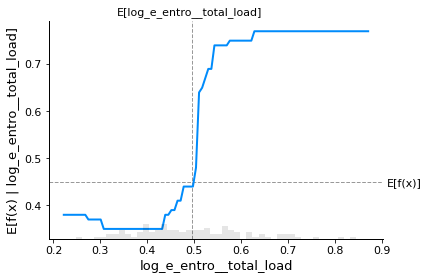

In [236]:
shap.partial_dependence_plot(
    "log_e_entro__total_load", model.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

In [237]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X_train)

Permutation explainer: 7933it [21:11,  6.19it/s]                                                                       


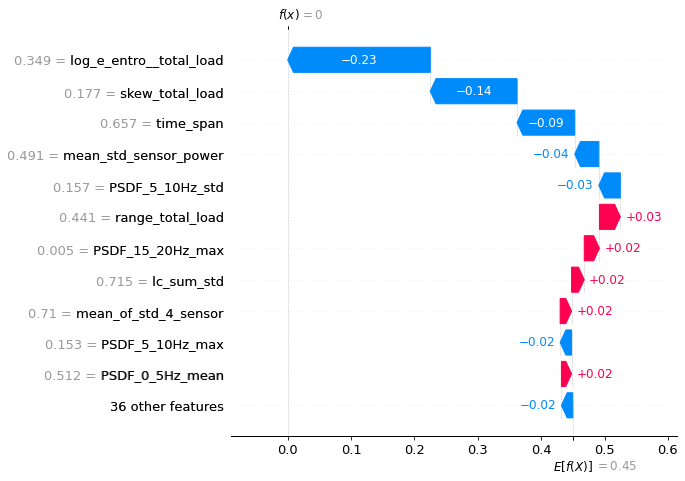

In [238]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=12)

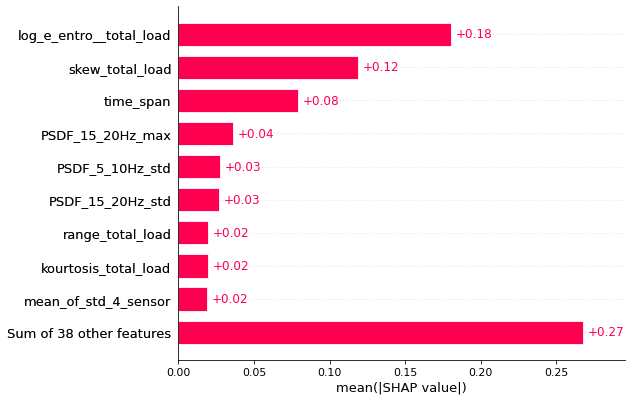

In [239]:
shap.plots.bar(shap_values)

Permutation explainer: 7933it [20:18,  6.45it/s]                                                                       


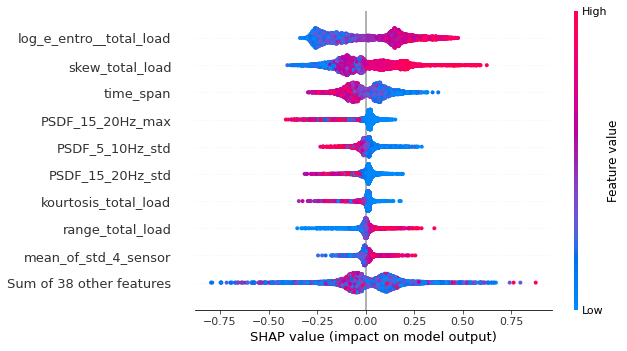

In [240]:
explainer_ebm = shap.Explainer(model.predict, X100)
shap_values_ebm = explainer_ebm(X_train)
shap.plots.beeswarm(shap_values_ebm)

# Model 2: Urination & Defecation Misclassification

In [241]:
X = pd.concat((X_train,X_validate,X_test))
y_test_pred_df_2 = np.concatenate((y_train_pred,y_validate_pred,y_test_pred), axis = 0)
finaal_df_2 = pd.DataFrame(X)
finaal_df_2
finaal_df_2['y_pred_2'] = y_test_pred_df_2

misclassification2 = finaal_df_2.join(dataset['urination'])
misclassification2.head(1)

misclassification2 = misclassification2.reset_index()

misclassification2['class'] = 'yes'
for i in range(0, len(misclassification2)):
    if misclassification2['urination'][i] != misclassification2['y_pred_2'][i]: 
        misclassification2['class'][i] = 'No'     
        


<AxesSubplot:xlabel='PSDF_0_5Hz_max', ylabel='time_span'>

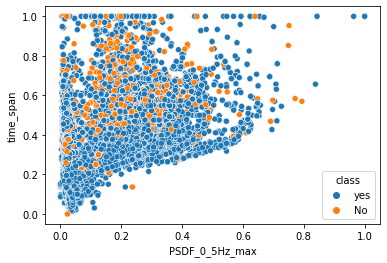

In [242]:
sns.scatterplot(x ='PSDF_0_5Hz_max', y = 'time_span', data =  misclassification2, hue= 'class' )

<AxesSubplot:xlabel='PSDF_0_5Hz_max', ylabel='log_e_entro__total_load'>

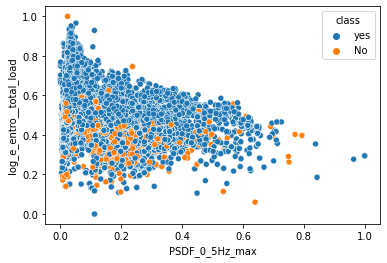

In [243]:
sns.scatterplot(x ='PSDF_0_5Hz_max', y = 'log_e_entro__total_load', data =  misclassification2, hue= 'class' )

<AxesSubplot:xlabel='PSDF_0_5Hz_max', ylabel='log_e_entro__total_load'>

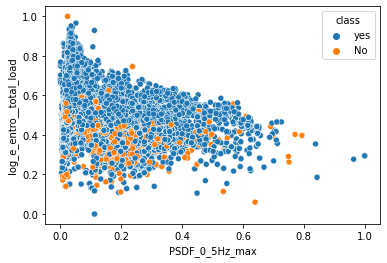

In [244]:
sns.scatterplot(x ='PSDF_0_5Hz_max', y = 'log_e_entro__total_load', data =  misclassification2, hue= 'class' )

In [245]:
a = misclassification2[misclassification2['class']== 'No']
a[a['urination'] == 0]

,index,lc_sum_mean,lc_sum_std,time_span,min_total_load,max_total_load,median_total_load,skew_total_load,kourtosis_total_load,range_total_load,log_e_entro__total_load,lc_max_4_sensor,lc_min_4_sensor,std_of_mean_4_sensor,max_of_std_4_sensor,min_of_std_4_sensor,mean_of_std_4_sensor,std_of_std_4_sensor,last_sum,PSDF_0_5Hz_max,PSDF_0_5Hz_min,PSDF_0_5Hz_median,PSDF_0_5Hz_mean,PSDF_0_5Hz_std,PSDF_5_10Hz_max,PSDF_5_10Hz_min,PSDF_5_10Hz_median,PSDF_5_10Hz_mean,PSDF_5_10Hz_std,PSDF_10_15Hz_max,PSDF_10_15Hz_min,PSDF_10_15Hz_median,PSDF_10_15Hz_mean,PSDF_10_15Hz_std,PSDF_15_20Hz_max,PSDF_15_20Hz_min,PSDF_15_20Hz_median,PSDF_15_20Hz_mean,PSDF_15_20Hz_std,power_by_cat,std_total_power,std_sensor_power,mean_std_sensor_power,Time_bin_Time_Night_9,Time_bin_Time_day_Night,Month_bin_Month_Nov_July,Weight_bins_good,Weight_bins_more_weight,y_pred_2,urination,class
5,6,0.548147,0.775486,0.466718,0.485435,0.528338,0.610991,0.196756,0.000663,0.415223,0.442857,0.256718,0.689568,0.160123,0.524665,0.606265,0.681989,0.317806,0.427249,0.415582,0.000444,0.111655,0.602027,0.575582,0.093827,0.002130,0.082315,0.105802,0.102412,0.078242,0.000035,0.071208,0.075148,0.074655,0.006331,0.000080,0.058247,0.060200,0.016115,0.105081,0.421410,0.421410,0.271261,0,1,0,0,1,1,0,No
66,54,0.436113,0.888313,0.136694,0.401532,0.460032,0.293568,0.227913,0.000387,0.408612,0.745714,0.273718,0.351034,0.494403,0.546897,0.447034,0.750519,0.367510,0.352731,0.237112,0.076821,0.129602,0.788996,0.522071,0.049079,0.449748,0.186083,0.162977,0.067282,0.039425,0.262491,0.272744,0.195863,0.044091,0.003901,0.286262,0.240946,0.196057,0.010626,0.026486,0.218039,0.218039,0.129032,0,1,1,0,1,1,0,No
67,54,0.436113,0.888313,0.136694,0.401532,0.460032,0.293568,0.227913,0.000387,0.408612,0.745714,0.273718,0.351034,0.494403,0.546897,0.447034,0.750519,0.367510,0.352731,0.237112,0.076821,0.129602,0.788996,0.522071,0.049079,0.449748,0.186083,0.162977,0.067282,0.039425,0.262491,0.272744,0.195863,0.044091,0.003901,0.286262,0.240946,0.196057,0.010626,0.026486,0.218039,0.218039,0.129032,0,1,1,0,1,1,0,No
68,54,0.436113,0.888313,0.136694,0.401532,0.460032,0.293568,0.227913,0.000387,0.408612,0.745714,0.273718,0.351034,0.494403,0.546897,0.447034,0.750519,0.367510,0.352731,0.237112,0.076821,0.129602,0.788996,0.522071,0.049079,0.449748,0.186083,0.162977,0.067282,0.039425,0.262491,0.272744,0.195863,0.044091,0.003901,0.286262,0.240946,0.196057,0.010626,0.026486,0.218039,0.218039,0.129032,0,1,1,0,1,1,0,No
69,54,0.436113,0.888313,0.136694,0.401532,0.460032,0.293568,0.227913,0.000387,0.408612,0.745714,0.273718,0.351034,0.494403,0.546897,0.447034,0.750519,0.367510,0.352731,0.237112,0.076821,0.129602,0.788996,0.522071,0.049079,0.449748,0.186083,0.162977,0.067282,0.039425,0.262491,0.272744,0.195863,0.044091,0.003901,0.286262,0.240946,0.196057,0.010626,0.026486,0.218039,0.218039,0.129032,0,1,1,0,1,1,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13067,12935,0.792805,0.612704,0.250559,0.713978,0.673042,0.803538,0.166880,0.004006,0.368723,0.568571,0.376000,0.878461,0.097264,0.414868,0.639719,0.613452,0.192588,0.630376,0.116858,0.004177,0.096701,0.376222,0.228504,0.140255,0.002242,0.079518,0.115544,0.135367,0.043456,0.000381,0.077012,0.077318,0.066130,0.003921,0.000027,0.027939,0.034375,0.011248,0.167129,0.202933,0.202933,0.168622,0,1,0,1,0,1,0,No
13068,12935,0.792805,0.612704,0.250559,0.713978,0.673042,0.803538,0.166880,0.004006,0.368723,0.568571,0.376000,0.878461,0.097264,0.414868,0.639719,0.613452,0.192588,0.630376,0.116858,0.004177,0.096701,0.376222,0.228504,0.140255,0.002242,0.079518,0.115544,0.135367,0.043456,0.000381,0.077012,0.077318,0.066130,0.003921,0.000027,0.027939,0.034375,0.011248,0.167129,0.202933,0.202933,0.168622,0,1,0,1,0,1,0,No
13069,12935,0.792805,0.612704,0.250559,0.713978,0.673042,0.803538,0.166880,0.004006,0.368723,0.568571,0.376000,0.878461,

<AxesSubplot:xlabel='class', ylabel='PSDF_0_5Hz_std'>

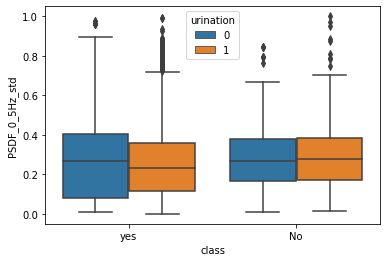

In [246]:
sns.boxplot(x ='class', y = 'PSDF_0_5Hz_std', data =  misclassification2 ,hue = 'urination')

<AxesSubplot:xlabel='class', ylabel='PSDF_0_5Hz_max'>

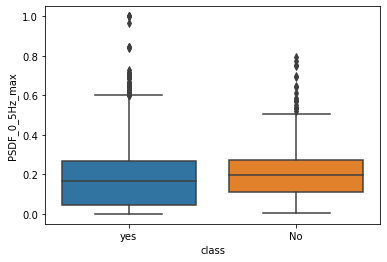

In [247]:
sns.boxplot(x ='class', y = 'PSDF_0_5Hz_max', data =  misclassification2 )

<AxesSubplot:xlabel='class', ylabel='log_e_entro__total_load'>

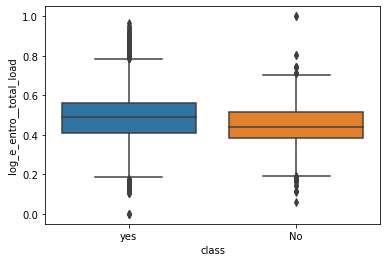

In [248]:
sns.boxplot(x ='class', y = 'log_e_entro__total_load', data =  misclassification2 )

<AxesSubplot:xlabel='class', ylabel='time_span'>

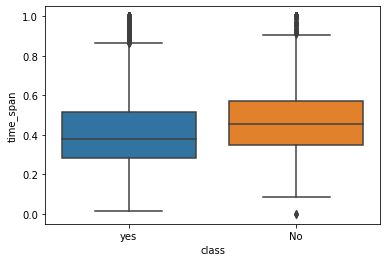

In [249]:
sns.boxplot(x ='class', y = 'time_span', data =  misclassification2 )

<AxesSubplot:xlabel='class', ylabel='PSDF_0_5Hz_std'>

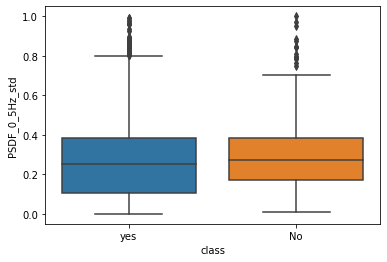

In [250]:
sns.boxplot(x ='class', y = 'PSDF_0_5Hz_std', data =  misclassification2 )

<AxesSubplot:xlabel='non_elimination', ylabel='PSDF_0_5Hz_max'>

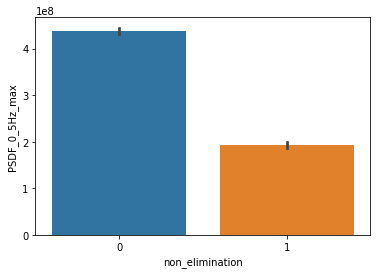

In [251]:
sns.barplot(x = 'non_elimination', y= 'PSDF_0_5Hz_max', data = dataset)

<AxesSubplot:xlabel='urination', ylabel='PSDF_0_5Hz_max'>

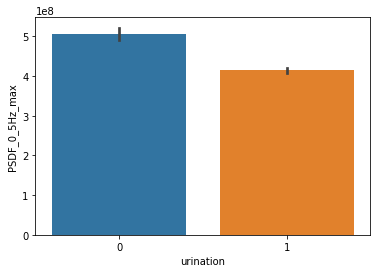

In [252]:
sns.barplot(x = 'urination', y= 'PSDF_0_5Hz_max', data = dataset[dataset['non_elimination']== 0])